### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Features
Prepare rasters as model inputs for the TI-City Model:
1. Density
- Import [WorldPop](https://www.worldpop.org/) data (tip: use [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description) data at 100 m resolution)
- Calculate density
- Resample to 150 m resolution [currently done in ArcGIS Pro]
- Ressample and co-register to 150 m grid
- Export to ASCII format

2. Real estate prices
- MUM and JAK: Import real estate empirical data from [Le Petit et al. (2023)](https://linkinghub.elsevier.com/retrieve/pii/S235234092300080X)
- MAN: scrap data from the [Lamudi](https://www.lamudi.com.ph/) real estate portal
- Select city in the AOI or clip to the AOI
- Interpolate point data [currently done in ArcGIS Pro, using [Empirical Bayesian Kriging](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geostatistical-analyst/empirical-bayesian-kriging.htm)]
- Ressample and co-register to 30 m grid [currently done in ArcGIS Pro]
- Export to ASCII format

3. Built-up 2000 & built-up 2010
- Import [Global Urban Footprint](https://www.dlr.de/en/eoc/research-transfer/projects-missions/global-urban-footprint-guf) data
- Calculate distance raster
- Ressample and co-register to 150 m grid
- Export to ASCII format

4. Districts
- Rasterize [GADM4](https://gadm.org/data.html) polygons
- Export to ASCII format

5. Tenure status
- There is no global dataset
- For the Mumbai case, import the  MMRDA 2016 slum clusters
- For the Manila case, import the 2021 data census
- Convert to raster
- Ressample and co-register to 150 m grid
- Export to ASCII format

6. Exclusion layer
- Import water bodies from [HydroSHEDS](https://www.hydrosheds.org/)
- Convert to raster
- Ressample and co-register to 150 m grid
- Export to ASCII format

7. Attractiveness 2000 & 2020
- Calculate the centrality using [OSMnX](https://osmnx.readthedocs.io/en/stable/user-reference.html) data
- Select the top 15 percentile
- Calculate Euclidian distances to it
- Export to ASCII format

8. Calculate proximity using OSM data
- Fetch OSM data for health_facilities, schools, suburban_centres, shopping_malls, markets, airport, cbd
- Classify major features
- Rasterize and calculate Euclidian distance to major features
- Export to shapefile, TIFF and ASCII formats.

9. Slope
- calculated externally (ArcGIS) using TanDEM X data at 150 m resolution

### Prerequisites
- AOI vector file (i.e., shapefile or geopackage)
- Raster reference file with the same extent as the AOI

## Roadmap:


### Version 0.3 
1. Simplify georeferencing procedure for 150 m resolution and corresponding grid
- [X] 150 m reference grid for Population
- [X] 150 m reference grid for Built up
- [X] 150 m reference grid for Districts
- [X] 150 m reference grid for OSM Distances
- [ ] 150 m reference grid for slope
- [ ] 150 m reference grid for DEM
- [ ] 150 m reference grid for Tenure/informality
- [ ] 150 m reference grid for Exclusion
- [ ] 150 m reference grid for Attractiveness
- [ ] 150 m reference grid for Income/wealth
- [ ] 150 m reference grid for Real estate
- [ ] 150 m reference grid for Planning
- [ ] 150 m reference grid for Hazards
- [ ] Historical OSM distances

2. Combine model inputs with quality checks (i.e. ti_city_02_check_inputs.ipynb)

3. Remove the need for further AOI conversion (i.e., ti_city_04_convert_inputs_new_AOI.ipynb)
- [ ] check max AOI dimensions in NetLogo

4. Test distance function sensitivity (to try to keep it all in Python, removing ArcGIS)
5. 

### Version 0.2 
on 02.03.2024
1. develop cost-distance function
2. clip contents to new MAN AOI, similar to the results from SLEUTH simulation by Dr Olabisi Obaitor
3. create inputs quality checks:
- [X] registration and number of cells
- [X] value type (integers, float, text)
- [X] remove negative values from normalised layers
- [X] export corrected outputs and overwrite old ones when necessary
- [X] rename ASCII files

on 02.12.2024
1. [X] Update data model documentation
- [X] move and group context-dependent functions to the end of the notebook
1. [X] Review data model for unused features and remove them
2. [X] Adjust model for AOI selection between MUM, JAK, and MAN
- [X] Adjust **real estate prices** imports for AOI selection

On 15.11.2024
1. [X] Create basic functions for each feature
- [X] (need to include all completed sub-features, e.g., 1. Population > Import and downscale population data from WorldPop)
2. [X] Adjust model for AOI selection between MUM, JAK, and MAN
- [X] create segmentation at the init 
- [X] Adjust **population** imports for AOI selection
- [X] Adjust **built-up** imports for AOI selection
- [X] Adjust **districts** imports for AOI selection
- [X] Adjust **tenure** imports for AOI selection for MAN
- [X] Adjust **exclusion** imports for AOI selection
- [X] Adjust **attractiveness** imports for AOI selection
- [X] Adjust **facilities distances** imports for AOI selection
- [X] Adjust **slope** imports for AOI selection
- [X] Standardise file names for the exclusion layer (water bodies, national parks, other limitations)
- [X] Standardise file names for the census districts/wards/tracts (depending on the case)
- [X] Adjust export functions to take the case_city as prefix

### Version 0.1
1. create import functions based on AOI: import, rasterize (when necessary), clip, export
2. create distance functions based on OSM (roads, health, schoolds, suburban centres, ...)
3. 

# imports

In [1]:
# utils
import os
from pathlib import Path
import fnmatch
import shutil
import tempfile
import logging

# maths
import numpy as np
import random 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter, distance_transform_edt
from skimage.graph import route_through_array

# GIS
from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiLineString, LineString
import json
import pandas as pd
import geopandas as gpd
import osmnx as ox

# raster stuff
import rasterio
from rasterio import features
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.mask import mask
from rasterio.plot import show, show_hist, plotting_extent
from rasterio import plot
from osgeo import gdal, osr    
import ee
import geemap

# init

In [2]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
#  the 'case_city' variable defines the city we are working on. APS: Need to update the code below to change it from MUM to the variable name

case_city = 'JAK' #MUM MAN JAK

if case_city == 'MUM':
    
    AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')
    ref_raster_150_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')
    

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MUM/data/in/')
    ti_city_out_path = Path('../model/MUM/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_3'

if case_city == 'MAN':
    
    AOI_gdf = gpd.read_file(AOI_path / MAN_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MAN_LIM_reference_AOI_150m.tif')
    ref_raster_150_path = Path('../data/processed/MAN_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MAN/data/in/')
    ti_city_out_path = Path('../model/MAN/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_2'

if case_city == 'JAK':
    
    AOI_gdf = gpd.read_file(AOI_path / JAK_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')
    ref_raster_150_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/JAK/data/in/')
    ti_city_out_path = Path('../model/JAK/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_3'

external_data_path = Path(r'D:\\Dropbox\\x\\_data')
ascii150_arcgis_path = Path(r"D:\\Dropbox\\x\\PostDoc\ASCII_150m")

%run ./ti_city_00_raster_functions.ipynb

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src: # APS 20.08.2025 using the 150 m raster
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)



# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

DataSourceError: ..\data\processed\JAK_LIM_reference_AOI_30m.shp: No such file or directory

# Preparing rasters

# 1. Population density
- Import WorldPop data
- Calculate density
- Ressample and co-register to 150 m grid

### Ressampling the pop data from ca. 100 m to 150 m

ps: Daysimetric mapping:
Performin daysimetric mapping, as suggested in https://gis.stackexchange.com/questions/141763/after-turning-census-block-data-into-a-raster-how-do-i-redistribute-the-density
1. Create a density grid for the Census data by dividing each polygon's count by its area and converting that directly to raster format.
2. Create a relative density grid for the land cover data by joining the relative density table to the land cover type identifier.
3. Multiply the two grids (1) and (2).
4. Compute a zonal sum of the product in (3), using the Census regions as zones. Store this as a raster rather than a table.
5. Multiply (3) by the Census counts, divide by (4), and divide by the cell area.

In [3]:
# fetch population data from WorldPOP using gee
# data source: https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-alexandresantosgeographie') # Replace with your GEE project 
print(ee.__version__)



Successfully saved authorization token.
1.5.20


In [4]:
# check if the authentication is working
print(ee.Image("JRC/GHSL/P2023A/GHS_POP/1975").getInfo()) #.get("smod_code")

{'type': 'Image', 'bands': [{'id': 'population_count', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [360820, 180000], 'crs': 'PROJCS["World_Mollweide", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH]], \n  PROJECTION["Mollweide"], \n  PARAMETER["semi_minor", 6378137.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["central_meridian", 0.0], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH]]', 'crs_transform': [100, 0, -18041000, 0, -100, 9000000]}], 'version': 1690185742435464, 'id': 'JRC/GHSL/P2023A/GHS_POP/1975', 'properties': {'system:time_start': 157766400000, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], 

In [ ]:
# select the image from the country at hand from https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop

if case_city == 'MUM':
    case_image2000 = ee.Image('WorldPop/GP/100m/pop/IND_2000') # India
    case_image2020 = ee.Image('WorldPop/GP/100m/pop/IND_2020') # India
    case_aoi_crs, case_roi, case_rec_roi, case_coi = get_coords(AOI_gdf.to_crs('EPSG:4326'))
if case_city == 'JAK':
    case_image2000 = ee.Image('WorldPop/GP/100m/pop/IDN_2000') # Indonesia
    case_image2020 = ee.Image('WorldPop/GP/100m/pop/IDN_2020') # Indonesia
    case_aoi_crs, case_roi, case_rec_roi, case_coi = get_coords(AOI_gdf.to_crs('EPSG:4326'))
if case_city == 'MAN':
    case_image2000 = ee.Image('WorldPop/GP/100m/pop/PHL_2000') # Philippines
    case_image2020 = ee.Image('WorldPop/GP/100m/pop/PHL_2020') # Philippines
    case_aoi_crs, case_roi, case_rec_roi, case_coi = get_coords(AOI_gdf.to_crs('EPSG:4326'))

print(case_city, '2000 stats:', check_image_stats(case_image2000, case_roi))
print(case_city, '2020 stats:', check_image_stats(case_image2020, case_roi))

JAK 2000 stats: {'population_max': 177.91664123535156, 'population_min': 0.12160186469554901}
JAK 2020 stats: {'population_max': 235.88604736328125, 'population_min': 0.3855913281440735}


In [10]:
Map = geemap.Map()
Map.centerObject(case_roi, zoom=9)

populationCountVis = {
  'min': 0.0,
  'max': 100.0,
  'palette':['000004', '320A5A', '781B6C', 'BB3654', 'EC6824', 'FBB41A', 'FCFFA4']
}

image2000 = case_image2000.updateMask(case_image2000.gt(0))
image2020 = case_image2020.updateMask(case_image2020.gt(0))

Map.addLayer(case_image2000, populationCountVis, 'Population count, 2000')
Map.addLayer(case_image2020, populationCountVis, 'Population count, 2020')
Map.addLayer(case_roi, {}, 'ROI', )
Map


Map(center=[-6.329038576274177, 106.78013104072295], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# create individual images for each of the AOIs

case_pop2000 = image2000.clip(case_rec_roi)
case_pop2020 = image2020.clip(case_rec_roi)
case_crs='EPSG:'+str(case_rec_roi)
print(case_city + '_pop2000 stats:', check_image_stats(case_pop2000, case_rec_roi))
print(case_city + '_pop2020 stats:', check_image_stats(case_pop2020, case_rec_roi))
Map = geemap.Map()
Map.centerObject(case_rec_roi, zoom=9)
Map.addLayer(case_pop2020, populationCountVis, 'Population count, 2020')
Map.addLayer(case_pop2000, populationCountVis, 'Population count, 2000')
Map.addLayer(case_roi, {}, 'ROI', )
Map


JAK_pop2000 stats: {'population_max': 177.91664123535156, 'population_min': 0.12160186469554901}
JAK_pop2020 stats: {'population_max': 235.88604736328125, 'population_min': 0.3855913281440735}


Map(center=[-6.329213585920722, 106.78013104072292], controls=(WidgetControl(options=['position', 'transparent…

In [4]:
# export the images for the case
# the function exports the images in the original CRS, as the reprojection caused a resampling error
# check the GEE tasks in the Earth Engine Code Editor 
%run ./ti_city_00_raster_functions.ipynb
case_task_2000 = export_ee_image(case_pop2000, case_city + '_POP_population_2000_WDPoP_WGS84', case_rec_roi) 
case_task_2020 = export_ee_image(case_pop2020, case_city + '_POP_population_2020_WDPoP_WGS84', case_rec_roi) 

# check task status
tasks = [case_task_2000, case_task_2020]
for task in tasks: 
    if task: 
        print(f'Task {task.status()["id"]} is {task.status()["state"]}')
    else:
        print('Task failed')

NameError: name 'case_pop2000' is not defined

## WorldPop

In [8]:
%run ./ti_city_00_raster_functions.ipynb

img_name_2000 = case_city + '_POP_population_2000_WDPop_90m.tif'
img_name_2020 = case_city + '_POP_population_2020_WDPop_90m.tif'

density_2000_fill, pop_raster_2000_area = calculate_density(external_path / img_name_2000, AOI_gdf)
density_2020_fill, pop_raster_2020_area = calculate_density(external_path / img_name_2020, AOI_gdf)

print('Reference raster area',ref_area, 
      '\nPopulation 2000 raster area',pop_raster_2000_area, 
      '\nPopulation 2020 raster area',pop_raster_2020_area)
print(density_2000_fill.shape, density_2020_fill.shape)



Reference raster area 900.0 
Population 2000 raster area 8494.79 
Population 2020 raster area 8494.79
(1, 1109, 1250) (1, 1109, 1250)


In [11]:
# export density_2000_normal as a raster
data_type = rasterio.float32
raster = density_2000_fill
img_name_2000 = case_city + '_POP_density_normal_2000_WDPop_90m.tif'

url = interim_path / img_name_2000

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = pop_raster_2000.crs,
    transform = pop_raster_2000.transform,
    dtype = data_type,
    count = 1,
    width = pop_raster_2000.width,
    height = pop_raster_2000.height) as dst:
    dst.write(raster) #, indexes = 1
#export_raster(density_2000_fill, density_2000_path, rasterio.float32)

In [10]:
# export density_2020_normal as a raster

data_type = rasterio.float32
raster = density_2020_fill
img_name_2020 = case_city + '_POP_density_normal_2020_WDPop_90m.tif'
url = interim_path / img_name_2020

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = pop_raster_2020.crs,
    transform = pop_raster_2020.transform,
    dtype = data_type,
    count = 1,
    width = pop_raster_2020.width,
    height = pop_raster_2020.height) as dst:
    dst.write(raster) #, indexes = 1

### check the transformations and co-register

In [13]:
raster_file_2000_150m =  case_city + '_POP_density_normal_2000_WDPop_temp_150m.tif'
raster_file_2000_90m =  case_city + '_POP_density_normal_2000_WDPop_90m.tif'
raster_file_2020_150m =  case_city + '_POP_density_normal_2020_WDPop_temp_150m.tif'
raster_file_2020_90m =  case_city + '_POP_density_normal_2020_WDPop_90m.tif'

# check if raster transformation makes sense

with rasterio.open(interim_path/raster_file_2020_90m,'r') as density_2020_90m:
    with rasterio.open(interim_path/raster_file_2020_150m,'r') as density_2020_150m:
      print('2020 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2020_90m.read(1)), 
         '\nOriginal mean raster density',np.nanmean(density_2020_150m.read(1)), 
         '\nOld cell size:',density_2020_90m.transform[0],'x',-density_2020_90m.transform[4],
         '\nNew cell size:',density_2020_150m.transform[0],'x',-density_2020_150m.transform[4])   

with rasterio.open(interim_path/raster_file_2000_90m,'r') as density_2000_90m:
    with rasterio.open(interim_path/raster_file_2000_150m,'r') as density_2000_150m:
      print('\n2000 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2000_90m.read(1)), 
            '\nOriginal mean raster density',np.nanmean(density_2000_150m.read(1)), 
            '\nOld cell size:',density_2000_90m.transform[0],'x',-density_2000_90m.transform[4],
            '\nNew cell size:',density_2000_150m.transform[0],'x',-density_2000_150m.transform[4])

2020 raster check: 
Ressampled mean raster density 0.12093278 
Original mean raster density 0.12058249 
Old cell size: 92.496 x 91.83949504057709 
New cell size: 150.0 x 150.0

2000 raster check: 
Ressampled mean raster density 0.094520524 
Original mean raster density 0.094248086 
Old cell size: 92.496 x 91.83949504057709 
New cell size: 150.0 x 150.0


In [16]:
# co-register the 150m raster to the ref_raster
raster_file_2000_150m =  case_city + '_POP_density_normal_2000_WDPop_temp_150m.tif'
raster_file_2020_150m =  case_city + '_POP_density_normal_2020_WDPop_temp_150m.tif'

in_file_2000 = interim_path/raster_file_2000_150m
in_file_2020 = interim_path/raster_file_2020_150m

out_file_2000 = interim_path/raster_file_2000_150m.replace('_temp_150m','_150m')
out_file_2020 = interim_path/raster_file_2020_150m.replace('_temp_150m','_150m')

reproj_match(infile = in_file_2000,
             match = ref_raster_path,
             outfile = out_file_2000,
             resampling=Resampling.bilinear)

reproj_match(infile = in_file_2020,
             match = ref_raster_path,
             outfile = out_file_2020,
             resampling=Resampling.bilinear)

Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|
Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|


### Copy the rasters to the model inputs folder

In [17]:
# 2000 
raster_file_2000 =  case_city + '_POP_density_normal_2000_WDPop_150m.tif'
raster_file_2020 =  case_city + '_POP_density_normal_2020_WDPop_150m.tif'

origin_path = interim_path / raster_file_2000
destination_path = model_inputs_150m_path / raster_file_2000

shutil.copy(src=origin_path, dst=destination_path)
print(str(destination_path))

# 2020
origin_path = interim_path / raster_file_2020
destination_path = model_inputs_150m_path / raster_file_2020

shutil.copy(origin_path, destination_path)
print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_POP_density_normal_2000_WDPop_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_POP_density_normal_2020_WDPop_150m.tif


### Convert the externally resampled density 2000 raster to ASCII


In [ ]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition

%run ./ti_city_00_raster_functions.ipynb

dens_2000_tiff_file = case_city + '_POP_density_normal_2000_WDPop_150m.tif'
dens_2000_ascii_file = case_city + '_POP_density_normal_2000_WDPop_150m.asc'
dens_2020_tiff_file = case_city + '_POP_density_normal_2020_WDPop_150m.tif'
dens_2020_ascii_file = case_city + '_POP_density_normal_2020_WDPop_150m.asc'

with rasterio.open(interim_path/ dens_2000_tiff_file,'r') as density_2000_150m:
  # exporting as ASCII
  raster_obj = np.where(np.isnan(density_2000_150m.read(1)), 0, density_2000_150m.read(1))
  export_path = interim_path/dens_2000_ascii_file
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster_path,raster_data_type)

with rasterio.open(interim_path/dens_2020_tiff_file,'r') as density_2020_150m:
  # exporting as ASCII
  raster_obj = np.where(np.isnan(density_2020_150m.read(1)), 0, density_2020_150m.read(1))
  export_path = interim_path/dens_2020_ascii_file
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster_path,raster_data_type)


## GHSL (as an alternative to WorldPop)

In [41]:
%run ./ti_city_00_raster_functions.ipynb

ghsl_path = external_data_path / 'WD GHSL Pop'
if case_city == 'MUM':
    ghsl_2000_file = 'some_file.tif' # these names need replacing when we download the GHSL data
    ghsl_2020_file = 'some_file.tif'
elif case_city == 'MAN':
    ghsl_2000_file = 'some_file.tif' # these names need replacing when we download the GHSL data
    ghsl_2020_file = 'some_file.tif'
elif case_city == 'JAK':
    ghsl_2000_file = ghsl_path / 'GHS_POP_E2000_GLOBE_R2023A_4326_3ss_V1_0_R10_C29_WGS84_48S.tif'
    ghsl_2020_file = ghsl_path / 'GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_R10_C29_WGS84_48S.tif'

ghsl_density_2000, pop_raster_2000_area, pop_raster_2000_transform  = calculate_density(ghsl_2000_file, AOI_gdf)
ghsl_density_2020, pop_raster_2020_area, pop_raster_2020_transform  = calculate_density(ghsl_2020_file, AOI_gdf)

print('Reference raster area',ref_area, 
      '\nPopulation 2000 raster area',pop_raster_2000_area, 
      '\nPopulation 2020 raster area',pop_raster_2020_area)
print(ghsl_density_2000.shape, ghsl_density_2020.shape)

EPSG:32748
height:  92.66730057061889 
width:  92.66730056470428
EPSG:32748
height:  92.6673005706181 
width:  92.66730056470504
Reference raster area 22500.0 
Population 2000 raster area 8587.23 
Population 2020 raster area 8587.23
(1, 1100, 1248) (1, 1100, 1248)


### export the raster

In [45]:
print(pop_raster_2000_transform[4])

-92.66730056470428


In [47]:
# export the 2000 density raster to the interim folder
data_type = rasterio.float32
raster = ghsl_density_2000
img_name_2000 = case_city + '_POP_density_normal_2000_GHSL_90m.tif'
url = interim_path / img_name_2000
transform = pop_raster_2000_transform

with rasterio.open(ghsl_2000_file, 'r') as ref_export:
    try:
        with rasterio.open(
            url, "w",
            driver = "GTiff",
            crs = ref_export.crs,
            transform = transform,
            dtype = data_type,
            compress='lzw',
            count = 1,
            height = raster.shape[1],
            width = raster.shape[2]) as dst:
            dst.write(raster) #, indexes = 1
        print("Raster written successfully:\n", url)
    except Exception as e:
        print('Raster export error:', e)

Raster written successfully:
 D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\interim\JAK_POP_density_normal_2000_GHSL_90m.tif


In [48]:
# export the 2020 density raster to the interim folder
data_type = rasterio.float32
raster = ghsl_density_2020
img_name_2020 = case_city + '_POP_density_normal_2020_GHSL_90m.tif'
url = interim_path / img_name_2020

with rasterio.open(ghsl_2020_file, 'r') as ref_export:
    try:
        with rasterio.open(
            url, "w",
            driver = "GTiff",
            crs = ref_export.crs,
            transform = transform,
            dtype = data_type,
            compress='lzw',
            count = 1,
            height = raster.shape[1],
            width = raster.shape[2]) as dst:
            dst.write(raster) #, indexes = 1
        print("Raster written successfully:\n", url)
    except Exception as e:
        print('Raster export error:', e)

Raster written successfully:
 D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\interim\JAK_POP_density_normal_2020_GHSL_90m.tif


### check the transformations and co-register

In [51]:
raster_file_2000_150m =  case_city + '_POP_density_normal_2000_GHSL_temp_150m.tif'
raster_file_2000_90m =  case_city + '_POP_density_normal_2000_GHSL_90m.tif'
raster_file_2020_150m =  case_city + '_POP_density_normal_2020_GHSL_temp_150m.tif'
raster_file_2020_90m =  case_city + '_POP_density_normal_2020_GHSL_90m.tif'

# check if raster transformation makes sense

with rasterio.open(interim_path/raster_file_2000_90m,'r') as density_2000_90m:
    with rasterio.open(interim_path/raster_file_2000_150m,'r') as density_2000_150m:
      print('\n2000 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2000_90m.read(1)), 
            '\nOriginal mean raster density',np.nanmean(density_2000_150m.read(1)), 
            '\nOld cell size:',density_2000_90m.transform[0],'x',-density_2000_90m.transform[4],
            '\nNew cell size:',density_2000_150m.transform[0],'x',-density_2000_150m.transform[4],'\n')
      
with rasterio.open(interim_path/raster_file_2020_90m,'r') as density_2020_90m:
    with rasterio.open(interim_path/raster_file_2020_150m,'r') as density_2020_150m:
      print('2020 raster check:',
         '\nRessampled mean raster density',np.nanmean(density_2020_90m.read(1)), 
         '\nOriginal mean raster density',np.nanmean(density_2020_150m.read(1)), 
         '\nOld cell size:',density_2020_90m.transform[0],'x',-density_2020_90m.transform[4],
         '\nNew cell size:',density_2020_150m.transform[0],'x',-density_2020_150m.transform[4])   


2000 raster check: 
Ressampled mean raster density 0.014296316 
Original mean raster density 0.014245453 
Old cell size: 92.66730057061889 x 92.66730056470428 
New cell size: 150.0 x 150.0 

2020 raster check: 
Ressampled mean raster density 0.020888355 
Original mean raster density 0.02081679 
Old cell size: 92.66730057061889 x 92.66730056470428 
New cell size: 150.0 x 150.0


In [53]:
# co-register the 150m raster to the ref_raster
raster_file_2000_150m =  case_city + '_POP_density_normal_2000_GHSL_temp_150m.tif'
raster_file_2020_150m =  case_city + '_POP_density_normal_2020_GHSL_temp_150m.tif'

in_file_2000 = interim_path/raster_file_2000_150m
in_file_2020 = interim_path/raster_file_2020_150m

out_file_2000 = interim_path/raster_file_2000_150m.replace('_temp_150m','_150m')
out_file_2020 = interim_path/raster_file_2020_150m.replace('_temp_150m','_150m')

reproj_match(infile = in_file_2000,
             match = ref_raster_path,
             outfile = out_file_2000,
             resampling=Resampling.bilinear)

reproj_match(infile = in_file_2020,
             match = ref_raster_path,
             outfile = out_file_2020,
             resampling=Resampling.bilinear)

Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|
Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|


### Copy the rasters to the model inputs folder

In [54]:
# 2000 
raster_file_2000 =  case_city + '_POP_density_normal_2000_GHSL_150m.tif'
raster_file_2020 =  case_city + '_POP_density_normal_2020_GHSL_150m.tif'

origin_path = interim_path / raster_file_2000
destination_path = model_inputs_150m_path / raster_file_2000

shutil.copy(src=origin_path, dst=destination_path)
print(str(destination_path))

# 2020
origin_path = interim_path / raster_file_2020
destination_path = model_inputs_150m_path / raster_file_2020

shutil.copy(origin_path, destination_path)
print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_POP_density_normal_2000_GHSL_150m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_POP_density_normal_2020_GHSL_150m.tif


### Convert the externally resampled density 2000 raster to ASCII


In [55]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition

%run ./ti_city_00_raster_functions.ipynb

dens_2000_tiff_file = case_city + '_POP_density_normal_2000_GHSL_150m.tif'
dens_2000_ascii_file = case_city + '_POP_density_normal_2000_GHSL_150m.asc'
dens_2020_tiff_file = case_city + '_POP_density_normal_2020_GHSL_150m.tif'
dens_2020_ascii_file = case_city + '_POP_density_normal_2020_GHSL_150m.asc'

with rasterio.open(interim_path/ dens_2000_tiff_file,'r') as density_2000_150m:
  # exporting as ASCII
  raster_obj = np.where(np.isnan(density_2000_150m.read(1)), 0, density_2000_150m.read(1))
  export_path = interim_path/dens_2000_ascii_file
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster_path,raster_data_type)

with rasterio.open(interim_path/dens_2020_tiff_file,'r') as density_2020_150m:
  # exporting as ASCII
  raster_obj = np.where(np.isnan(density_2020_150m.read(1)), 0, density_2020_150m.read(1))
  export_path = interim_path/dens_2020_ascii_file
  ref_raster=ref_raster
  raster_data_type=rasterio.float32
  export_raster_to_ascii(raster_obj, export_path, ref_raster_path,raster_data_type)


# 2. Built-up 2000 & built-up 2010
- Calculate distance raster
- Ressample and co-register to 150 m grid

### import, clip & reclass
import WUF data, clip it to the AOI, and reclassify it in three different rasters: 1985, 2000 (and before), and 2015 (and before) <br>
import the WUF data


In [60]:
print(case_city)

JAK


JAK_URB_urban_evolution_EOC_WUF_noclip.tif
Unique values [         0       1985       1986       1987       1988       1989
       1990       1991       1992       1993       1994       1995
       1996       1997       1998       1999       2000       2001
       2002       2003       2004       2005       2006       2007
       2008       2009       2010       2011       2012       2013
       2014       2015 2147483647] 
Min value 0 , Type: int32


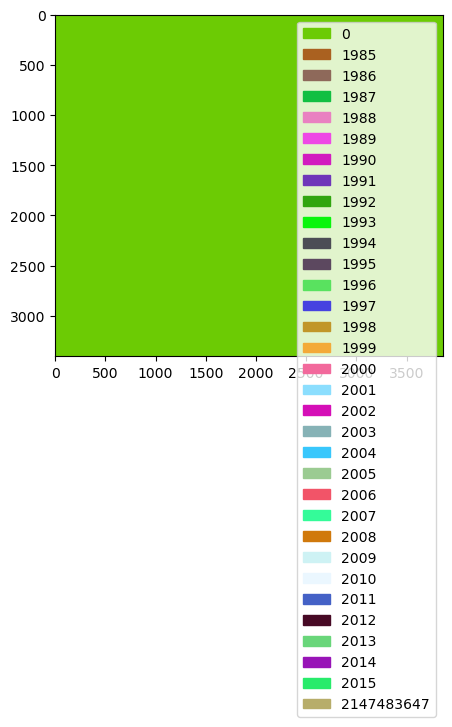

In [61]:
urban_file = case_city + '_URB_urban_evolution_EOC_WUF_noclip.tif'
print(urban_file)
urban_wuf_path = external_path / urban_file
# clip the raster to the AOI
case_urb_raster, case_urb_transform, case_urb_meta = clip_raster(raster_path=urban_wuf_path, aoi=AOI_gdf)

#print(urban_file, case_urb_meta)
plot_unique_value_raster(case_urb_raster)

In [57]:
# extract one raster for each period
%run ./ti_city_00_raster_functions.ipynb

values_list = [1985, 2000, 2015]
urban_raster_list = extract_rasters(case_urb_raster, values_list)
for i in range(len(urban_raster_list)):
    urban_raster_list[i] = urban_raster_list[i].astype('int16') 
    #urban_raster_list[i] = np.where(urban_raster_list[i] == 0, 0, urban_raster_list[i])
urban_raster_list

[array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)]

In [62]:
ref_raster = ref_raster # APS 20.08.2025 using the 150 m raster
transform = case_urb_meta['transform']
height = case_urb_meta['height']
width = case_urb_meta['width']
dtype = rasterio.int16
no_data = 0
crs=case_urb_meta['crs']

export_raster_list = urban_raster_list

for n in range(len(values_list)):
    out_file = case_city + '_URB_urbanisation_' + str(values_list[n]) + '_EOC_WUF_temp_150m.tif'
    out_url = interim_path/out_file
    print(n, out_url, export_raster_list[n].astype(dtype))
    
    with rasterio.open(out_url, "w", 
                       driver='GTiff',
                       height = height, 
                       width=width,
                       count=1, 
                       dtype=dtype,
                       crs=crs,
                       nodata=no_data, 
                       transform = transform
                       ) as dest:
            dest.write(export_raster_list[n].squeeze().astype(dtype), indexes=1)


0 D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\interim\JAK_URB_urbanisation_1985_EOC_WUF_temp_150m.tif [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
1 D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\interim\JAK_URB_urbanisation_2000_EOC_WUF_temp_150m.tif [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
2 D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\interim\JAK_URB_urbanisation_2015_EOC_WUF_temp_150m.tif [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [63]:
# co-register the rasters to the 30m resolution
case_urb_1985 = case_city + '_URB_urbanisation_1985_EOC_WUF_temp_150m.tif'
case_urb_2000 = case_city + '_URB_urbanisation_2000_EOC_WUF_temp_150m.tif'
case_urb_2015 = case_city + '_URB_urbanisation_2015_EOC_WUF_temp_150m.tif'

urb_list = [case_urb_1985, case_urb_2000, case_urb_2015]

for raster in urb_list:
    reproj_match(infile=interim_path/raster, 
                 match=ref_raster_path, 
                 outfile = interim_path/raster.replace('_temp_150m','_150m'), 
                 resampling=Resampling.nearest)

Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|
Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|
Coregistered to shape: 680 772 
 Affine | 150.00, 0.00, 639000.00|
| 0.00,-150.00, 9351000.00|
| 0.00, 0.00, 1.00|


## calculate distances

In [68]:
# import the files recently exported
case_urb_1985 = case_city + '_URB_urbanisation_1985_EOC_WUF_150m.tif'
case_urb_2000 = case_city + '_URB_urbanisation_2000_EOC_WUF_150m.tif'
case_urb_2015 = case_city + '_URB_urbanisation_2015_EOC_WUF_150m.tif'

urb_1985_path = interim_path / case_urb_1985
urb_2000_path = interim_path / case_urb_2000
urb_2015_path = interim_path / case_urb_2015

builtup_2000_path = interim_path / urb_2000_path
builtup_2015_path = interim_path / urb_2015_path

def calculate_distance(raster):
    with rasterio.open(raster, 'r') as src:
        data = src.read(1)
        data_inverted = np.where(data == 1, 0, 1)
        
        # Calculate the distance to the nearest road for each cell
        distance_raster = distance_transform_edt(data_inverted)
        # Assuming the raster's resolution is in meters, the distance_to_roads array now contains the distance in meters to the nearest road for each cell
        
        # normalize the raster by the min-max method
        distance_raster_normalized = (distance_raster - np.nanmin(distance_raster))/(np.nanmax(distance_raster) - np.nanmin(distance_raster))
        return distance_raster_normalized
#print(builtup_2000_path,'\n', builtup_2015_path)
distance_builtup_2000 = calculate_distance(builtup_2000_path)
distance_builtup_2015 = calculate_distance(builtup_2015_path)


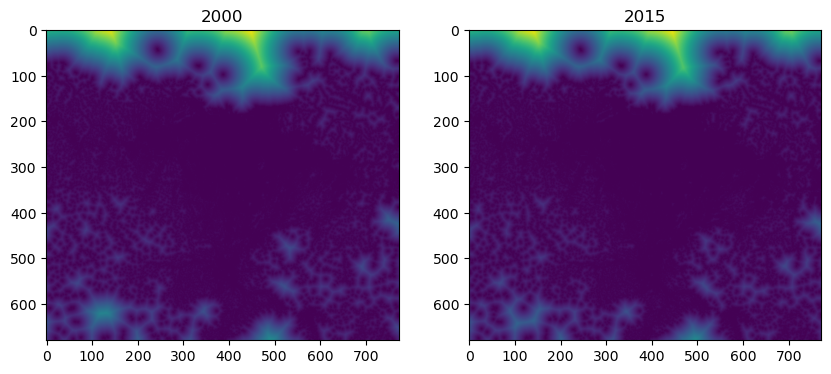

In [69]:
# let's plot it to have a look
plot_ras_ras(distance_builtup_2000, distance_builtup_2015, title1='2000', title2='2015', AOI_gdf = AOI_gdf)

## export distances to tiff and ascii

In [70]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition
distance_2000_file = case_city + '_URB_distance_urbanisation_2000_EOC_WUF_150m.tif'
distance_2015_file = case_city + '_URB_distance_urbanisation_2015_EOC_WUF_150m.tif'


# export to tiff
# 2000 raster
raster_obj = distance_buitup_2000
export_path = interim_path/distance_2000_file
raster_data_type=rasterio.float32
export_raster(raster_obj,export_path,raster_data_type)

# 2015 raster
raster_obj = distance_buitup_2015
export_path = interim_path/distance_2015_file
ref_raster=ref_raster
raster_data_type=rasterio.float32
export_raster(raster_obj,export_path,raster_data_type)

In [ ]:
## ATTENTION: THIS FUNCTION OFTEN CRASES THE KERNEL
# take care to pass the raster_obj as a numpy array and not as a rasterio object
# exporting as ASCII
ascii_file_2000 = case_city + '_URB_distance_urbanisation_2000_EOC_WUF_30m.asc'
ascii_file_2015 = case_city + '_URB_distance_urbanisation_2015_EOC_WUF_30m.asc'

# 2000 raster
raster_obj = distance_buitup_2000
export_path = interim_path/ascii_file_2000
ref_raster=ref_raster
raster_data_type=rasterio.float32
export_raster_to_ascii(raster_obj, export_path, ref_raster, raster_data_type)

# 2015 raster
raster_obj = distance_buitup_2015
export_path = interim_path/ascii_file_2015
ref_raster=ref_raster
raster_data_type=rasterio.float32
export_raster_to_ascii(raster_obj, export_path, ref_raster, raster_data_type)


: 

## Copy the rasters to the model inputs folder

In [33]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition

urb_raster_file_1985 = case_city + '_URB_urbanisation_1985_EOC_WUF_30m.tif'
urb_raster_file_2000 = case_city + '_URB_urbanisation_2000_EOC_WUF_30m.tif'
urb_raster_file_2015 = case_city + '_URB_urbanisation_2015_EOC_WUF_30m.tif'
dist_raster_file_2000 = case_city + '_URB_distance_urbanisation_2000_EOC_WUF_30m.tif'
dist_raster_file_2015 = case_city + '_URB_distance_urbanisation_2015_EOC_WUF_30m.tif'

file_copy_list = [urb_raster_file_1985, urb_raster_file_2000, urb_raster_file_2015, dist_raster_file_2000, dist_raster_file_2015]
for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_30m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_urbanisation_1985_EOC_WUF_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_urbanisation_2000_EOC_WUF_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_urbanisation_2015_EOC_WUF_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_distance_urbanisation_2000_EOC_WUF_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_distance_urbanisation_2015_EOC_WUF_30m.tif


# 4. Districts

## import and clip

The max was 184
The max is now 185 . The values are
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185]


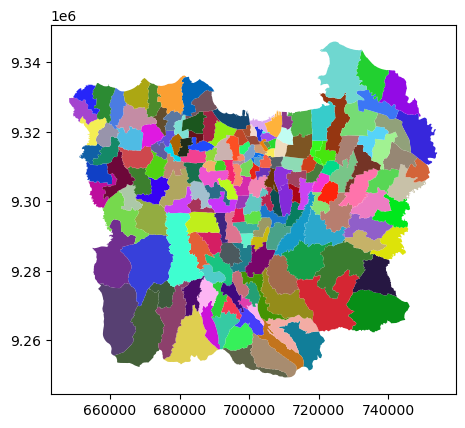

In [73]:
# import the GADM4 level 3 polygons from the shapefile
gadm_file_name = case_city + '_LIM_admin_boundaries_GADM_A.shp'

gadm_path = external_path / gadm_file_name
gadm_gdf_temp = gpd.read_file(gadm_path)

# clip the vectors to the AOI 
gadm_gdf = gadm_gdf_temp.clip(AOI_gdf, keep_geom_type=True)

# convert 'NAME_3' to a sequential number
gadm_gdf[gadm_var] = gadm_gdf[gadm_var].astype('category')
gadm_gdf['NAME_num'] = gadm_gdf[gadm_var].cat.codes
print('The max was', gadm_gdf['NAME_num'].max())

# Change the district with code 0 to one position after the max value.
# we'll use 0 as the NaN value in the urban growth model 
gadm_gdf.loc[gadm_gdf.NAME_num == 0, 'NAME_num'] = gadm_gdf['NAME_num'].max() + 1

print('The max is now', gadm_gdf['NAME_num'].max(),
      '. The values are\n',gadm_gdf['NAME_num'].sort_values().unique())

# plot the clipped vectors with random colours. 
# random colous script from https://www.statology.org/matplotlib-random-color/

var = 'NAME_num'
df = gadm_gdf
df.plot(var, color=np.random.rand(len(df[var]),3), label=var,legend=True)
plt.show()



## rasterize

Unique values [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185] 
Min value 0 , Type: int16
Too many unique values to plot a legend


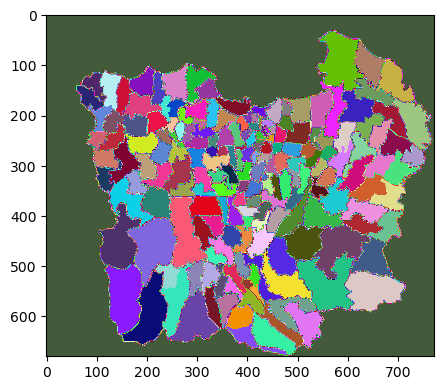

In [79]:
%run ./ti_city_00_raster_functions.ipynb
# rasterize the clipped vectors
varray = rasterise_vector(
    vector=gadm_gdf, 
    ref_raster_path=ref_raster_path, 
    col='NAME_num', 
    default_value=0, 
    dtype=rasterio.int16)

# replace the nodata value with -9999
#varray_9999 = np.where(varray == 0, -9999, varray)

# plot the result
plot_unique_value_raster(varray)
#plot_unique_value_raster(varray_9999)

## export

In [80]:
file_name = case_city + '_LIM_districts_GADM4_150m.tif'

# export to tiff, interim folder
raster_obj = varray
export_path = interim_path/file_name
raster_data_type=rasterio.int16
export_raster(raster_obj,export_path,raster_data_type)

In [82]:
# export to ascii
file_name = case_city + '_LIM_districts_GADM4_150m.asc'

export_path = interim_path/file_name
ref_raster_path=ref_raster_path
raster_data_type=rasterio.int16
export_raster_to_ascii(varray, export_path, ref_raster_path,raster_data_type)

## Copy the rasters to the model inputs folder

In [83]:
file_copy_list = [file_name]

for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_150m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_LIM_districts_GADM4_150m.asc


# 5. Calculate distances to urban facilities

In [3]:
# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

distance_raster_list = []

### Roads

#### fetch roads

Features fetched 389092
Features without duplicates 387528
is_multilinestring
False    386862
Name: count, dtype: int64


<Axes: >

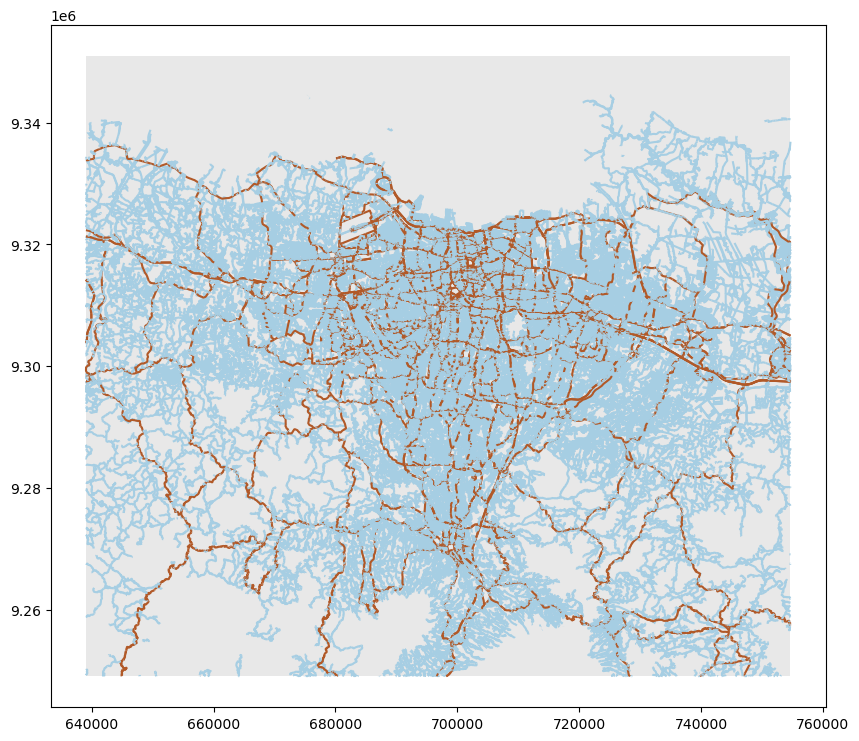

In [ ]:
%run ./ti_city_00_raster_functions.ipynb
# get road LineStrings from OSM
# List key-value pairs for tags
# more info at https://wiki.openstreetmap.org/wiki/Key:highway
tags = {'highway': ['primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'trunk', 'motorway']} 
col_list = ['id','name','source','geometry', 'highway','surface','lanes','incline'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'highway': ['primary', 'secondary','trunk', 'motorway']} # when two keys are provided, the values are combined with an OR operator (i.e., union)
geom_type = 'LineString' # alternatives 'Point', 'LineString', 'Polygon', 'Mixed'

roads = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf) # the funciton converts the CRS to EPSG:4326

# convert the multistring geometries to simple linestrings
def is_multilinestring(geometry):
    return isinstance(geometry, MultiLineString)

roads = roads.explode()
roads['is_multilinestring'] = roads['geometry'].apply(is_multilinestring)
print(roads['is_multilinestring'].value_counts()) # if any MultiLineString remains, check again

roads.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

#### rasterize

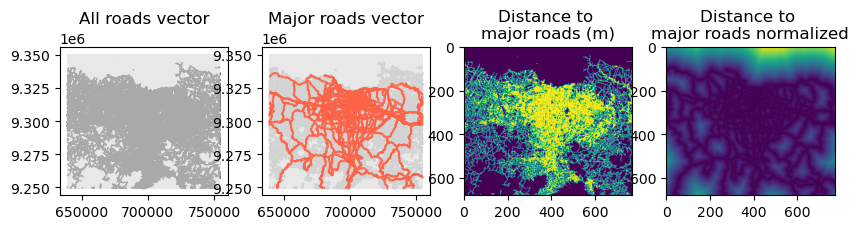

In [ ]:
%run ./ti_city_00_raster_functions.ipynb
roads_major_raster, roads_full_raster, roads_distance_raster, roads_distance_raster_normalized = get_distance_raster(roads, ref_raster_150_path) #ref_raster_path)
#ref_raster_150_path
# Plot the outputs
plot_vec_vec_ras_ras(roads, roads_full_raster, roads_distance_raster_normalized, 'roads')



#### export roads

In [15]:
# export the 150m raster
export_raster(raster=roads_major_raster,
              url = interim_path / (case_city + '_TRA_roads_OSM_2024_major_150m.tif'),
              data_type=rasterio.int16,
              ref_raster_path=ref_raster_150_path)

In [ ]:
# export the 150m raster
export_raster(raster=roads_full_raster,
              url = interim_path / (case_city + '_TRA_roads_OSM_2024_all_150m.tif'),
              data_type=rasterio.int16,
              ref_raster_path=ref_raster_150_path)

In [58]:
%run ./ti_city_00_raster_functions.ipynb
export_roads = True
roads_file_name = ''

if export_roads:
    roads_file_name = case_city + '_TRA_roads_OSM_2025'

    export_files(gdf=roads, 
                major_raster=roads_major_raster, 
                full_raster=None, 
                distance_raster=None, 
                distance_normal=roads_distance_raster_normalized, 
                out_path=interim_path, 
                file_name = roads_file_name)
    #export_files(gdf, major_raster=None, full_raster=None, distance_raster=None, distance_normal=None, out_path=Path('./'), file_name='out_file'): #=interim_path

### do the same for 2000s data

Note: sources on fetching historical OSM  data
- [StackOverflow question (with excellent answer!)](https://gis.stackexchange.com/questions/167690/downloading-historical-openstreetmap-data)
- [Overpass-API docs](https://wiki.openstreetmap.org/wiki/Overpass_API#Quick_Start_(60_seconds):_Interactive_UI)
- [Recent (2 years) StackOverflow discussion with a nice tutorial/solution](https://stackoverflow.com/questions/77964838/is-it-possible-to-get-osm-data-of-streets-from-previous-years)
- [StackOverflow question about OSMnX](https://stackoverflow.com/questions/79671314/osmnx-out-of-memory-if-run-with-ox-setting-overpass-settings-foutjsontimeou)
- [Reddit OSM discussion](https://www.reddit.com/r/openstreetmap/comments/15pw4ws/extracting_historical_data_from_open_street_map/)
- [OSMnX docs](https://osmnx.readthedocs.io/en/latest/index.html) 
- [An issue on OverpassAPI GitHub](https://github.com/drolbr/Overpass-API/issues/755#issuecomment-2996733650)

In [5]:
print(AOI_gdf.crs)

EPSG:32748


In [ ]:
ox.settings.use_cache = False
ox.settings.log_console = True # this does not work in a notebook setting

col_list = ['id','name','source','geometry', 'highway','surface','lanes','incline'] 
poly = AOI_gdf_4326.geometry.values[0] # use to_crs(epsg=4326) if necessary
bbox = (AOI_gdf_4326.bounds.values[0][0], # left
            AOI_gdf_4326.bounds.values[0][1], # old south, now bottom
            AOI_gdf_4326.bounds.values[0][2], # old east, now right
            AOI_gdf_4326.bounds.values[0][3]) # old north, now top

date = "2015-01-01T00:00:00Z"
ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'
ox.settings.requests_timeout=400
# increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
# WARNING: the ox.settings is a global setting and will affect all subsequent queries
ox.settings.overpass_memory = "3G"

# initialize an empty geodataframe
roads_2015 = gpd.GeoDataFrame(columns=col_list)

tag_list = ['trunk', 'motorway', 'primary', 'secondary','tertiary'] # this took 219 min and resulted in an error for the tag 'residential'. The other tags worked fine, though.
#tag_list = ['primary', 'secondary'] # this took 23 min
#tag_list = ['residential', 'unclassified'] # this does not work, there is a timeout error.
for tag in tag_list:
    tags = {'highway': [tag]} # removing because of OSM read-timeout  'trunk', 'motorway', , 'secondary','tertiary', 'residential', 'unclassified',
#features = ox.features_from_polygon(poly, tags)
    single_feature_from_tag = ox.features_from_bbox(bbox=bbox, # old north, now top
                                            tags=tags)
    # append each tag to the features GeoDataFrame
    roads_2015 = pd.concat([roads_2015, single_feature_from_tag], ignore_index=True)
# reset overpass settings to default
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'


roads_2015.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',

AOI Polygon type: <class 'shapely.geometry.polygon.Polygon'>
AOI bounds: (106.25611027851203, -6.791314577241045, 107.30415180293387, -5.866863266313432)


In [ ]:
%run ./ti_city_00_raster_functions.ipynb
major_crit = {'highway': ['primary', 'secondary','trunk', 'motorway']}
geom_type = 'LineString'

temp_places = roads_2015.loc[:, col_list]
temp_places[temp_places['geometry'].type == 'MultiLineString'].explode()
temp_places = temp_places[temp_places['geometry'].type == geom_type]
places = gpd.clip(temp_places, mask=AOI_gdf, keep_geom_type=True)

places['major'] = 0
    # identify major features based on the criteria dictionary
for key, value in major_crit.items():
    places.loc[places[key].isin(value), 'major'] = 1

roads_2015_file_name = case_city + '_TRA_roads_OSM_2015'

export_files(gdf=places, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=None, 
             out_path=interim_path, 
             file_name = roads_2015_file_name)

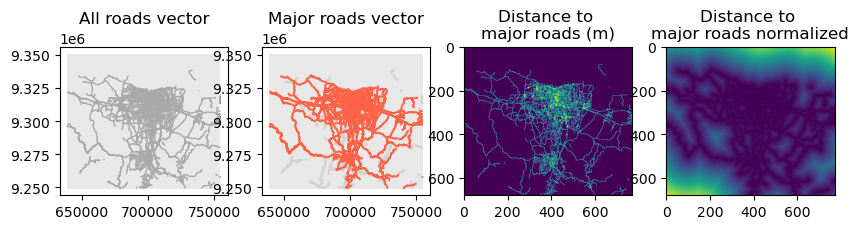

In [9]:
# importing the previously generated shapefile to rasterise it
roads_2015_file_name = case_city + '_TRA_roads_OSM_2015_L.shp'
roads_2015_path = interim_path / roads_2015_file_name
roads_2015_gdf = gpd.read_file(roads_2015_path).to_crs(AOI_gdf.crs)

%run ./ti_city_00_raster_functions.ipynb
roads_2015_major_raster, roads_2015_full_raster, roads_2015_distance_raster, roads_2015_distance_raster_normalized = get_distance_raster(roads_2015_gdf, ref_raster_150_path) #ref_raster_path)
#ref_raster_150_path
# Plot the outputs
plot_vec_vec_ras_ras(roads_2015_gdf, roads_2015_full_raster, roads_2015_distance_raster_normalized, 'roads')




In [11]:
# export the 2015 road data
roads_2015_file_name = case_city + '_TRA_roads_OSM_2015'

export_files(gdf=roads_2015_gdf, 
             major_raster=roads_2015_major_raster, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=roads_2015_distance_raster_normalized, 
             out_path=interim_path, 
             file_name = roads_2015_file_name)

### health facilities

#### fetch health facilities

Features fetched 1165
Features without duplicates 1165


<Axes: >

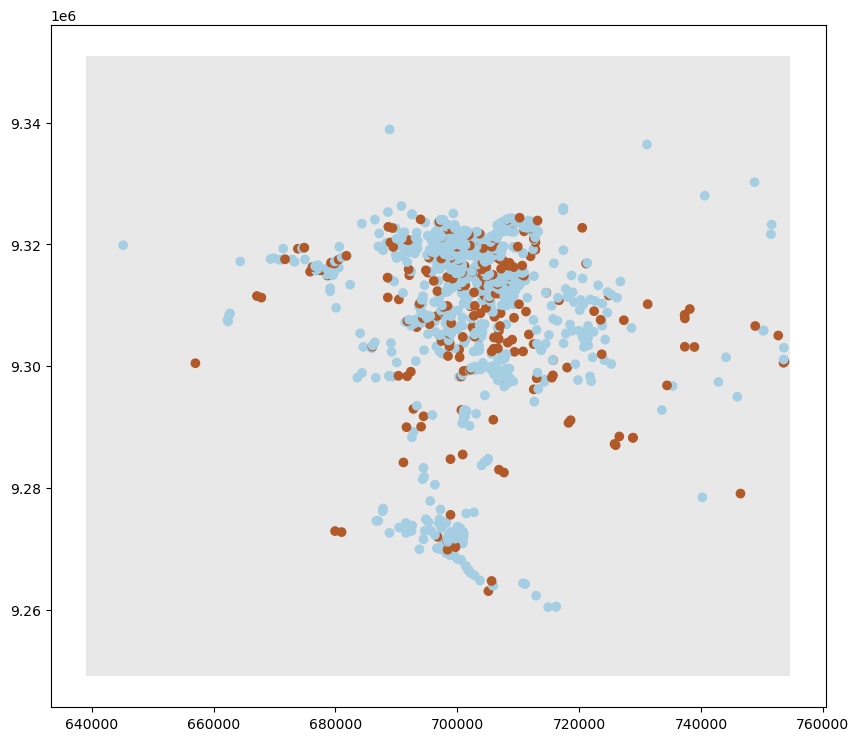

In [4]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'healthcare': ['birthing_centre','centre', 'clinic', 'dentist', 'doctor','hospice','hospital','midwife','rehabilitation','yes'], # see https://wiki.openstreetmap.org/wiki/Key:healthcare for more info
        'amenity':['clinic','doctors','dentist','hospital']}  # see https://wiki.openstreetmap.org/wiki/Key:amenity for more info
col_list = ['id','name','geometry','amenity','healthcare'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',
major_crit = {'healthcare': ['hospital'],'amenity':['hospital']} # when two keys are provided, the values are combined with an OR operator (i.e., union)
geom_type = 'Point'

health = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

health.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

#### rasterize health

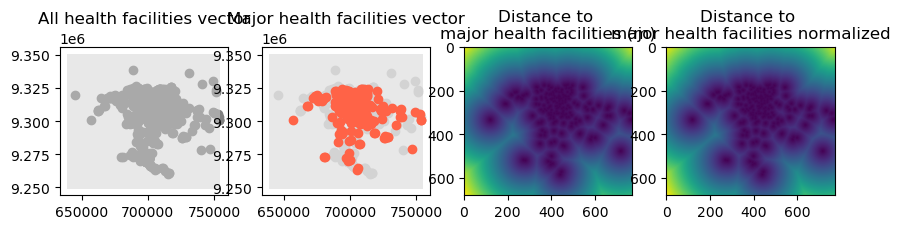

In [5]:
# rasterize and calculate Euclidian distances
health_major_raster, health_full_raster, health_distance_raster, health_dist_normalized = get_distance_raster(health, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(health, health_distance_raster, health_dist_normalized, 'health facilities')



#### export health facilities

In [32]:
health_file_name = case_city + '_LOC_health_OSM_2025'

export_files(gdf=health, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=health_dist_normalized, 
             out_path=interim_path, 
             file_name = health_file_name)

#### 2015 data

In [30]:
def get_osm_attic_features(aoi, tag_dict, date, geom_type, major_dict, col_list):
    ox.settings.use_cache = False
    ox.settings.log_console = True # this does not work in a notebook setting

    if aoi.crs != 'EPSG:4326':
        aoi = aoi.to_crs(epsg=4326) 
    bbox = (aoi.bounds.values[0][0], # left
                aoi.bounds.values[0][1], # old south, now bottom
                aoi.bounds.values[0][2], # old east, now right
                aoi.bounds.values[0][3]) # old north, now top

    date = date
    ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'
    ox.settings.requests_timeout=720
    # increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
    # WARNING: the ox.settings is a global setting and will affect all subsequent queries
    ox.settings.overpass_memory = "3G"

    # initialize an empty geodataframe
    temp_places = gpd.GeoDataFrame(columns=col_list, crs='EPSG:4326')

    
    for key, values in tag_dict.items():
        print(key, values)
        #print(type(values), values)
        tag_list = values
        for tag in range(len(tag_list)):
            print('Fetching', tag_list[tag])
            tags = {key: tag_list[tag]}
            print(tags)
            try:
                single_feature_from_tag = ox.features_from_bbox(bbox=bbox, # old north, now top
                                                        tags=tags)
                # append each tag to the features GeoDataFrame
                temp_places = pd.concat([temp_places, single_feature_from_tag], ignore_index=True)
            except Exception as e:
                print(f"Error retrieving data for tag '{tag}': {e}")
        
        # reset overpass settings to default
        ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'
        geom_list = []

        for feature in temp_places["geometry"]:
                if isinstance(feature, Polygon):
                        geom_list.append('Polygon')
                else:
                        geom_list.append('Point')
        
        if (geom_type == 'Mixed') & ('Polygon' in geom_list) & ('Point' in geom_list): # I am not sure we need this. Perhaps leave only the "catch all" conversion to points as the default
            temp_places["geometry"] = temp_places.centroid 
            temp_places = temp_places.loc[:, col_list]
            #temp_places.drop_duplicates('osmid',inplace=True)
            print('Attention: Mixed geometry types found, will be converted to points')
        elif (geom_type == 'Mixed'):
            print(temp_places["geometry"].type.unique())
            temp_places["geometry"] = temp_places.centroid 
            temp_places = temp_places.loc[:, col_list]
            print('Attention: Mixed geometry types found, only centroids will be fetched')
        else: 
            temp_places = temp_places.loc[(temp_places.geometry.type==geom_type), col_list]
        
        print('Features fetched',temp_places.shape[0])
        temp_places.reset_index(inplace=True)
        # filtering out the repeated entries
        temp_places.drop_duplicates('id', inplace=True) # the calls to drop_duplicates are separate to avoid getting the union of all conditions
        temp_places.drop_duplicates('geometry', inplace=True) # 
        temp_places.loc[temp_places['name'].notnull(),:].drop_duplicates('name', inplace=True) # 
        
        print('Features without duplicates',temp_places.shape[0])
        #convert the CRS of roads to the same as AOI
        temp_places.to_crs(aoi.crs,inplace=True)
        
        # clip features to the AOI
        places = gpd.clip(temp_places, mask=aoi, keep_geom_type=True)
        
        places['major'] = 0
        
        # identify major features based on the criteria dictionary
        for key, value in major_dict.items():
            places.loc[places[key].isin(value), 'major'] = 1
            
        return places

tags = {'healthcare': ['birthing_centre','centre', 'clinic', 'dentist', 'doctor','hospice','hospital','midwife','rehabilitation','yes'], # see https://wiki.openstreetmap.org/wiki/Key:healthcare for more info
        'amenity':['clinic','doctors','dentist','hospital']}  # see https://wiki.openstreetmap.org/wiki/Key:amenity for more info
col_list = ['id','name','geometry','amenity','healthcare'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',
major_crit = {'healthcare': ['hospital'],'amenity':['hospital']} # when two keys are provided, the values are combined with an OR operator (i.e., union)
geom_type = 'Point'
date = "2015-01-01T00:00:00Z"

health_2015 = get_osm_attic_features(
     aoi = AOI_gdf, 
     tag_dict = tags, 
     date = date, 
     geom_type = geom_type, 
     major_dict = major_crit, 
     col_list = col_list)

#health_2015.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',

healthcare ['birthing_centre', 'centre', 'clinic', 'dentist', 'doctor', 'hospice', 'hospital', 'midwife', 'rehabilitation', 'yes']
Fetching birthing_centre
{'healthcare': 'birthing_centre'}
Error retrieving data for tag '0': No matching features. Check query location, tags, and log.
Fetching centre
{'healthcare': 'centre'}
Error retrieving data for tag '1': No matching features. Check query location, tags, and log.
Fetching clinic
{'healthcare': 'clinic'}
Error retrieving data for tag '2': No matching features. Check query location, tags, and log.
Fetching dentist
{'healthcare': 'dentist'}
Error retrieving data for tag '3': No matching features. Check query location, tags, and log.
Fetching doctor
{'healthcare': 'doctor'}
Error retrieving data for tag '4': No matching features. Check query location, tags, and log.
Fetching hospice
{'healthcare': 'hospice'}
Error retrieving data for tag '5': No matching features. Check query location, tags, and log.
Fetching hospital
{'healthcare': 'hos

#### Distance cost function

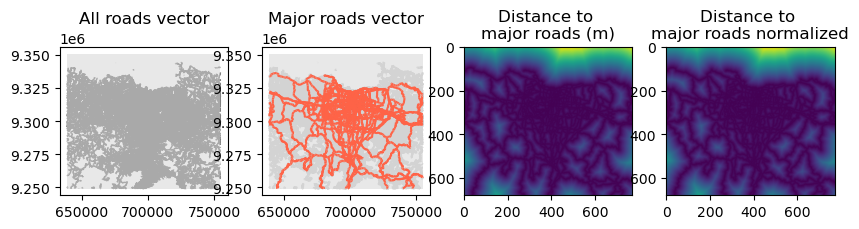

In [9]:
# rasterize roads with 150 m resolution
%run ./ti_city_00_raster_functions.ipynb
roads_major_raster_150, roads_full_raster_150, roads_distance_raster_150, roads_distance_raster_normalized_150 = get_distance_raster(roads, ref_raster_150_path)

# Plot the outputs
plot_vec_vec_ras_ras(roads, roads_distance_raster_150, roads_distance_raster_normalized_150, 'roads')



In [10]:
# calculate the cost raster
# we'll add the slope, landuse classes (urban = 1, vegetated =2, and forest 4, each with a weight)
"""Calculate accumulated cost raster using slope, land use, waterbodies, and road network

    Args:
        roads_full_raster: Pre-calculated raster of road network, paved=1, unpaved=2, and no road=10
        landuse_raster: Pre-calculated raster of land use, urban=1, vegetated=2, and forest=4
        slope_raster_path: Path to slope raster file, in percent
        riverbeds_raster: Pre-calculated raster of riverbeds (100 m buffer around rivers)
        

        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)

    Returns:
        Accumulated cost raster and normalized accumulated cost raster
    """

'Calculate accumulated cost raster using slope, land use, waterbodies, and road network\n\n    Args:\n        roads_full_raster: Pre-calculated raster of road network, paved=1, unpaved=2, and no road=10\n        landuse_raster: Pre-calculated raster of land use, urban=1, vegetated=2, and forest=4\n        slope_raster_path: Path to slope raster file, in percent\n        riverbeds_raster: Pre-calculated raster of riverbeds (100 m buffer around rivers)\n        \n\n        ref_raster_path: Path to reference raster for alignment\n        wt_roads: Weight for road cells (default=1)\n        wt_no_roads: Weight for non-road cells (default=100)\n        wt_slope: Weight multiplier for slope influence (default=1)\n\n    Returns:\n        Accumulated cost raster and normalized accumulated cost raster\n    '

In [11]:
%run ./ti_city_00_raster_functions.ipynb

raster_file=case_city + '_DEM_slope_pct_TanDEM_X_150m.tif'
slope_raster_path = model_inputs_150m_path / raster_file

acc_cost, acc_norm_cost = get_weight_distance_raster(path_raster=roads_full_raster_150,
                                                       gdf_origin_points=health[health.major == 1], 
                                                       slope_raster_path=slope_raster_path,
                                                       ref_raster_path=ref_raster_150_path,
                                                       wt_roads=1, wt_no_roads=100, wt_slope=1)	

# Plot the outputs
plot_continuous_raster(acc_norm_cost, title='Accumulated cost raster')

RasterioIOError: D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_DEM_slope_pct_TanDEM_X_150m.tif: No such file or directory

(1078, 846)
Min value: 0.0 , Max value: 361671.0551403034


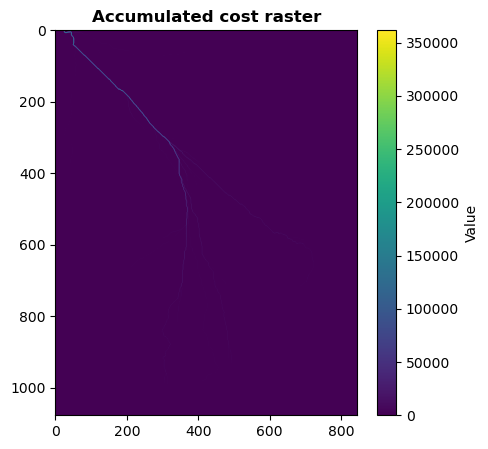

In [ ]:
print(acc_cost.shape)
plot_continuous_raster(acc_cost, title='Accumulated cost raster')

In [ ]:
# export to tiff
file_name = case_city + '_LOC_acc_cost_distance_health_30m.tif'

with rasterio.open(ref_raster_150_path, 'r') as ref_raster:
    export_geotiff(
        raster= acc_cost, 
        out_transform = ref_raster.transform,
        out_meta = ref_raster.meta,
        export_path = interim_path / file_name,
        data_type = rasterio.float32)

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_LOC_acc_cost_distance_health_30m.tif


In [ ]:
#run ./ti_city_00_raster_functions.ipynb

origin_points = health[health.major == 1]
raster_file = case_city + '_DEM_slope_deg_TanDEM_X_30m.tif'
slope_raster_path = processed_path / raster_file

healht_cost_distance_raster, healht_cost_dist_raster_norm = get_weight_distance_raster_6(path_raster=roads_full_raster, 
                                                                                                 slope_raster_path = slope_raster_path,
                                                                                                 gdf_origin_points = origin_points, 
                                                                                                 ref_raster_path=ref_raster_path, 
                                                                                                 wt_roads=1, 
                                                                                                 wt_no_roads=100)

slope: (4235, 2975)
slope normal: (4235, 2975)
path (4235, 2975)
origin: (4235, 2975)
cost: (4235, 2975)
origin length 1564 , 
origin first index: (28, 1451) , 
origin last index: (4106, 1811) , 
origin type <class 'tuple'>
densest_point: (0, 302)
empty cost raster: (4235, 2975)
Error in function: start points must all be within the costs array


In [ ]:
healht_cost_dist_raster_norm.show()

AttributeError: 'NoneType' object has no attribute 'show'

AttributeError: 'NoneType' object has no attribute 'ndim'

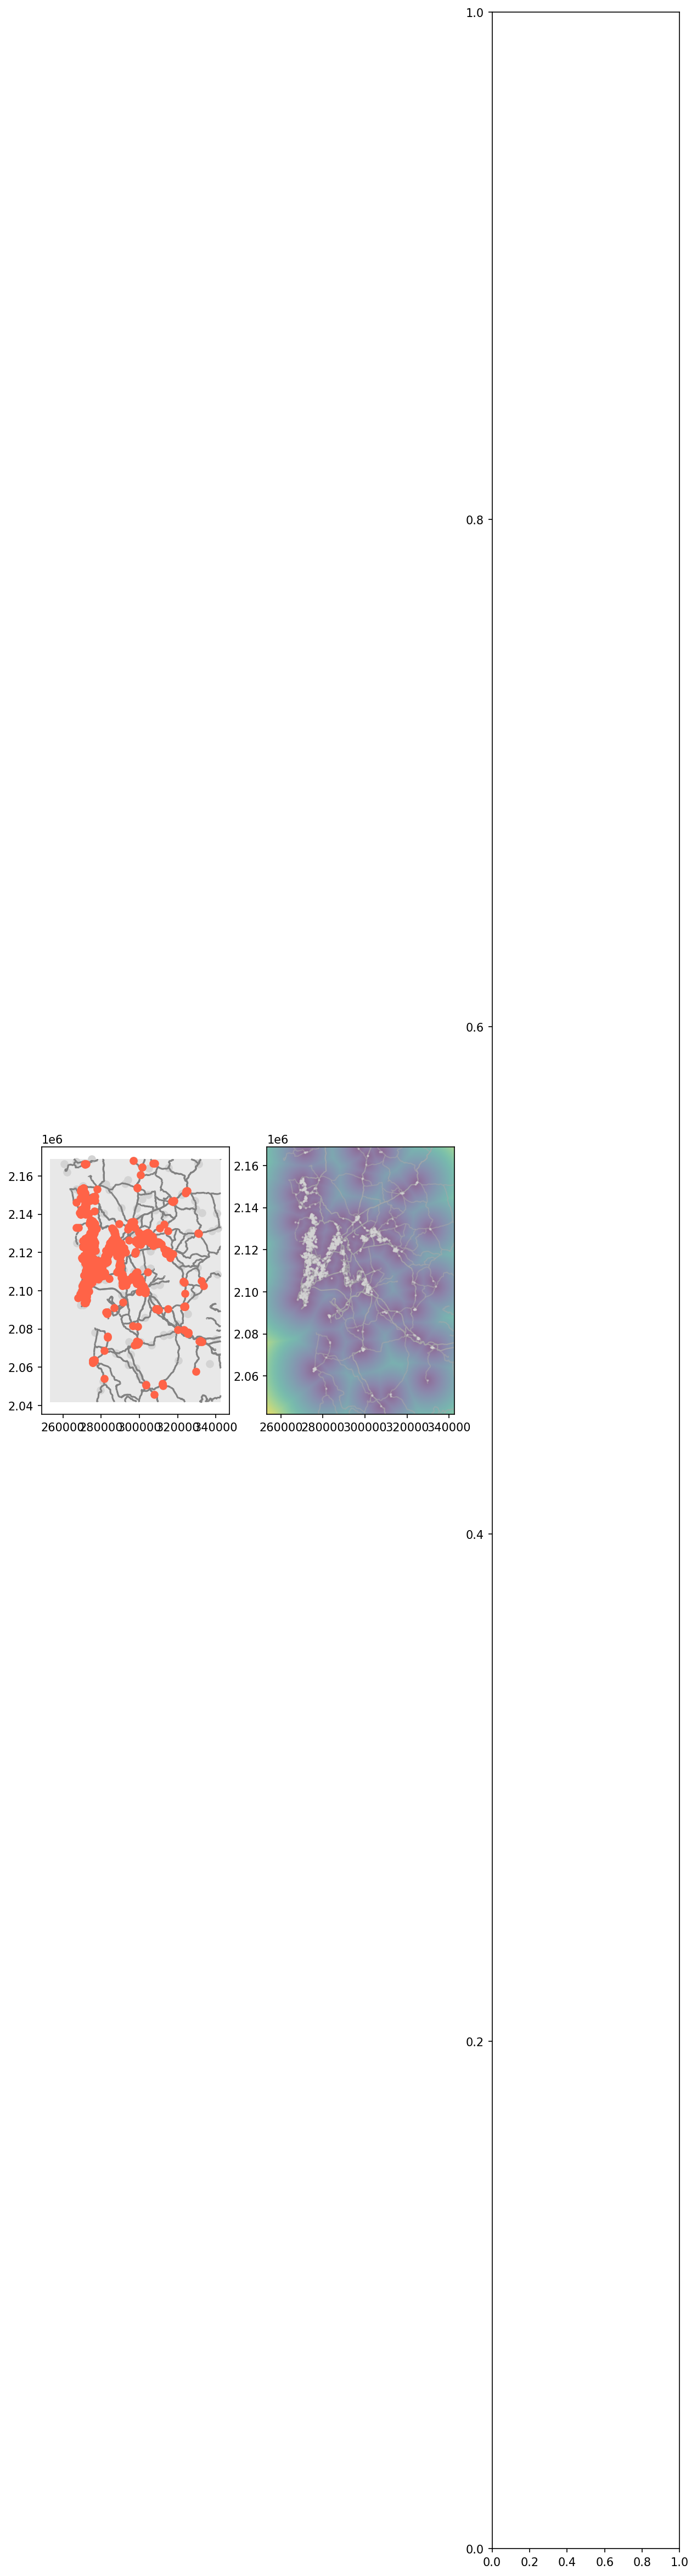

In [ ]:
plot_compare_rasters(vector = health, 
                     roads_vector = roads, 
                     dist_raster = health_dist_normalized, 
                     norm_raster = healht_cost_dist_raster_norm, 
                     title = 'health',
                     AOI_gdf = AOI_gdf,
                     ref_raster_path = ref_raster_path)

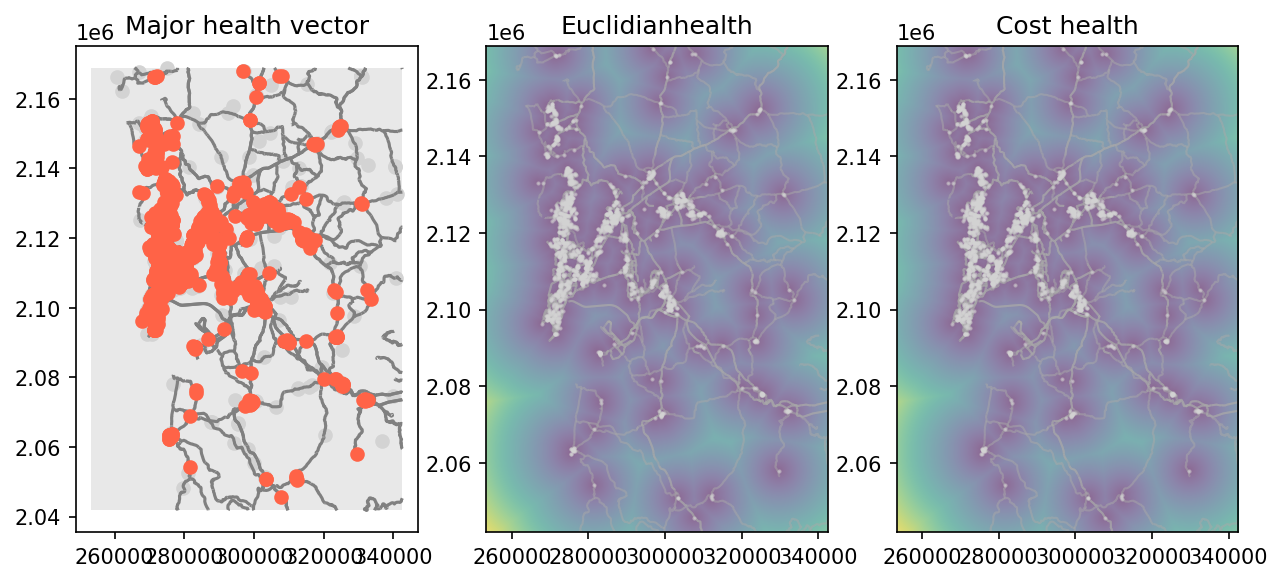

In [ ]:

print(health.crs, roads.crs)
with rasterio.open(ref_raster_path) as src:
    plot_transform = src.transform
print(plot_transform)
plot_extent = plotting_extent(health_dist_normalized, plot_transform)


EPSG:32643 EPSG:32643
| 30.00, 0.00, 253336.35|
| 0.00,-30.00, 2168881.02|
| 0.00, 0.00, 1.00|


In [ ]:
%run ./ti_city_00_raster_functions.ipynb


### schools

#### fetch schools

Features fetched 1609
Features without duplicates 1609


<Axes: >

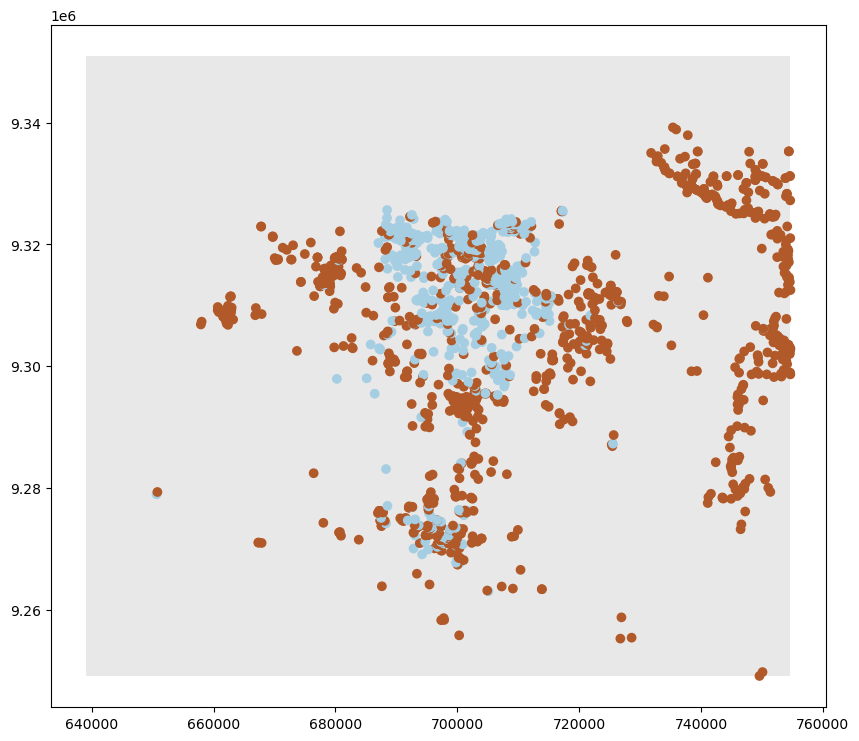

In [16]:
# get schools points from OSM
# List key-value pairs for tags
tags = {'amenity': ['kindergarten','college', 'university', 'school','language_school','music_school','dancing_school','prep_school','training']} # see https://wiki.openstreetmap.org/wiki/Tag:amenity=school for more info
col_list = ['id','name','geometry','amenity', 'isced:level'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',
major_crit = {'amenity': ['college', 'university', 'school']}
geom_type = 'Point'

schools = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
schools.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

#### rasterize

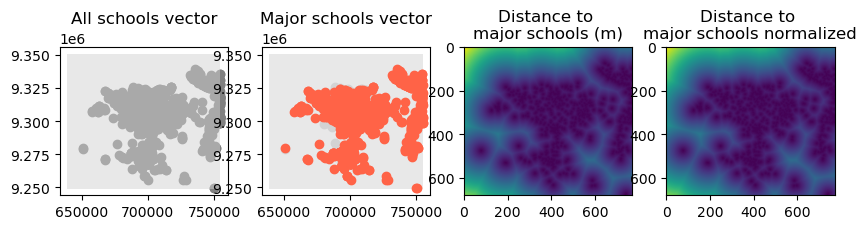

In [18]:
# rasterize and calculate distances
schools_major_raster, schools_full_raster, schools_distance_raster, schools_dist_normalized = get_distance_raster(schools, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(schools, schools_distance_raster, schools_dist_normalized, 'schools')

#### export schools

In [31]:
schools_file_name = case_city + '_LOC_schools_OSM_2025'

export_files(gdf=schools, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=schools_dist_normalized, 
             out_path=interim_path, 
             file_name = schools_file_name)

### suburban_centres

#### fetch suburban_centres

Features fetched 1981
Features without duplicates 1981


<Axes: >

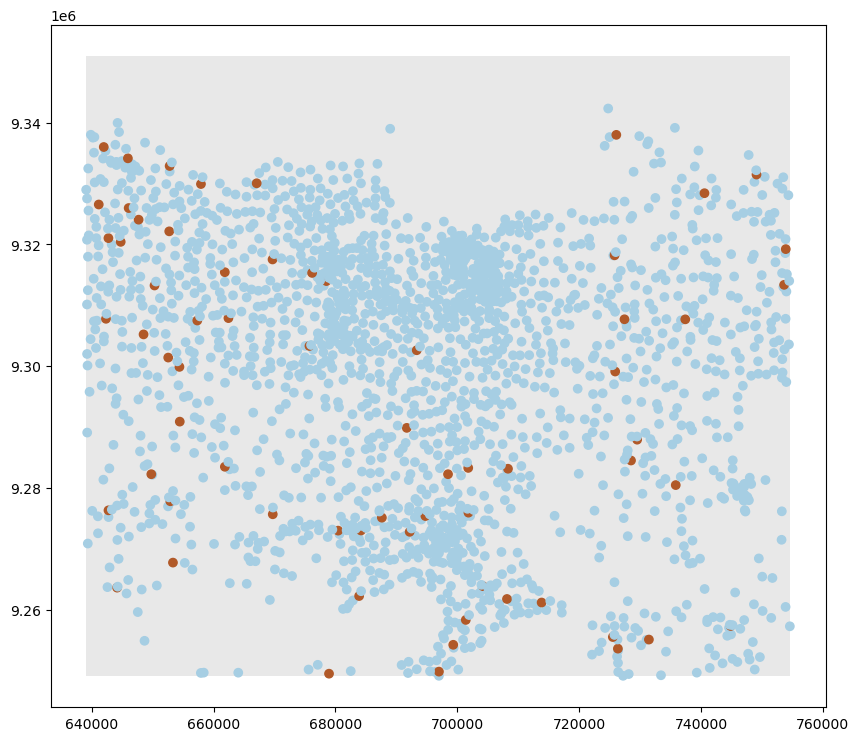

In [21]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'place': ['town', 'village', 'hamlet']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info, #'city',
col_list = ['id','name','geometry', 'place','population'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'place':['town']} # other candidates'village', 'hamlet'
geom_type = 'Point'

suburbs = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

#plot them
suburbs.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

#### rasterize

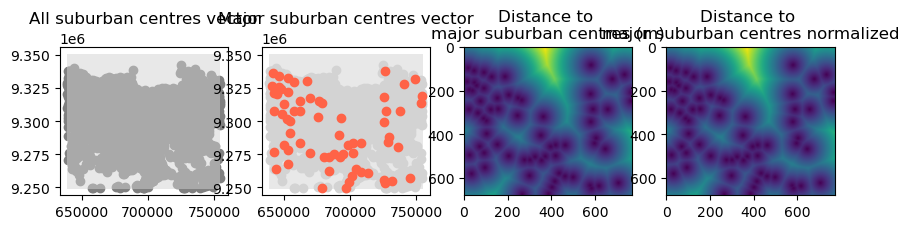

In [22]:
# rasterize and calculate distances
suburbs_major_raster, suburbs_full_raster, suburbs_distance_raster, suburbs_dist_normalized = get_distance_raster(suburbs, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(suburbs, suburbs_distance_raster, suburbs_dist_normalized, 'suburban centres')

#### export suburban_centres

In [23]:
suburban_file_name = case_city + '_LOC_suburban_centres_OSM_2025'

export_files(gdf=suburbs, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=suburbs_dist_normalized, 
             out_path=interim_path, 
             file_name = suburban_file_name)

### shopping_malls

#### fetch shopping_malls

Features fetched 91
Features without duplicates 91


<Axes: >

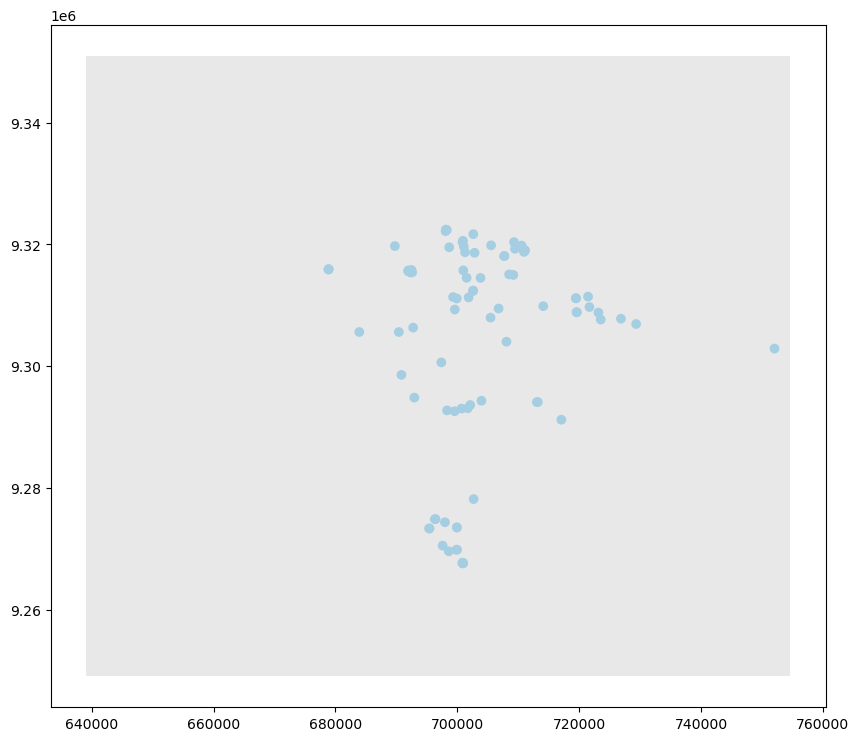

In [24]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'shop': ['mall']} # see https://wiki.openstreetmap.org/wiki/Tag:shop%3Dmall for more info, #'city',
col_list = ['id','name','geometry','shop'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'shop':['mall']}
geometry_type = 'Mixed'

malls = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

malls.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

#### rasterize

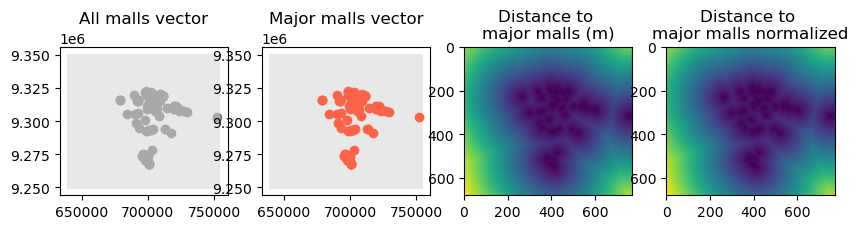

In [25]:
# rasterize and calculate distances
malls_major_raster, malls_full_raster, malls_distance_raster, malls_dist_normalized = get_distance_raster(malls, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(malls, malls_distance_raster, malls_dist_normalized, 'malls')

#### export shopping_malls

In [30]:
malls_file_name = case_city + '_LOC_malls_OSM_2025'

export_files(gdf=malls, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=malls_dist_normalized, 
             out_path=interim_path, 
             file_name = malls_file_name)

### markets

#### fetch markets

Attention: Mixed geometry types found, will be converted to points
Features fetched 467
Features without duplicates 463


<Axes: >

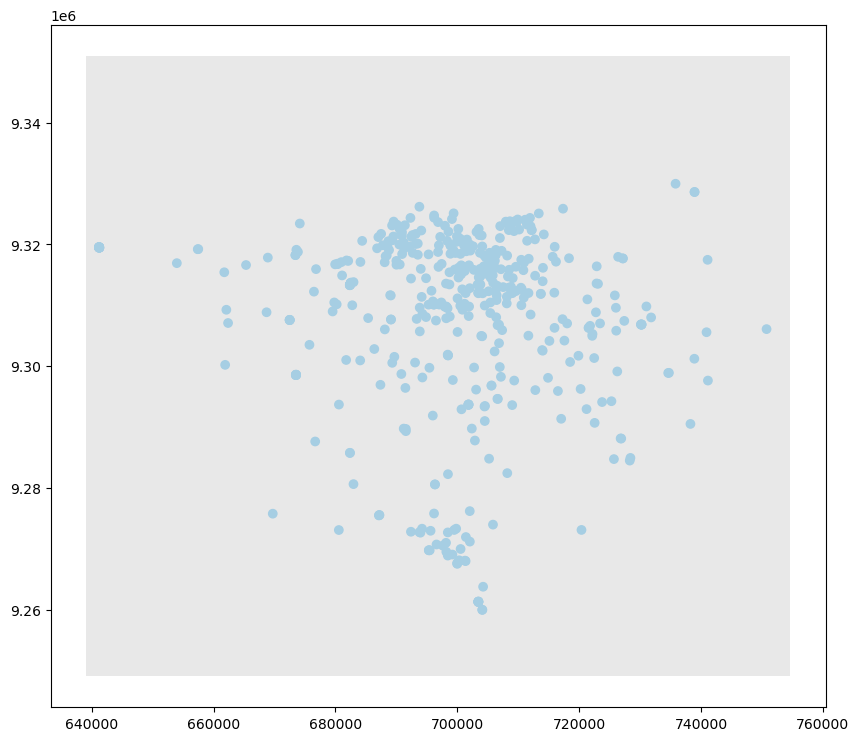

In [27]:
# get health facility points from OSM
# List key-value pairs for tags
tags = {'amenity': ['marketplace']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info, #'city',
col_list = ['id','name','geometry','amenity'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'amenity':['marketplace']} 
geom_type = 'Mixed'

markets = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)

#plot them
markets.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

#### rasterize

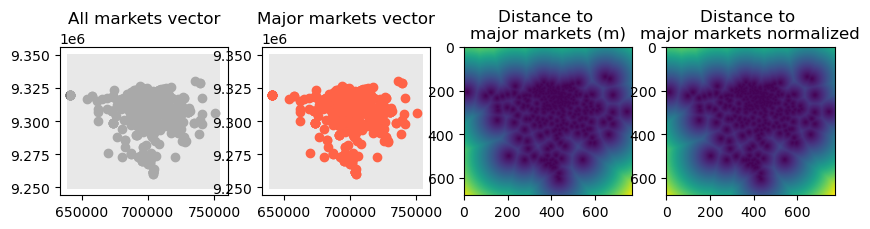

In [28]:
# rasterize and calculate distances
markets_major_raster, markets_full_raster, markets_distance_raster, markets_dist_normalized = get_distance_raster(markets, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(markets, markets_distance_raster, markets_dist_normalized, 'markets')

#### export markets

In [29]:
markets_file_name = case_city + '_LOC_markets_OSM_2025'

export_files(gdf=markets, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=markets_dist_normalized, 
             out_path=interim_path, 
             file_name = markets_file_name)

### airport

#### fetch airport

In [ ]:
%run ./ti_city_00_raster_functions.ipynb

Attention: Mixed geometry types found, will be converted to points
Features fetched 10
Features without duplicates 10


<Axes: >

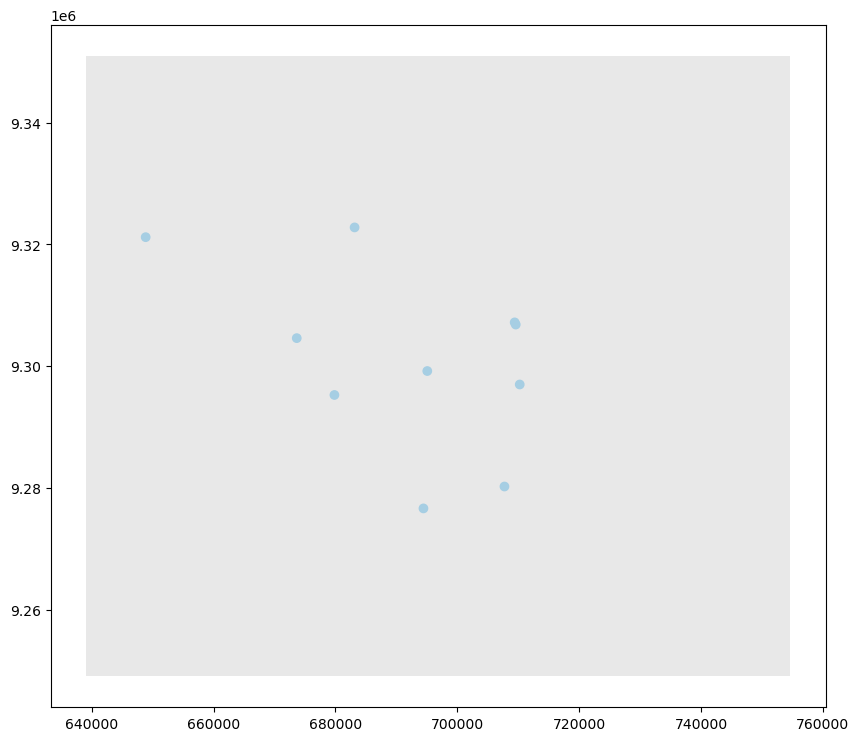

In [33]:
tags = {'aeroway': ['aerodrome','airstrip']} # see https://wiki.openstreetmap.org/wiki/Tag:aeroway%3Daerodrome for more info
col_list = ['id','name','geometry','aeroway','aerodrome:type'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
major_crit = {'aeroway': ['aerodrome']} 
geometry_type = 'Mixed'

airports = get_osm_features(tags, col_list, geometry_type, major_crit, AOI_gdf)

#plot them
airports.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) 

#### rasterize

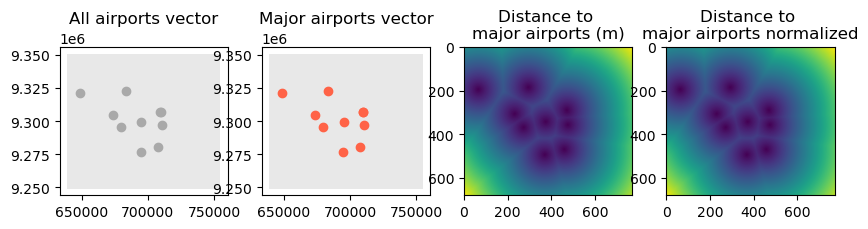

In [34]:
# rasterize and calculate distances
airports_major_raster, airports_full_raster, airports_distance_raster, airports_dist_normalized = get_distance_raster(airports, ref_raster_path)
# Plot the outputs
plot_vec_vec_ras_ras(airports, airports_distance_raster, airports_dist_normalized, 'airports')


#### export airport

In [35]:
airport_file_name = case_city + '_LOC_airports_OSM_2025'

export_files(gdf=airports, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=airports_dist_normalized, 
             out_path=interim_path, 
             file_name = airport_file_name)

### cbd

#### fetch cbd

In [45]:
## ATTENTION: there is no standardised definition of OSM tags for CBDs. We need to define for each case.

# get CBD points from OSM
# List key-value pairs for tags
tags = {'landuse': ['commercial','retail','industrial']} # see https://wiki.openstreetmap.org/wiki/Key:landuse for more info,
col_list = ['id','name','geometry','landuse'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
# finding the CBDs is tricky as there is no official tag for it in OSM
# hence, we define a ad hoc list of OSM names for the areas that we consider as CBDs

if case_city == 'MUM':
    # source: https://www.99acres.com/articles/the-cbds-in-Mumbai.html) and validated locally.
    name_list = ['CBD Belapur East','One BKC','Lodha Supremus','Peninsula Business Park','Tata Consultancy Services - TCS']  # other candidates: 'CIDCO Office - Kharghar', 
if case_city == 'MAN':
    # source: https://santosknightfrank.com/blogs/top-central-business-districts-in-metro-manila/) and validated locally.
    # source: https://weavergroup.ph/central-business-districts-an-overview-of-the-commercial-real-estate-in-metro-manila/ 
    name_list = ['BDO Corporate Center','Seda BGC','Metrobank Plaza',
                 'SM Mall of Asia','Filinvest Corporate City Marketing Office & Exhibit Center','Araneta City']
if case_city == 'JAK':
    # source: https://www.99acres.com/articles/central-business-districts-in-jakarta/) and validated locally.
    # source: https://www.flokq.com/blog/en/cbd-the-golden-triangle
    name_list = ['18 Parc Place','Mega Kuningan','Epiwalk Rasuna Epicentrum','Thamrin Nine']

major_crit = {'name': name_list} 
geom_type = 'Mixed'

cbd = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
cbd_selected = cbd.loc[cbd.name.isin(name_list),:]

print('++++++++++++++++++++++++++++++++++++++++++++++++\n',len(name_list), len(cbd_selected))
for i in name_list:
    print(i)
cbd_selected

Attention: Mixed geometry types found, will be converted to points
Features fetched 3763
Features without duplicates 3694
++++++++++++++++++++++++++++++++++++++++++++++++
 4 4
18 Parc Place
Mega Kuningan
Epiwalk Rasuna Epicentrum
Thamrin Nine


id                       name                        geometry  \
3191  1244589761              18 Parc Place  POINT (700284.841 9311045.318)   
2711   755299424              Mega Kuningan  POINT (701999.465 9311122.202)   
69      17448024  Epiwalk Rasuna Epicentrum   POINT (703034.463 9312401.91)   
968    482904038               Thamrin Nine  POINT (701487.673 9314503.097)   

         landuse  major  
3191  commercial      1  
2711  commercial      1  
69        retail      1  
968   commercial      1

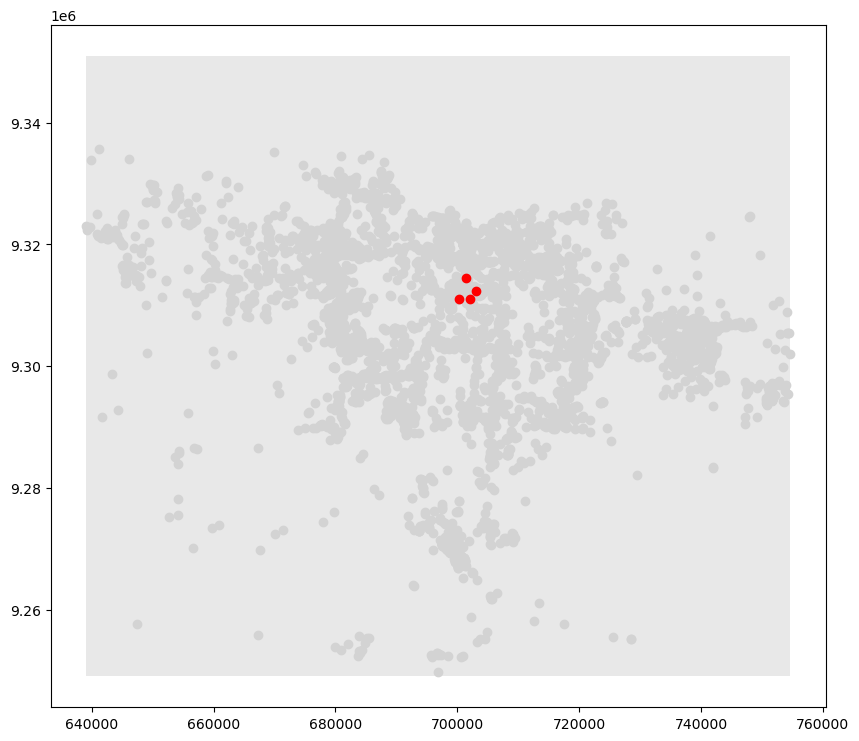

In [46]:
#plot them
f = plt.figure(figsize=(10, 10))
ax=f.add_subplot(111)

#cbd.loc[(cbd.major==1),:].plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', zorder=1)
ax.plot(cbd.centroid.x,cbd.centroid.y,'o',color='lightgrey', marker='o', zorder=2) #cmap='Paired',
AOI_gdf.plot(ax=ax,  alpha=0.5, color='lightgray', zorder=1)
ax.plot(cbd_selected.centroid.x,cbd_selected.centroid.y, 'ro', zorder=3)
plt.show()

#### rasterize

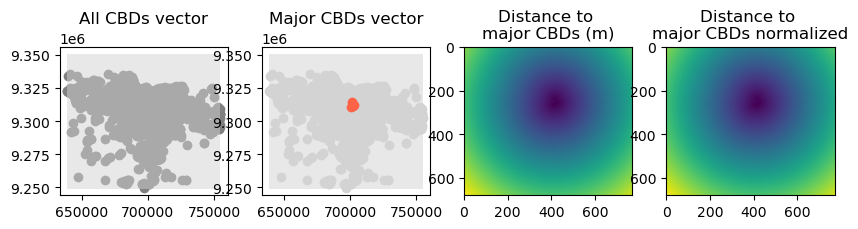

In [48]:
# rasterize and calculate distances
cbd_major_raster, cbd_full_raster, cbd_distance_raster, cbd_dist_normalized = get_distance_raster(cbd, ref_raster_path)

# Plot the outputs
plot_vec_vec_ras_ras(cbd, cbd_distance_raster, cbd_dist_normalized, 'CBDs')


#### export cbd

In [49]:
cbd_file_name = case_city + '_LOC_CBDs_OSM_2025'

export_files(gdf=cbd, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=cbd_dist_normalized, #
             out_path=interim_path, 
             file_name = cbd_file_name)

## Copy all the distance rasters to the model input folder

In [57]:
raster_list = [roads_file_name + '_distance_normal_150m.tif', 
               roads_file_name + '_major_150m.tif',
               health_file_name + '_distance_normal_150m.tif', 
               schools_file_name + '_distance_normal_150m.tif', 
               suburban_file_name + '_distance_normal_150m.tif', 
               malls_file_name + '_distance_normal_150m.tif', 
               markets_file_name + '_distance_normal_150m.tif', 
               airport_file_name + '_distance_normal_150m.tif', 
               cbd_file_name + '_distance_normal_150m.tif']

for file in raster_list:
    file_name = file 
    origin_path = interim_path / file_name
    destination_path = model_inputs_150m_path / file_name
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\JAK_TRA_roads_OSM_2025_distance_normal_150m.tif'

# Cost-distance function

In [51]:
import osmnx as ox
import pandas as pd
ox.settings.log_console = True

tags = {
    'landuse': ['forest', 'meadow', 'grass', 'allotments', 'recreation_ground', 'village_green', 'cemetery',
                'orchard', 'vineyard', 'plant_nursery', 'farmland', 'farmyard', 'farm', 'grassland', 'greenfield'], 
    'natural': ['wood', 'tree', 'scrub', 'heath', 'moor', 'grassland', 'fell', 'bare_rock', 'scree', 'shingle'],
    'leisure': ['park', 'garden', 'golf_course', 'playground', 'sports_centre', 'stadium', 'pitch', 'recreation_ground', 
                'common', 'village_green', 'dog_park', 'nature_reserve', 'wildlife_hide', 'bird_hide'],
    'tourism':['camp_site'],
    'boundary': ['national_park', 'protected_area']}

gdf = ox.features.features_from_place("Long Beach, CA, USA", tags=tags)

#### Greens

Features fetched 26059
Features without duplicates 25644
Unique values [0 2 3] 
Min value 0 , Type: int16


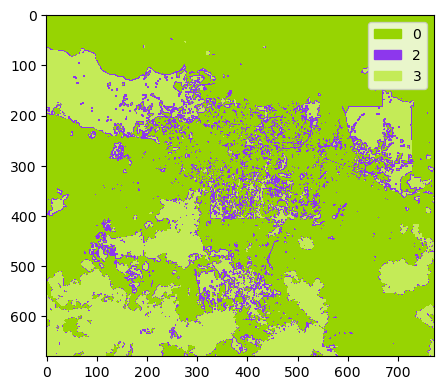

In [52]:
# see https://wiki.openstreetmap.org/wiki/Key:landuse 
# see https://wiki.openstreetmap.org/wiki/Key:natural
# see https://wiki.openstreetmap.org/wiki/Key:leisure
# see https://wiki.openstreetmap.org/wiki/Key:tourism
# see https://wiki.openstreetmap.org/wiki/Key:boundary

tags = {
    'landuse': ['forest', 'meadow', 'grass', 'allotments', 'recreation_ground', 'village_green', 'cemetery',
                'orchard', 'vineyard', 'plant_nursery', 'farmland', 'farmyard', 'farm', 'grassland', 'greenfield'], 
    'natural': ['wood', 'tree', 'scrub', 'heath', 'moor', 'grassland', 'fell', 'bare_rock', 'scree', 'shingle'],
    'leisure': ['park', 'garden', 'golf_course', 'playground', 'sports_centre', 'stadium', 'pitch', 'recreation_ground', 
                'common', 'village_green', 'dog_park', 'nature_reserve', 'wildlife_hide', 'bird_hide'],
    'tourism':['camp_site'],
    'boundary': ['national_park', 'protected_area']}

# get green areas from OSM
# List key-value pairs for tags

col_list = ['id','geometry','name', 'landuse', 'natural','leisure','tourism','boundary'] #OSM has hundreds of cols, we just want a few. For info, check 
major_crit = {
    'landuse': ['forest'], 
    'natural': ['wood', 'tree' 'heath', 'moor'],
    'leisure': ['nature_reserve', 'wildlife_hide'],
    'boundary': ['national_park', 'protected_area']}
geom_type = 'Polygon'

greens = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
#greens.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

greens['major'] = greens['major'] + 2
# rasterize the green areas
greens_raster = rasterise_vector(
    vector = greens, 
    ref_raster_path = ref_raster_150_path, 
    col='major', 
    default_value=1, 
    dtype=rasterio.int16)
plot_unique_value_raster(greens_raster)



#### Urban

In [53]:
# import the urban areas raster
urban_file = case_city + '_URB_urbanisation_2015_EOC_WUF_150m.tif'
urban_path = model_inputs_150m_path / urban_file

with rasterio.open(urban_path) as src:
    urban = src.read(1)
    urban_meta = src.meta

urban = np.where(urban == 1,-1, 0)
plot_unique_value_raster(urban)

RasterioIOError: D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\JAK\model_inputs\TIFF_150m\JAK_URB_urbanisation_2015_EOC_WUF_150m.tif: No such file or directory

#### Roads

Unique values [-1  0] 
Min value -1 , Type: int32


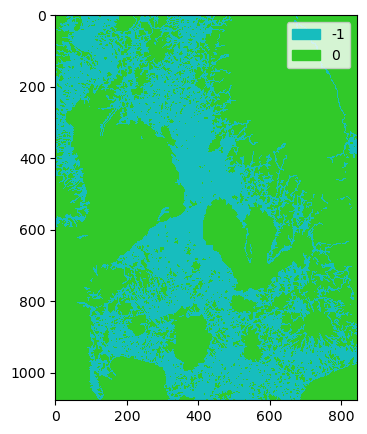

In [ ]:
roads_cost_vector = roads.loc[:,['major','geometry']].copy()
roads_cost_vector['major'] = roads_cost_vector['major'] + 1
# roads_cost_vector.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

# add a 100 m buffer to the roads
roads_cost_vector['geometry'] = roads_cost_vector.buffer(100)
roads_cost_raster_minor = rasterise_vector(
    vector = roads_cost_vector.loc[roads_cost_vector.major == 1], 
    ref_raster_path = ref_raster_150_path, 
    col='major', 
    default_value=None, 
    dtype=rasterio.int16)
roads_cost_raster_minor = np.where(roads_cost_raster_minor == 1, -1, 0)
plot_unique_value_raster(roads_cost_raster_minor)

Unique values [-2  0] 
Min value -2 , Type: int32


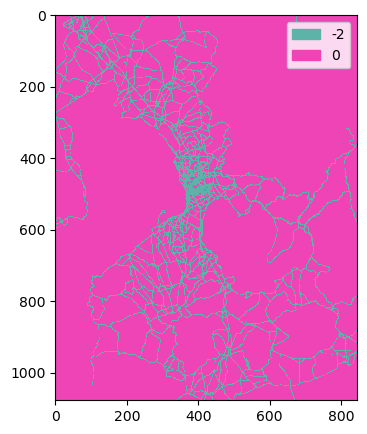

In [ ]:
# rasterise the major roads separately
roads_cost_raster_major = rasterise_vector(
    vector = roads_cost_vector.loc[roads_cost_vector.major == 2], 
    ref_raster_path = ref_raster_150_path, 
    col='major', 
    default_value=None, 
    dtype=rasterio.int16)
roads_cost_raster_major = np.where(roads_cost_raster_major == 2, -2, 0)
plot_unique_value_raster(roads_cost_raster_major)

Unique values [-3 -2 -1  0] 
Min value -3 , Type: int32


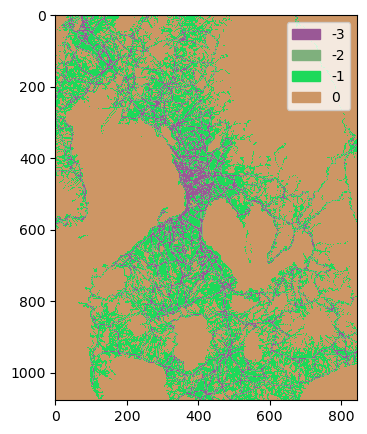

In [ ]:
roads_cost_raster = roads_cost_raster_minor + roads_cost_raster_major
plot_unique_value_raster(roads_cost_raster)

Features fetched 22047
Features without duplicates 21567


<Axes: >

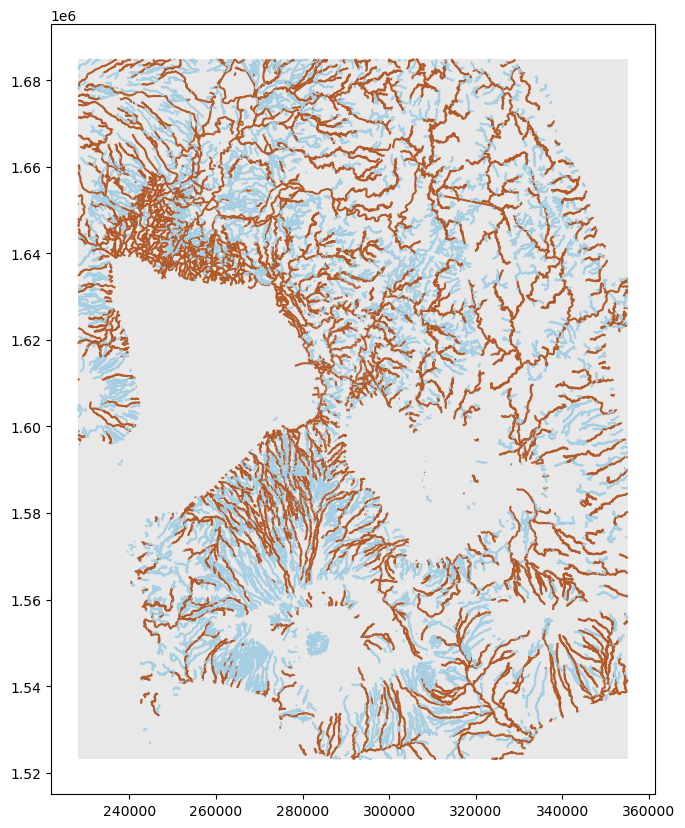

In [ ]:
# get OSM data for rivers
# see full list of classes at https://wiki.openstreetmap.org/wiki/Waterways

tags = {'waterway': ['river', 'stream', 'tidal_channel', 'canal', 'drain', 'ditch', 
                     'pressurised','fairway','fish_pass','canoe_pass']} 
col_list = ['id','name','waterway','intermittent','usage','geometry']

major_crit = {'waterway': ['river', 'canal']} 
geom_type = 'LineString'

waters = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
waters.plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,'place',

In [ ]:
# export the rivers to a shapefile

rivers_file_name = case_city + '_HYD_rivers_OSM_2024'
export_files(gdf=waters, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=None, 
             out_path=interim_path, 
             file_name = rivers_file_name)

Unique values [0 1] 
Min value 0 , Type: int16


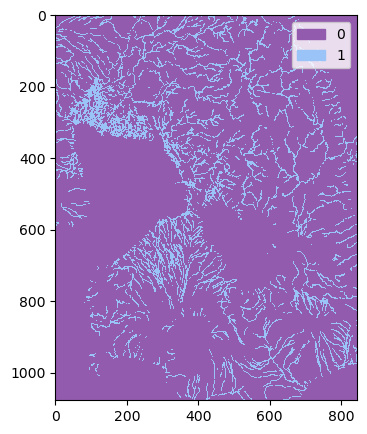

In [ ]:
# rasterize the rivers
# first, let's add a 100 m buffer to the rivers
waters_toraster = waters.loc[:,['major','geometry']].copy()
waters_toraster['geometry'] = waters_toraster.buffer(100)
#waters_toraster['major'] = (waters_toraster['major'] + 1) * 2

waters_raster = rasterise_vector(
    vector = waters_toraster, 
    ref_raster_path = ref_raster_150_path, 
    col='major', 
    default_value=1, 
    dtype=rasterio.int16)


plot_unique_value_raster(waters_raster)

In [ ]:
# export the raster to a tiff
file_name = case_city + '_HYD_rivers_OSM_2024.tif'
export_path = interim_path/file_name
raster_data_type=rasterio.int16
export_raster(waters_raster,export_path,raster_data_type)


Unique values [0. 1. 2. 4.] 
Min value 0.0 , Type: float32


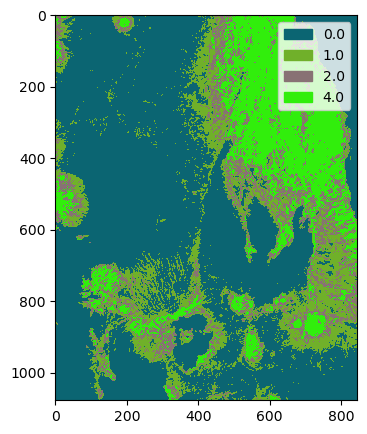

In [ ]:
# add all cost layers 
raster_file=case_city + '_DEM_slope_pct_TanDEM_X_150m.tif'
slope_raster_path = model_inputs_150m_path / raster_file

with rasterio.open(slope_raster_path) as src:
    slope = src.read(1)
    slope_meta = src.meta
    
    # reclass the slope raster
    slope = np.where(slope < 5, 0, slope)
    slope = np.where((slope >= 5)&(slope < 10), 1, slope)
    slope = np.where((slope >= 10)&(slope <35), 2, slope)
    slope = np.where((slope >= 35), 4, slope)
    slope_meta.update(dtype=rasterio.int16)

plot_unique_value_raster(slope)

#### Cost summary

Min value: 1 , Max value: 10
Unique values [0] 
Min value 0 , Type: int32


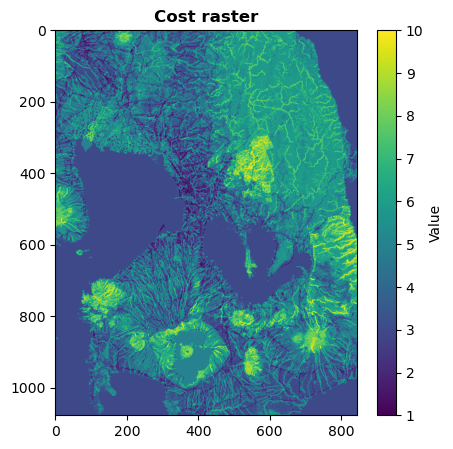

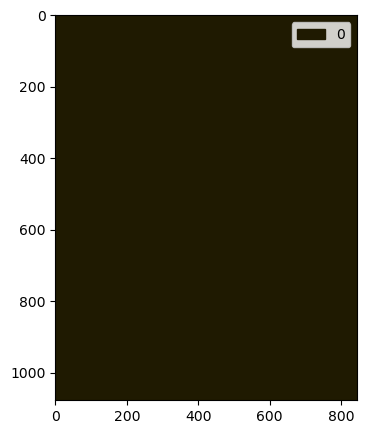

In [ ]:
# add the cost layers together
cost_raster = greens_raster + roads_cost_raster + waters_raster + slope + urban


# normalize
cost_raster = (cost_raster - np.nanmin(cost_raster))/(np.nanmax(cost_raster) - np.nanmin(cost_raster)) * 9

# round to integer
cost_raster = np.round(cost_raster).astype(np.int16)
cost_raster = cost_raster + 1
cost_null = np.where(cost_raster == 0, 1, 0)
plot_continuous_raster(cost_raster, title='Cost raster')
plot_unique_value_raster(cost_null)


At this point, we continue in ArcGIS with [Cost Distance Accumulation tool](https://pro.arcgis.com/en/pro-app/3.4/tool-reference/spatial-analyst/distance-accumulation.htm)<br>
(APS, 21.08.2025)

In [ ]:
# export to tiff
file_name = case_city + '_LOC_cost_raster_150m.tif'

with rasterio.open(ref_raster_150_path, 'r') as ref_raster:
    export_geotiff(
        raster= cost_raster, 
        out_transform = ref_raster.transform,
        out_meta = ref_raster.meta,
        export_path = interim_path / file_name,
        data_type = rasterio.float32)

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_LOC_cost_raster_150m.tif


#### Barriers: coastline

In [ ]:
waters.major.unique()

array([4, 2], dtype=int64)

Unique values [0 1] 
Min value 0 , Type: int32


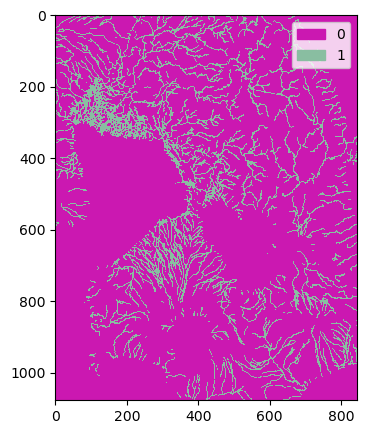

In [ ]:
# calculate the barriers using rivers and the coastline

rivers_raster = rasterise_vector(
    vector = waters.loc[waters.major == 4], 
    ref_raster_path = ref_raster_150_path, 
    col='major', 
    default_value=1, 
    dtype=rasterio.int16)

rivers_raster = np.where(rivers_raster == 4, 1, 0)
plot_unique_value_raster(rivers_raster)

Unique values [0 1] 
Min value 0 , Type: int32


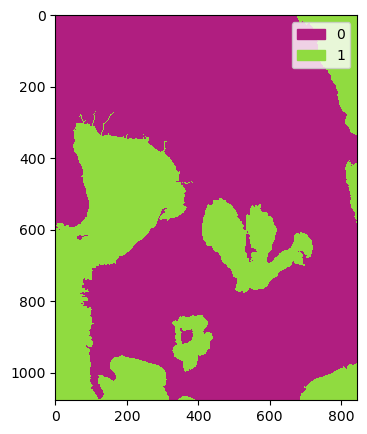

In [ ]:
# add the coastline
water_file = case_city + '_HYD_water_bodies_A.shp'

water_gdf = gpd.read_file(interim_path / water_file)
aoi_boundary_list = AOI_gdf['geometry'].bounds.values.tolist()[0]
water_gdf_clipped = gpd.clip(water_gdf, mask=aoi_boundary_list, keep_geom_type=True)
water_gdf_clipped['major'] = 1

water_geom = [shapes for shapes in water_gdf_clipped.geometry]

# rasterize the water bodies. note that we map the water bodies to 0 and the rest to 1
water_raster = features.rasterize(water_geom,
                                    out_shape = ref_raster.shape,
                                    # fill = 1,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)
# water_raster = np.where(water_raster == 0, 1, 0)

# plot_unique_value_raster(water_raster)

# we ditched the rivers and kept only the water bodies.
barriers_raster =  water_raster #rivers_raster +
barriers_raster = np.where(barriers_raster == 2, 1, barriers_raster )
plot_unique_value_raster(barriers_raster)

In [ ]:
# export the barriers raster
file_name = case_city + '_LOC_barriers_raster_150m.tif'

with rasterio.open(ref_raster_150_path, 'r') as ref_raster:
    export_geotiff(
        raster= barriers_raster, 
        out_transform = ref_raster.transform,
        out_meta = ref_raster.meta,
        export_path = interim_path / file_name,
        data_type = rasterio.int16)

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_LOC_barriers_raster_150m.tif


# 6. Slope

## Conver slope in degrees to percentage
ArcGIS Pro seems to be calculating the slope in percentage wrong. There are values of up to 600%, which do not make sense. Let's instead use the version in degrees and calculate the percentage ourselves.

<class 'numpy.ndarray'>
min: 0.0 max: 3.4e+38


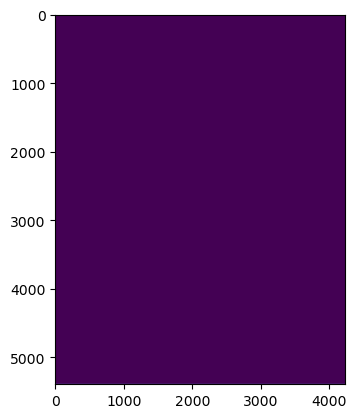

In [28]:
raster_file = case_city + '_DEM_slope_deg_TanDEM_X_30m.tif'
slope_raster_path = processed_path / raster_file
with rasterio.open(slope_raster_path, 'r') as src:
    slope_raster = src.read()
    for band in slope_raster:
        print(type(band))
        print('min:', np.nanmin(band), 'max:', np.nanmax(band))
    #print(src.shape, 'min:', np.nanmin(src), 'max:', np.nanmax(src))
    show(slope_raster)

In [26]:
from osgeo import gdal
print(str(slope_raster_path))
slope_deg_raster = gdal.Open(str(slope_raster_path))
slope_deg_array = slope_deg_raster.ReadAsArray()
plot_continuous_raster(slope_deg_raster, title='Slope in degrees')

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\processed\MAN_DEM_slope_deg_TanDEM_X_30m.tif


AttributeError: 'Dataset' object has no attribute 'read'

## export

In [76]:
file_name = case_city + '_DEM_slope_100pct_30m.tif'
with rasterio.open(ref_raster_path, 'r') as ref_raster:
        export_geotiff(
            raster= slope_array, 
            out_transform = ref_raster.transform,
            out_meta = ref_raster.meta,
            export_path = interim_path / file_name,
            data_type = rasterio.float32)

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_DEM_slope_100pct_30m.tif


## Copy the rasters to the model inputs folder

In [77]:
raster_file = case_city + '_DEM_slope_100pct_30m.tif'

file_copy_list = [raster_file]
for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_30m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_DEM_slope_100pct_30m.tif


## Alternatively, check the resampled 150 m raster

In [ ]:
%run ./ti_city_00_raster_functions.ipynb
file_name = case_city + '_DEM_slope_100pct_150m.tif'

# we need to verify if the resampling added negative values to the slope raster
slope_path =  model_inputs_150m_path / file_name
with rasterio.open(slope_path, 'r') as slope:
    slope_array = slope.read(1)
    print('The min slope was', np.nanmin(slope_array), 'and the max slope was', np.nanmax(slope_array))
    #slope_array = np.where(slope_array > 100, 100, slope_array)
    slope_array = (slope_array - np.nanmin(slope_array))/(np.nanmax(slope_array) - np.nanmin(slope_array))
    
    # Create a new raster with the same meta as slope and fill it with 100
    constant_raster = np.full(slope_array.shape, 100, dtype=slope_array.dtype)
    slope_array = np.round(slope_array,4) * constant_raster
    print('The min slope now is', np.nanmin(slope_array), 'and the max slope now is', np.nanmax(slope_array))

The min slope was -1.1288191 and the max slope was 390.5473
The min slope now is 0.0 and the max slope now is 100.0


In [ ]:
# export to GeoTIFF
file_name = case_city + '_DEM_slope_100pct_150m.tif'
data_type = rasterio.int16
raster = slope_array
url = interim_path / file_name
#ref_raster = ref_raster

export_raster(raster = raster,
              url = url,
              data_type=rasterio.float64,
              ref_raster_path=ref_raster_150_path)

## Copy the rasters to the model inputs folder

In [ ]:
raster_file = case_city + '_DEM_slope_0_100pct_150m.tif'

file_copy_list = [raster_file]

for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_150m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MUM\model_inputs\TIFF_150m\MUM_DEM_slope_0_100pct_150m.tif


# 7. DEM

# 8. Tenure status/informality
This data point is locally sourced, as there are not (to the best of our knowledge) any global or regional machine-readable data sources.<br>
Therefore, we will source each data from local information, often at the municipal or metropolitan level. <br>

<p> For **Mumbai**, there is available data for the Greater Mumbai area in the form of a slum clusters shapefile provided by the MMRDA. <br>
For Jakarta, there is slum-identification data for the Jakarta special administrative region. In this case, the workflow is similar to Mumbai.<br>
In these cases, the workflow is:</p>

- Import 2016 slum clusters
- Convert to raster
- Ressample and co-register to 150 m grid

<p> For **Manila**, there are 9 variables in the census identifying tenure. <br>
Census data source: https://data.humdata.org/dataset/philippines-subnational-population-and-housing-data-tables

Total household number with tenure = ['HU_TNOHL', 'HU_TNRHL','HU_TNOHRL','HU_TNNA','HU_TNND']

1. Housing unit tenure, own house and lot
2. Housing unit tenure, rent house and lot	
3. Housing unit tenure, own house and rent lot	
4. Housing unit tenure, not applicable	
5. Housing unit tenure, no data

Total household number without tenure = ['HU_TNFLWC','HU_TNFLNC', 'HU_TNRFWC','HU_TNRFNC']

1. Housing unit tenure, own house with free lot with consent	
2. Housing unit tenure, own house with free lot without consent	
3. Housing unit tenure, free house and lot with consent	
4. Housing unit tenure, free house and lot without consent	


- Reclassify the variables in a binary column</p>


### import & rasterise

In [ ]:
%run ./ti_city_00_raster_functions.ipynb

if case_city == 'MUM':
    # importing the slum data, created by the MMRDA in 2016
    slums_vector = gpd.read_file(external_path / 'MUM_URB_slum_clusters_MMRDA_2016_A.shp')

elif case_city == 'JAK':
    print('Jakarta slum data not available')
elif case_city == 'MAN':
    # we use census data to identify concentration of informal settlements
    # Cols for households with tenure = ['HU_TNOHL', 'HU_TNRHL','HU_TNOHRL','HU_TNNA','HU_TNND']
    # Cols for households without tenure = ['HU_TNFLWC','HU_TNFLNC', 'HU_TNRFWC','HU_TNRFNC']
    
    tenure_vector_temp = gpd.read_file(interim_path / 'MAN_POP_census_households_USCensus_2020_A.shp')
    tenure_vector = tenure_vector_temp.clip(AOI_gdf, keep_geom_type=True)
    tenure_vector.loc[:,'tenure_pct'] = round(tenure_vector.loc[:,['HU_TNOHL', 'HU_TNRHL','HU_TNOHRL','HU_TNNA','HU_TNND']].sum(axis=1) / tenure_vector['HU_HTOTL'] * 100, 3)
    tenure_vector.loc[:,'no_tenure_pct'] = round(tenure_vector.loc[:,['HU_TNFLWC','HU_TNFLNC', 'HU_TNRFWC','HU_TNRFNC']].sum(axis=1) / tenure_vector['HU_HTOTL'] * 100, 3)
    tenure_vector.loc[:,['HU_TNOHL', 'HU_TNRHL','HU_TNOHRL','HU_TNNA','HU_TNND','tenure_pct','HU_TNFLWC','HU_TNFLNC', 'HU_TNRFWC','HU_TNRFNC','no_tenure_pct']].head()
    tenure_vector.loc[:,'tenure_major'] = 0
    tenure_vector.loc[tenure_vector['no_tenure_pct'] > 30, 'tenure_major'] = 1
    slums_vector = tenure_vector.loc[tenure_vector['tenure_major'] == 1, ['geometry']]


<Axes: >

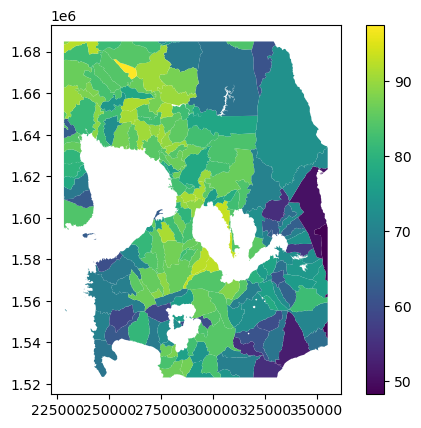

In [ ]:
tenure_vector.plot(column='tenure_pct', cmap='viridis', legend=True)


<Axes: >

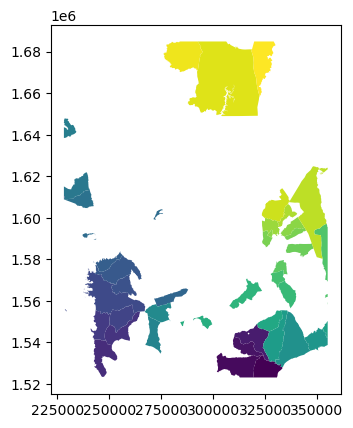

In [ ]:
slums_vector.plot(cmap='viridis', legend=True)

Unique values [0 1] 
Min value 0 , Type: int16


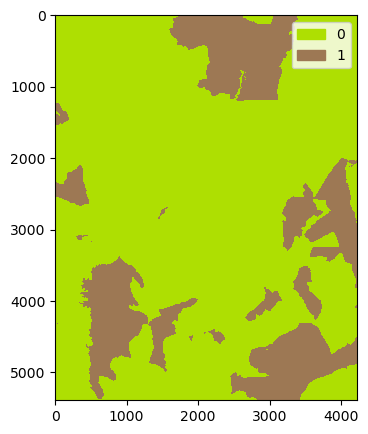

In [ ]:
slums_raster = rasterise_vector(
    vector = slums_vector, 
    ref_raster = ref_raster, 
    col=None, 
    default_value=1, 
    dtype = rasterio.int16)
# plot the result
plot_unique_value_raster(slums_raster)

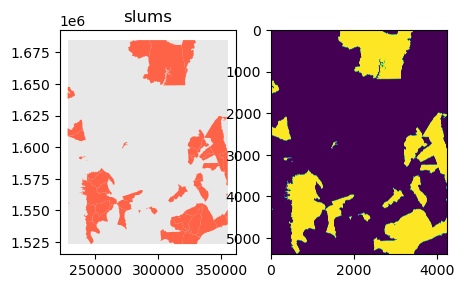

In [ ]:
# plot to check the conversion
vector = slums_vector
raster = slums_raster
title = 'slums'

def plot_vec_ras(vector, raster, title):
    fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (5, 5))
    vector.plot(ax=ax[0],color='tomato', linewidth=1, zorder=2)
    AOI_gdf.plot(ax=ax[0],  alpha=0.5, color='lightgray', zorder=1)
    
    AOI_gdf.plot(ax=ax[1],  alpha=0.5, color='lightgray', zorder=1)
    show(raster, ax = ax[1])
    
    ax[0].set_title( title)
    #ax[0].set_axis_off()
    plt.gca() 
    plt.show()

plot_vec_ras(vector, raster, title)

### subtract from the urban areas to get full_tenure = 1 and no_tenure = 0

Unique values [0 1 2] 
Min value 0 , Type: int32


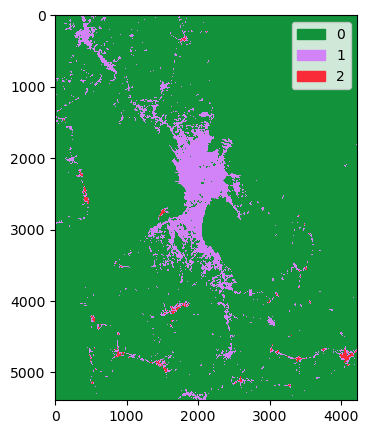

In [ ]:
%run ./ti_city_00_raster_functions.ipynb
urb_file = case_city + '_URB_urbanisation_2015_EOC_WUF_30m.tif'
with rasterio.open(interim_path / urb_file,'r') as urban_raster:
    urban_areas = np.where(urban_raster.read(1) == 1, 1, 0)
    #tenure_mask = slums_raster.mask(urban_areas)
    tenure_masked = np.where((slums_raster == 1) & (urban_areas == 1), 1, 0)
    #urban_areas = np.where(urban_areas == 1, -1, urban_areas)
    tenure = urban_areas + tenure_masked
    #tenure = np.where(tenure < 0, -9999, tenure)

    #plot_ras_ras(urban_areas, tenure,  title1='some data', title2='some data', AOI_gdf = AOI_gdf)
    plot_unique_value_raster(tenure)

### export

In [ ]:
# export to GeoTIFF
data_type = rasterio.int16
raster = tenure
file_name = case_city + '_URB_tenure_30m.tif'
url = interim_path / file_name
#ref_raster = ref_raster

with rasterio.open(
    url, "w",
    driver = "GTiff",
    crs = ref_raster.crs,
    transform = ref_raster.transform,
    dtype = data_type,
    count = 1,
    width = ref_raster.width,
    height = ref_raster.height) as dst:
    dst.write(raster, indexes = 1)

In [ ]:
# export the shapefile
file_name = case_city + '_URB_tenure_30m.shp'
url = interim_path / file_name

tenure_vector.to_file(url, crs = ref_raster.crs)

In [ ]:
# export to ASCII
file_name = case_city + '_URB_tenure_30m.asc'
export_raster_to_ascii(slums_2016_raster, 
                       interim_path/file_name, 
                       ref_raster=ref_raster,
                       raster_data_type=rasterio.int16)

## Copy the rasters to the model inputs folder

In [ ]:
file_name = case_city + '_URB_tenure_30m.tif'

file_copy_list = [file_name]

for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_30m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_URB_tenure_30m.tif


# 9. Exclusion & water layers
- Import water bodies
- Convert to raster
- Ressample and co-register to 30 m grid

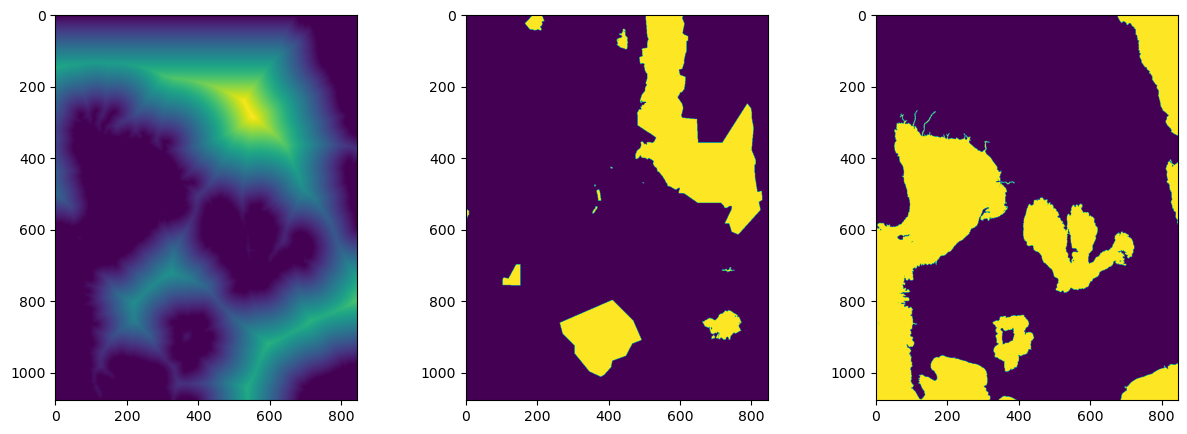

In [150]:
## ATTENTION: need to standardise the file names and the contents for the exclusion layer
# exclusion layer should include a) water bodies, b) national parks, c) other protected areas

water_file = case_city + '_HYD_water_bodies_A.shp'

# calculate the exclusion layer
water_gdf = gpd.read_file(interim_path / water_file)
aoi_boundary_list = AOI_gdf['geometry'].bounds.values.tolist()[0]
water_gdf_clipped = gpd.clip(water_gdf, mask=aoi_boundary_list, keep_geom_type=True)
water_gdf_clipped['major'] = 1

water_geom = [shapes for shapes in water_gdf_clipped.geometry]

# rasterize the water bodies. note that we map the water bodies to 0 and the rest to 1
water_raster = features.rasterize(water_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 1,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 0,
                                    dtype = None)

water_distance_raster = distance_transform_edt(water_raster)


# import national park features 
parks_file = case_city + '_LIM_natural_reserves_A.shp'
national_park_gdf = gpd.read_file(interim_path / parks_file)
national_park_gdf_clipped = gpd.clip(national_park_gdf, mask=aoi_boundary_list, keep_geom_type=True)
national_park_gdf_clipped['major'] = 1

national_park_geom = [shapes for shapes in national_park_gdf_clipped.geometry]

# rasterize the national parks
national_park_raster = features.rasterize(national_park_geom,
                                    out_shape = ref_raster.shape,
                                    fill = 0,
                                    out = None,
                                    transform = ref_raster.transform,
                                    all_touched = True,
                                    default_value = 1,
                                    dtype = None)

if (case_city == 'MUM') | (case_city == 'JAK'):
    exclusion_raster = water_raster + national_park_raster
    exclusion_raster = np.where(exclusion_raster > 1, 1, exclusion_raster)
elif case_city == 'MAN':
    exclusion_raster = np.where(water_raster == 0, 1, 0)  # for Manila, the team decided not to include national parks

ax, fig = plt.subplots(1,3, figsize=(15,5))
show(water_distance_raster, ax=fig[0])
show(national_park_raster, ax=fig[1])
show(exclusion_raster, ax=fig[2])

plt.show()

Min value: 0.0 , Max value: 1.0


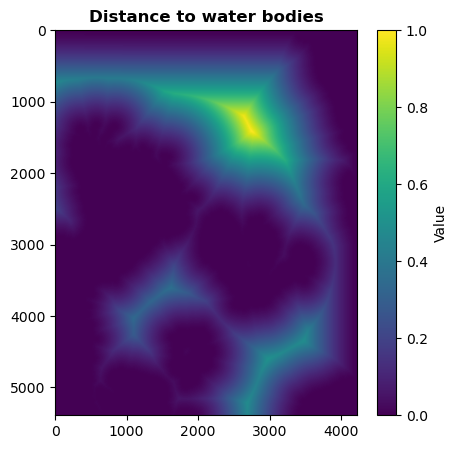

In [29]:
scale_factor = 1.5

water_influence = np.power(water_distance_raster, scale_factor)
water_influence_normal = (water_influence - np.nanmin(water_influence))/(np.nanmax(water_influence) - np.nanmin(water_influence))

plot_continuous_raster(water_influence_normal, title='Distance to water bodies')

Unique values [0 1] 
Min value 0 , Type: int32


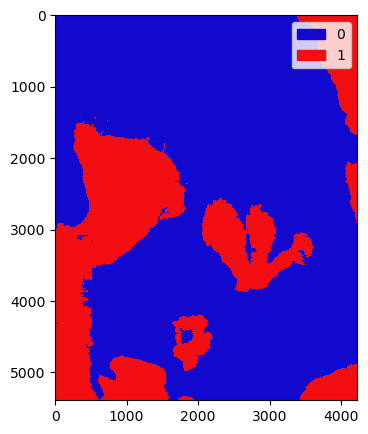

In [30]:
plot_unique_value_raster(exclusion_raster)

## export

In [34]:
file_copy_list = []

# export to GeoTIFF
data_type = rasterio.int16
raster = exclusion_raster
tiff_file_name = case_city + '_LIM_exclusion_layer_30m.tif'
file_copy_list.append(tiff_file_name)
tiff_path = interim_path / tiff_file_name

with rasterio.open(
    tiff_path, "w",
    driver = "GTiff",
    crs = ref_raster.crs,
    transform = ref_raster.transform,
    dtype = data_type,
    count = 1,
    width = ref_raster.width,
    height = ref_raster.height) as dst:
    dst.write(raster, indexes = 1)
print(tiff_path)

raster = water_influence_normal
data_type = rasterio.float64
tiff_file_name = case_city + '_HYD_water_distance_30m.tif'
tiff_path = interim_path / tiff_file_name
file_copy_list.append(tiff_file_name)

with rasterio.open(
    tiff_path, "w",
    driver = "GTiff",
    crs = ref_raster.crs,
    transform = ref_raster.transform,
    dtype = data_type,
    count = 1,
    width = ref_raster.width,
    height = ref_raster.height) as dst:
    dst.write(raster, indexes = 1)
print(tiff_path)


for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_30m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_LIM_exclusion_layer_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\interim\MAN_HYD_water_distance_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_LIM_exclusion_layer_30m.tif
D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_HYD_water_distance_30m.tif


# 10. Attractiveness 2000 & 2020
1. Used real estate portals information on most attractive neighbourhoods in each city. 
- MUM: https://www.nobroker.in/blog/posh-areas-in-mumbai/
- MAN: https://santosknightfrank.com/blogs/a-guide-to-the-most-exclusive-villages-in-metro-manila/ and https://www.spot.ph/newsfeatures/adulting/108119/most-expensive-subdivisions-metro-manila-2024-a5229-20240221
- JAK: https://expatindonesia.id/2025/5-most-expensive-jakarta-property-areas-in-2025/

2. calculated Euclidian distances and normalised (min-max).
3. export to ASCII

## Working with OSM point data and real estate market website info

Check
- https://workatflow.com/blog/jakarta-central-business-district-indonesias-premier-commercial-hub/
- 

Attention: Mixed geometry types found, will be converted to points
Features fetched 12099
Features without duplicates 11887


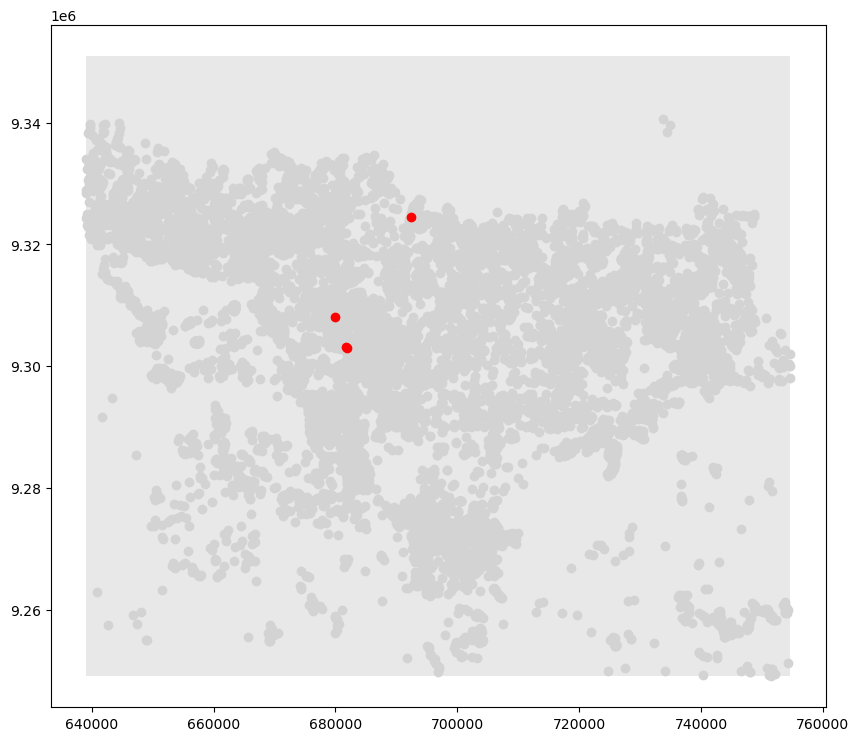

In [60]:
## ATTENTION:  attractiveness proxies are **manually** set for each case study. This is hard to automate.

# List key-value pairs for tags
tags = {'landuse': ['commercial','retail','residential'], 'place':['suburb','neighbourhood','quarter']} # see https://wiki.openstreetmap.org/wiki/Key:landuse for more info,
col_list = ['id','name','geometry','landuse', 'place'] 

# finding the 'attractive areas' is very subjective. We tried using centrality and accessibility as proxies, but the results were not satisfactory.
# hence, we define a ad hoc list of OSM names for the attractive areas using real estate websites and validate it locally

if case_city == 'MUM':
    # source: https://www.nobroker.in/blog/posh-areas-in-mumbai/)
    posh_list = ['Juhu', 'Malabar Hill', 'Cuffe Parade', 'Bandstand', 'Tardeo', 'Pali Hill', 'Worli Sea Face', 'Breach Candy',
             'Seven Bungalows', 'Versova', 'Hiranandani', 'Powai', 'Altamount Road', 'JVPD Scheme', 'Vile Parle East',
             'Andheri East','Dadar East', 'Parel']
elif case_city == 'MAN':
    # source: https://santosknightfrank.com/blogs/a-guide-to-the-most-exclusive-villages-in-metro-manila/
    # source: https://www.spot.ph/newsfeatures/adulting/108119/most-expensive-subdivisions-metro-manila-2024-a5229-20240221
    posh_list = ['Forbes Park','Dasmariñas Village','Urdaneta Village','Bel-Air Village Phase I and II',
                 'San Lorenzo Village','Magallanes Village','Ayala Alabang','Corinthian Gardens',
                 'Green Meadows','Greenhills East','Loyola Grand Villas','White Plains', 'AFPOVAI Phase V-A',
                 'McKinley Hill', 'BF Homes','Sikatuna Village'] #'Greenwoods Executive Homes',
elif case_city == 'JAK':
    # source: https://expatindonesia.id/2025/5-most-expensive-jakarta-property-areas-in-2025/
    posh_list = ['Menteng', 'Kuningan', 'Kemang', 'Pondok Indah', 'Senayan', 'Pantai Indah Kapuk', 'Gading Serpong', 'BSD City']

major_crit = {'name': posh_list} 
geom_type = 'Mixed'

attractive = get_osm_features(tags, col_list, geom_type, major_crit, AOI_gdf)
attractive_selected = attractive.loc[attractive.name.isin(posh_list),:]

#plot them
f = plt.figure(figsize=(10, 10))
ax=f.add_subplot(111)

#cbd.loc[(cbd.major==1),:].plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', zorder=1)
ax.plot(attractive.centroid.x,attractive.centroid.y,'o',color='lightgrey', marker='o', zorder=2) #cmap='Paired',
AOI_gdf.plot(ax=ax,  alpha=0.5, color='lightgray', zorder=1)
ax.plot(attractive_selected.centroid.x,attractive_selected.centroid.y, 'ro', zorder=3)
plt.show()


In [59]:
for i in sorted(posh_list):
    print(i)
attractive_2024_selected

BSD City
Gading Serpong
Kemang
Kuningan
Menteng
Pantai Indah Kapuk
Pondok Indah
Senayan


id                name                        geometry  \
378     10759331            BSD City  POINT (681867.175 9303020.365)   
225  12553018899            BSD City  POINT (681748.266 9303151.277)   
265      6543247      Gading Serpong  POINT (679982.178 9308110.008)   
135   9191746033  Pantai Indah Kapuk   POINT (692471.977 9324444.71)   

         landuse          place  major  
378  residential         suburb      1  
225          NaN         suburb      1  
265  residential            NaN      1  
135          NaN  neighbourhood      1

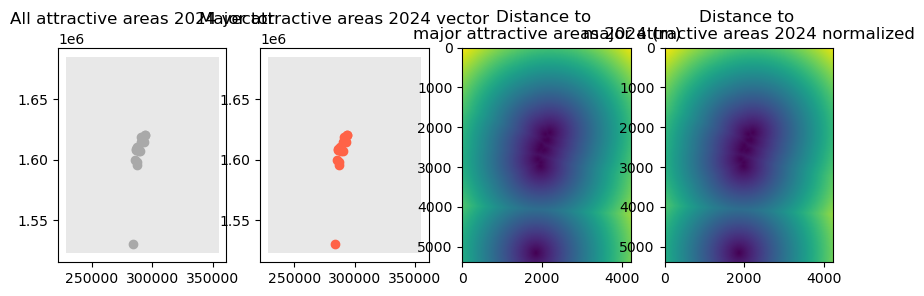

In [ ]:
# rasterize and calculate distances
attractive2024_major_raster, attractive2024_full_raster, attractive2024_distance_raster, attractive2024_dist_normalized = get_distance_raster(attractive_2024_selected, ref_raster)

# Plot the outputs
plot_vec_vec_ras_ras(attractive_2024_selected, attractive2024_distance_raster, attractive2024_dist_normalized, 'attractive areas 2024')



In [ ]:
print(type(attractive2024_dist_normalized),type(attractive2024_full_raster))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
file_name = case_city + '_LOC_attractive_areas_OSM_2024_P'
out_path = interim_path

normalized_raster_file = file_name + '_distance_normal_30m.tif'
normalized_url = out_path / normalized_raster_file
export_raster(raster = attractive2024_dist_normalized,
                url = normalized_url,
                data_type = rasterio.float32,
                ref_raster_path = ref_raster_path)

In [ ]:
gdf = attractive_2024_selected
gdf_vector_file = file_name + '.shp'
gdf_url = out_path/gdf_vector_file
gdf.to_file(gdf_url, driver='ESRI Shapefile')

In [ ]:
%run ./ti_city_00_raster_functions.ipynb

In [ ]:
file_name = case_city + '_LOC_attractive_areas_OSM_2024_P'
out_path = interim_path



export_files(gdf = attractive_2024_selected, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=attractive2024_dist_normalized, 
             out_path=interim_path, 
             file_name=file_name)

## do the same process with 2000 data
still need to implement this step

In [ ]:
# import 2000 OSM data


# 11. Income 2000 and 2020 
- For **Mumbai**<br>
we use ArcGIS online information on income from 2001 and 2015 at the census subdistrict scale.
Variable: "Percentage of households having assets like TV, computer, mobile, and scooter or car' from the 2011 census. 
Reclassified to <1% = 1 (low income), 1.1-3% = 2 (medium income), and >3.01 = 3 (high income).<br>
This process includes: <br>
- Import shapefile with census district boundaries
- Clip to AOI
- Reclassify
- Rasterize
- Export to ASCII

- For **Jakarta** & **Manila** <br>
  We will prepare the data from Kummu M, Kosonen M, Masoumzadeh Sayyar S. Downscaled gridded global dataset for gross domestic product (GDP) per capita PPP over 1990–2022. Sci Data. 2025;12(1):178. doi:10.1038/s41597-025-04487-x. <br>
  The data comes clipped and resampled (but not co-registered) to the AOIs. We need to co-register and extract the correct bands (Band 3 = 2000, Band 7 = 2020).
This process includes: <br>
- Import multi-band TIFF file
- Co-register to AOI reference
- Select the bands for 2000 and 2020
- Export to ASCII & TIFF


## Mumbai

In [ ]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition
# ATTENTION: need to standardise the file names for the census layers

# import shapefile with census data
# the shapefile was created by merging the 2011 census data from ArcGIS online and the GADM4 level 3 polygons
census_path = interim_path / 'MUM_LIM_census_subdistricts_GADM4_A.shp'
census_gdf = gpd.read_file(census_path, include_fields = ['GID_3','NAME_3','geometry','CS_asset11']) # CS_asset11 is the percentage of households with assets like TV, computer, mobile, car or scooter.

### rasterise

income_class
1    10
2    10
3    10
Name: count, dtype: int64 30


<Axes: >

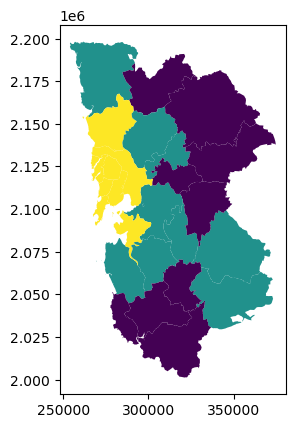

In [ ]:
# reclassify the CS_asset11 variable into income classes
census_gdf['income_class'] = pd.qcut(census_gdf['CS_asset11'], q=3, labels=[1,2,3])
print(census_gdf['income_class'].value_counts(), len(census_gdf))
census_gdf.plot('income_class', cmap='viridis')

In [ ]:
print(census_gdf.crs, ref_raster.crs, census_gdf.dtypes)

EPSG:32643 EPSG:32643 GID_3             object
NAME_3            object
CS_asset11       float64
geometry        geometry
income_class    category
dtype: object


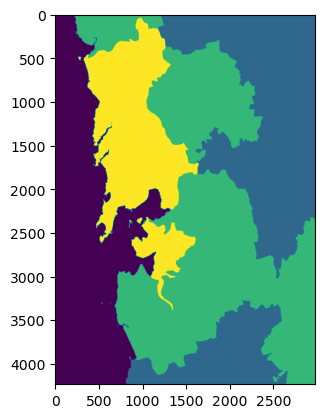

<Axes: >

In [ ]:
# rasterize the census data
geom_value = ((geom,value) for geom, value in zip(census_gdf.geometry, census_gdf['income_class']))
#census_raster = rasterise_vector(geom_value, ref_raster, -9999)

# Rasterize vector using the shape and transform of the raster
census_raster = features.rasterize(geom_value,
                                out_shape = ref_raster.shape,
                                transform = ref_raster.transform,
                                all_touched = True,
                                fill = 0,   # background value
                                #merge_alg = MergeAlg.replace,
                                dtype = rasterio.int16)

show(census_raster)

In [ ]:
file_name = case_city + '_POP_census_income_GADM4_30m.tif'

# export to GeoTIFF
with rasterio.open(ref_raster_path, 'r') as reference:
    with rasterio.open(interim_path / file_name, 
                       "w",
                        driver = "GTiff",
                        crs = reference.crs,
                        transform = reference.transform,
                        dtype = rasterio.int16,
                        count = 1,
                        width = reference.width,
                        height = reference.height) as dst:
        dst.write(census_raster, indexes = 1)

### Copy the rasters to the model inputs folder

In [ ]:
file_name = case_city + '_POP_census_income_GADM4_30m.tif'

file_copy_list = [file_name]
for file in file_copy_list:
    origin_path = interim_path / file
    destination_path = model_inputs_30m_path / file
    shutil.copy(origin_path, destination_path)
    print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MUM\model_inputs\TIFF_30m\MUM_POP_census_income_2015_30m.tif


## JAK & MAN

In [ ]:
# import the TIFF files


# 12. Real estate prices
- Convert point data into raster
- Clip points to the AOI
- Interpolate to cover all AOI
- Ressample and co-register to 30 m grid
- Convert prices to USD

## MUM & JAK: Working with Lepetit et al. 2022 data

In [ ]:
# This section does not work with the generic AOI definition yet.
# the database takes 192 cities globally, so we need to filter the data to the city at hand

# import file to be clipped
real_estate_path = Path('\\WD Gridded Real Estate Population and Land Use Petit et al\\RealEstateData.csv')

full_path = external_data_path.joinpath(*real_estate_path.parts[1:])
#print(real_estate_path,'\n', external_data_path,'\n', full_path)   

real_estate_df = pd.read_csv(full_path)
col_list = ['X','Y','avgSize','medSize','avgPriceSqm','medPriceSqm','Currency','avgPriceSqm_percentilesOutliers','medPriceSqm_percentilesOutliers',
                                            'TransactionType','TransactionMonth','TransactionYear','dolar_avgPriceSqm','dolar_medPriceSqm']

# convert values to USD
conversion_dict = {'INR':0.012, 'IDR':0.000064} 
for key, value in conversion_dict.items():
    real_estate_df.loc[real_estate_df['Currency'] == key, 'dolar_avgPriceSqm'] = round(real_estate_df['avgPriceSqm']*value,2)
    real_estate_df.loc[real_estate_df['Currency'] == key, 'dolar_medPriceSqm'] = round(real_estate_df['medPriceSqm']*value,2)



In [ ]:
# create a new dataframe with the cities and the average real estate price per square meter
city_df = real_estate_df.groupby('City').agg({'dolar_avgPriceSqm':'mean','dolar_medPriceSqm':'mean'}).reset_index()
city_df = city_df.dropna(axis=0,how='any',subset=['dolar_avgPriceSqm','dolar_medPriceSqm'])
city_df

City  dolar_avgPriceSqm  dolar_medPriceSqm
4    Ahmedabad         306.309112         285.834370
12     Bandung         450.958698         442.400677
13   Bangalore         302.872375         292.276699
54       Delhi         624.475704         564.681118
75   Hyderabad         318.253199         305.515596
79     Jakarta         683.607845         675.962246
105      Medan         625.255067         597.994400
114     Mumbai         630.522072         613.837262
164   Surabaya         531.373039         507.322541

In [ ]:
cities_list = city_df['City'].tolist()
mean_value_list = city_df['dolar_avgPriceSqm'].round(2).tolist()

In [ ]:
mean_value_list

[306.31, 450.96, 302.87, 624.48, 318.25, 683.61, 625.26, 630.52, 531.37]

In [ ]:
# Segmenting for Mumbai
MUM_real_estate_sale = real_estate_df.loc[(real_estate_df.City=='Mumbai')&(real_estate_df.TransactionType == 'Sale'),col_list]
MUM_real_estate_rent = real_estate_df.loc[(real_estate_df.City==case_city + 'bai')&(real_estate_df.TransactionType == 'Rent'),col_list]
# Creating Mumbai GeoDataFrames
MUM_real_estate_sale_gdf = gpd.GeoDataFrame(MUM_real_estate_sale, geometry=gpd.points_from_xy(MUM_real_estate_sale.X, MUM_real_estate_sale.Y), crs='EPSG:32643').clip(mask=MUM_AOI_gdf, keep_geom_type=True)
MUM_real_estate_rent_gdf = gpd.GeoDataFrame(MUM_real_estate_rent, geometry=gpd.points_from_xy(MUM_real_estate_rent.X, MUM_real_estate_rent.Y), crs='EPSG:32643').clip(mask=MUM_AOI_gdf, keep_geom_type=True)

# Segmenting for Jakarta
JAK_real_estate_sale = real_estate_df.loc[(real_estate_df.City=='Jakarta')&(real_estate_df.TransactionType == 'Sale'),col_list]
JAK_real_estate_rent = real_estate_df.loc[(real_estate_df.City=='Jakarta')&(real_estate_df.TransactionType == 'Rent'),col_list]
# Creating Jakarta GeoDataFrames
JAK_real_estate_sale_gdf = gpd.GeoDataFrame(JAK_real_estate_sale, geometry=gpd.points_from_xy(JAK_real_estate_sale.X, JAK_real_estate_sale.Y), crs='EPSG:32648').clip(mask=JAK_AOI_gdf, keep_geom_type=True)
JAK_real_estate_rent_gdf = gpd.GeoDataFrame(JAK_real_estate_rent, geometry=gpd.points_from_xy(JAK_real_estate_rent.X, JAK_real_estate_rent.Y), crs='EPSG:32648').clip(mask=JAK_AOI_gdf, keep_geom_type=True)

MUM_real_estate_sale.describe()

X             Y     avgSize     medSize    avgPriceSqm  \
count    7938.000000  7.938000e+03  894.000000  894.000000     894.000000   
mean   299434.129400  2.108579e+06   91.217890   85.559506  135191.821598   
std     23382.376748  2.829047e+04   48.758811   46.036931  110741.497454   
min    259434.129400  2.060079e+06   18.580600   18.580600    9785.377319   
25%    279434.129400  2.084079e+06   60.859760   58.528890   57026.167640   
50%    299434.129400  2.108579e+06   79.750828   74.322400   93034.874565   
75%    319434.129400  2.133079e+06  107.636835  102.193300  179320.605234   
max    339434.129400  2.157079e+06  696.772500  696.772500  672832.631181   

         medPriceSqm  avgPriceSqm_percentilesOutliers  \
count     894.000000                       821.000000   
mean   131614.172567                    125766.158767   
std    108564.707006                     79320.921545   
min      9785.377319                     35879.716837   
25%     55660.060731                     62566.060633   
50%     89699.292093                     95168.128791   
75%    176796.914926                    177306.685995   
max    807293.628839                    385957.113389   

       medPriceSqm_percentilesOutliers  TransactionYear  dolar_avgPriceSqm  \
count                       821.000000           7938.0         894.000000   
mean                     124480.275373           2019.0        1622.301644   
std                       80622.698195              0.0        1328.898090   
min                       35879.716837           2019.0         117.420000   
25%                       60927.821044           2019.0         684.310000   
50%                       93548.690550           2019.0        1116.415000   
75%                      175147.066240           2019.0        2151.850000   
max                      385957.113389           2019.0        8073.990000   

       dolar_medPriceSqm  
count         894.000000  
mean         1579.370034  
std          1302.776432  
min           117.420000  
25%           667.917500  
50%          1076.390000  
75%          2121.565000  
max          9687.520000

### exploring the real estate distribution

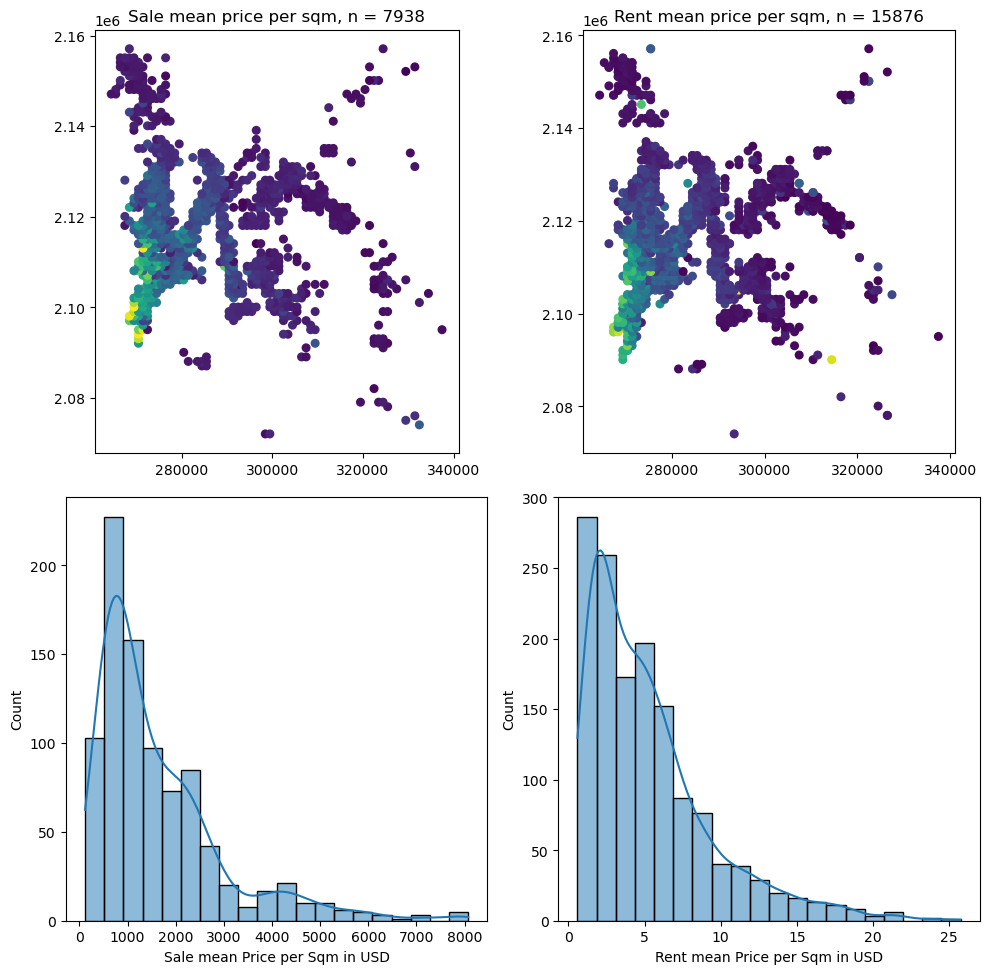

In [ ]:
from matplotlib.gridspec import GridSpec
var = 'dolar_avgPriceSqm'
# Create a figure with GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Plot GeoDataFrames
MUM_real_estate_sale_gdf.plot(var, ax=ax0, legend=False, cmap='viridis', markersize=30)
MUM_real_estate_rent_gdf.plot(var, ax=ax1, legend=False, cmap='viridis', markersize=30)

# Plot histograms
vis1 = sns.histplot(x=var, data=MUM_real_estate_sale, bins=20, kde=True, ax=ax2)
vis2 = sns.histplot(x=var, data=MUM_real_estate_rent, bins=20, kde=True, ax=ax3)

# Set titles
ax0.set_title('Sale mean price per sqm, n = ' + str(len(MUM_real_estate_sale_gdf)))
ax1.set_title('Rent mean price per sqm, n = ' + str(len(MUM_real_estate_rent_gdf)))
# Set x-axis titles for histograms

ax2.set_xlabel('Sale mean Price per Sqm in USD')#+MUM_real_estate_sale.Currency.unique()[0])
ax3.set_xlabel('Rent mean Price per Sqm in USD')#'+MUM_real_estate_rent.Currency.unique()[0])
# Adjust layout to ensure equal column widths
plt.tight_layout()

# Show plot
plt.show()

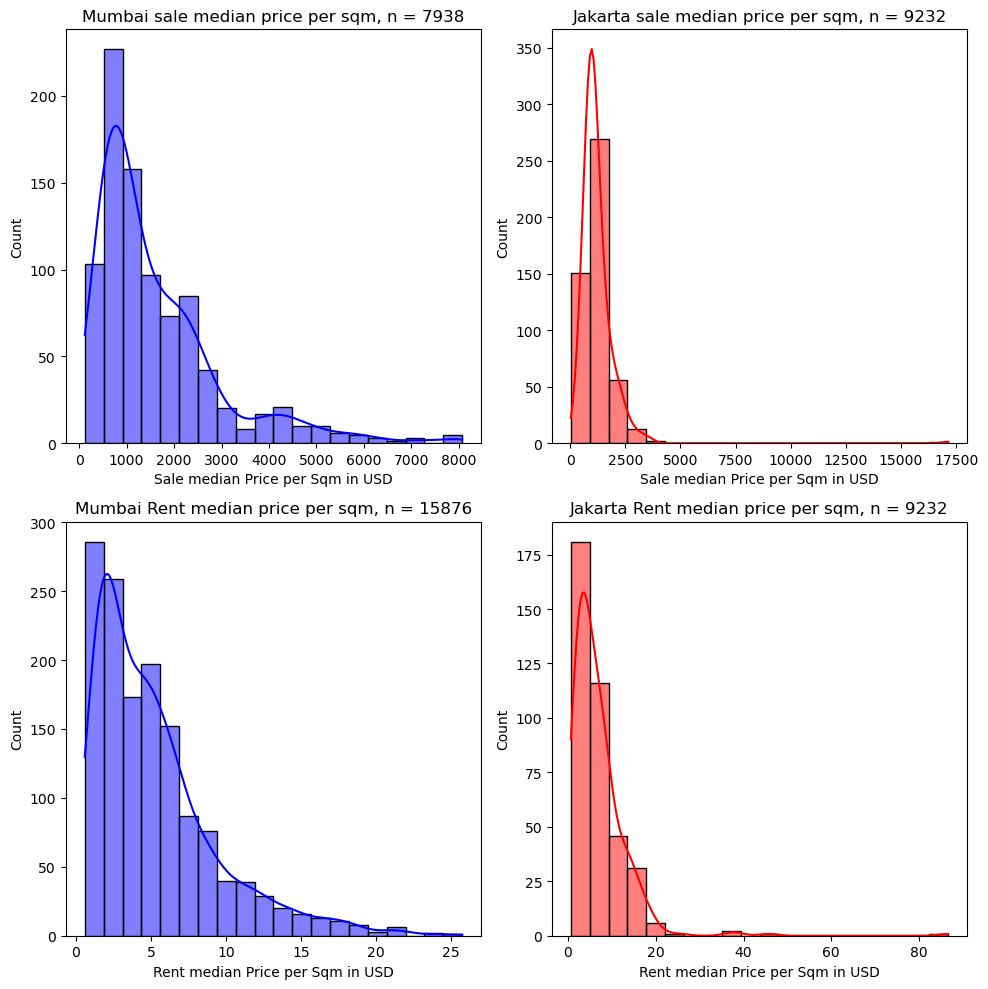

In [ ]:
# plotting and comparing MUM and JAK
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, figure=fig)
var = 'dolar_avgPriceSqm'

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

'''# Plot GeoDataFrames
MUM_real_estate_sale_gdf.plot('medPriceSqm', ax=ax0, legend=False, cmap='viridis', markersize=30)
MUM_real_estate_rent_gdf.plot('medPriceSqm', ax=ax1, legend=False, cmap='viridis', markersize=30)
'''

# Plot histograms
vis1 = sns.histplot(x=var, data=MUM_real_estate_sale, bins=20, kde=True, ax=ax0, color='blue')
vis2 = sns.histplot(x=var, data=MUM_real_estate_rent, bins=20, kde=True, ax=ax1, color='blue')
vis3 = sns.histplot(x=var, data=JAK_real_estate_sale, bins=20, kde=True, ax=ax2, color='red')
vis4 = sns.histplot(x=var, data=JAK_real_estate_rent, bins=20, kde=True, ax=ax3, color='red')

# Set titles
ax0.set_title('Mumbai sale median price per sqm, n = ' + str(len(MUM_real_estate_sale_gdf)))
ax1.set_title('Mumbai Rent median price per sqm, n = ' + str(len(MUM_real_estate_rent_gdf)))
ax2.set_title('Jakarta sale median price per sqm, n = ' + str(len(JAK_real_estate_sale_gdf)))
ax3.set_title('Jakarta Rent median price per sqm, n = ' + str(len(JAK_real_estate_rent_gdf)))

# Set x-axis titles for histograms
ax0.set_xlabel('Sale median Price per Sqm in USD')# '+MUM_real_estate_sale.Currency.unique()[0])
ax1.set_xlabel('Rent median Price per Sqm in USD')# '+MUM_real_estate_rent.Currency.unique()[0])
ax2.set_xlabel('Sale median Price per Sqm in USD')# '+JAK_real_estate_sale.Currency.unique()[0])
ax3.set_xlabel('Rent median Price per Sqm in USD')#'+JAK_real_estate_rent.Currency.unique()[0])

# Adjust layout to ensure equal column widths
plt.tight_layout()

# Show plot
plt.show()


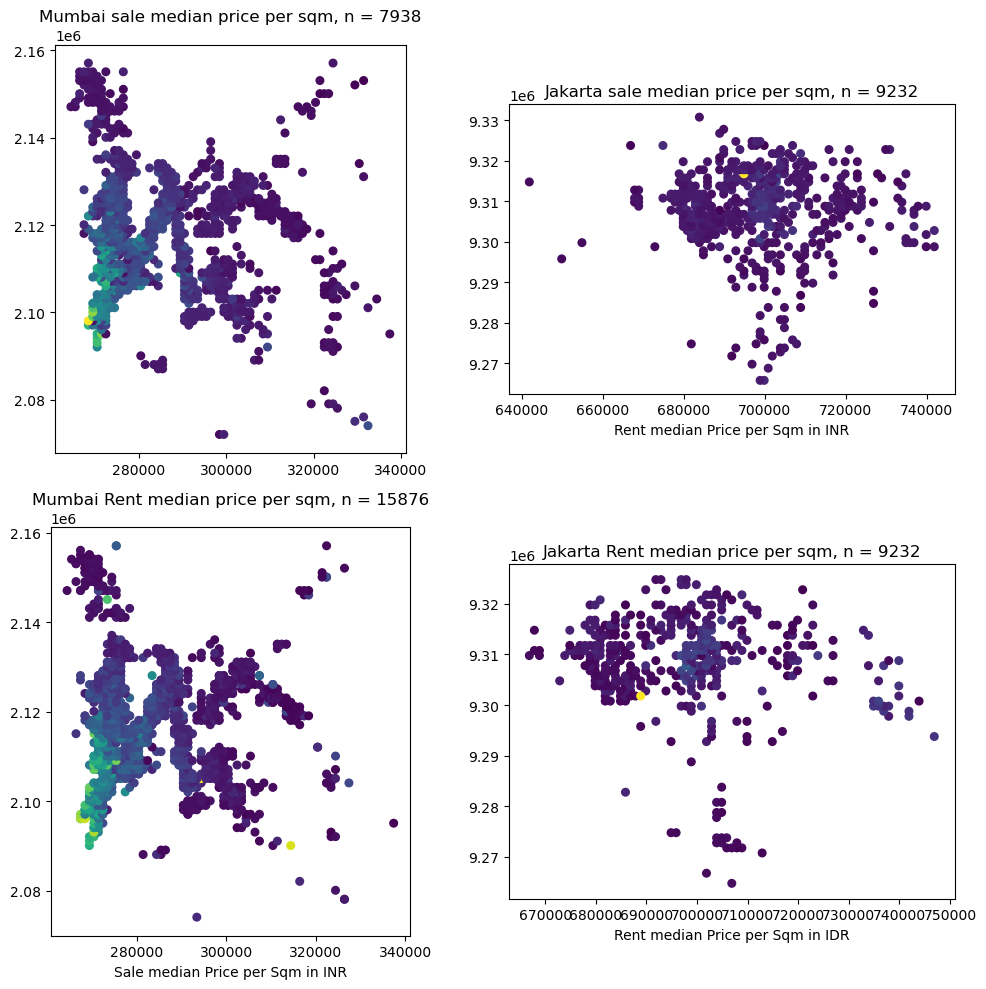

In [ ]:
# plotting and comparing MUM and JAK
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Plot GeoDataFrames
MUM_real_estate_sale_gdf.plot('medPriceSqm', ax=ax0, legend=False, cmap='viridis', markersize=30)
MUM_real_estate_rent_gdf.plot('medPriceSqm', ax=ax1, legend=False, cmap='viridis', markersize=30)
JAK_real_estate_sale_gdf.plot('medPriceSqm', ax=ax2, legend=False, cmap='viridis', markersize=30)
JAK_real_estate_rent_gdf.plot('medPriceSqm', ax=ax3, legend=False, cmap='viridis', markersize=30)


'''# Plot histograms
vis1 = sns.histplot(x='medPriceSqm', data=MUM_real_estate_sale, bins=20, kde=True, ax=ax0)
vis2 = sns.histplot(x='medPriceSqm', data=MUM_real_estate_rent, bins=20, kde=True, ax=ax1)
vis3 = sns.histplot(x='medPriceSqm', data=JAK_real_estate_sale, bins=20, kde=True, ax=ax2)
vis4 = sns.histplot(x='medPriceSqm', data=JAK_real_estate_rent, bins=20, kde=True, ax=ax3)'''

# Set titles
ax0.set_title('Mumbai sale median price per sqm, n = ' + str(len(MUM_real_estate_sale_gdf)))
ax1.set_title('Mumbai Rent median price per sqm, n = ' + str(len(MUM_real_estate_rent_gdf)))
ax2.set_title('Jakarta sale median price per sqm, n = ' + str(len(JAK_real_estate_sale_gdf)))
ax3.set_title('Jakarta Rent median price per sqm, n = ' + str(len(JAK_real_estate_rent_gdf)))

# Set x-axis titles for histograms
ax1.set_xlabel('Sale median Price per Sqm in '+MUM_real_estate_sale.Currency.unique()[0])
ax2.set_xlabel('Rent median Price per Sqm in '+MUM_real_estate_rent.Currency.unique()[0])
ax3.set_xlabel('Sale median Price per Sqm in '+JAK_real_estate_sale.Currency.unique()[0])
ax3.set_xlabel('Rent median Price per Sqm in '+JAK_real_estate_rent.Currency.unique()[0])

# Adjust layout to ensure equal column widths
plt.tight_layout()

# Show plot
plt.show()


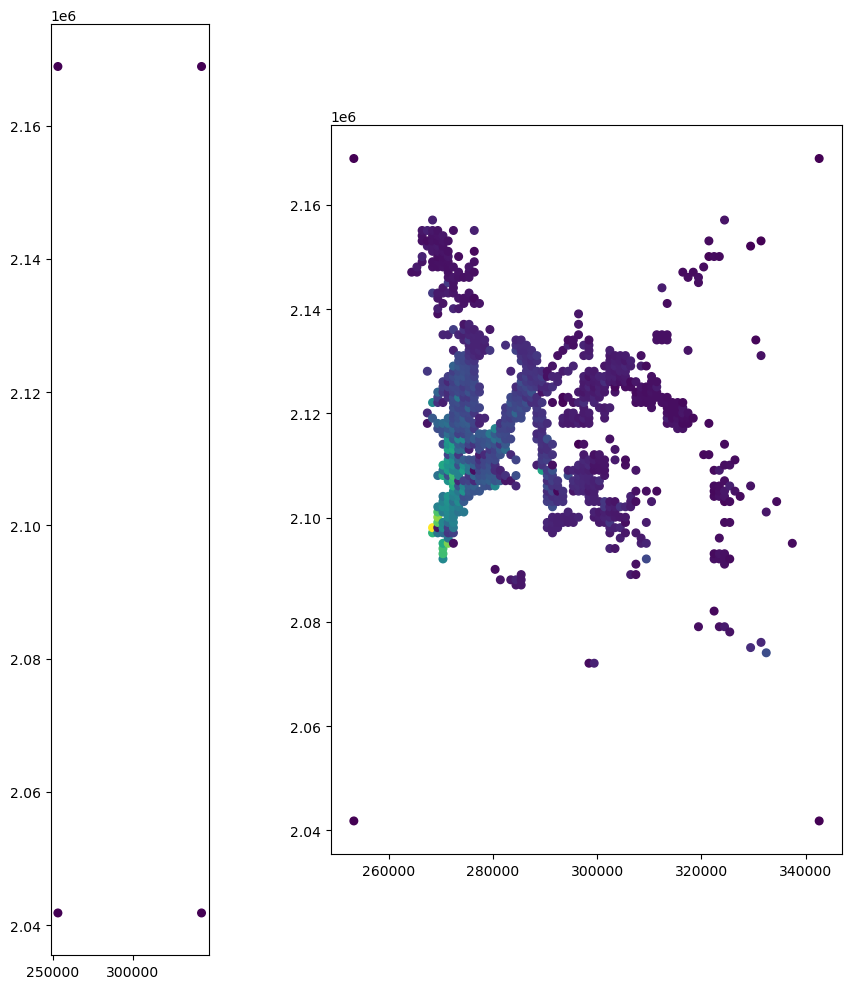

In [ ]:
# add fake points to the real estate data at the extremes of the AOI_gdf
min_avgPriceSqm = MUM_real_estate_sale_gdf['medPriceSqm'].min()
min_medPriceSqm = MUM_real_estate_sale_gdf['medPriceSqm'].min()
min_dolar_avgPriceSqm = MUM_real_estate_sale_gdf['dolar_medPriceSqm'].min()
min_dolar_medPriceSqm = MUM_real_estate_sale_gdf['dolar_medPriceSqm'].min()
# create a fake point at the extremes of the AOI_gdf
fake_points = gpd.GeoDataFrame({'X': [AOI_gdf.bounds.minx.min(), AOI_gdf.bounds.maxx.max(),AOI_gdf.bounds.minx.min(), AOI_gdf.bounds.maxx.max()],
                                'Y': [AOI_gdf.bounds.miny.min(), AOI_gdf.bounds.maxy.max(), AOI_gdf.bounds.maxy.max(),AOI_gdf.bounds.miny.min()],
                                'avgPriceSqm': [min_avgPriceSqm, min_avgPriceSqm, min_avgPriceSqm, min_avgPriceSqm],
                                'medPriceSqm': [min_medPriceSqm, min_medPriceSqm, min_medPriceSqm, min_medPriceSqm],
                                'dolar_avgPriceSqm': [min_dolar_avgPriceSqm, min_dolar_avgPriceSqm, min_dolar_avgPriceSqm, min_dolar_avgPriceSqm],
                                'dolar_medPriceSqm': [min_dolar_medPriceSqm, min_dolar_medPriceSqm, min_dolar_medPriceSqm, min_dolar_medPriceSqm],
                                'TransactionType': ['Sale', 'Sale', 'Sale', 'Sale'],
                                'TransactionMonth': ['Jul', 'Jul', 'Jul', 'Jul'],
                                'TransactionYear': [2019, 2019, 2019, 2019],
                                'Currency': ['INR', 'INR','INR','INR']})

fake_points_gdf = gpd.GeoDataFrame(fake_points, geometry=gpd.points_from_xy(fake_points.X, fake_points.Y), crs='EPSG:4326')

# append the fake points to the real estate data
MUM_real_estate_sale_AOI_gdf = MUM_real_estate_sale_gdf.merge(fake_points_gdf, how='outer')

# plotting and comparing MUM and JAK
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(1, 2, figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
'''ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
'''
# Plot GeoDataFrames
fake_points_gdf.plot('medPriceSqm', ax=ax0, legend=False, cmap='viridis', markersize=30)
MUM_real_estate_sale_AOI_gdf.plot('medPriceSqm', ax=ax1, legend=False, cmap='viridis', markersize=30)


# Adjust layout to ensure equal column widths
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# export the sale dfs to shapefiles

MUM_real_estate_sale_gdf.to_file(interim_path/'MUM_ECO_real_estate_sale_2019_LePetit_P.shp')
MUM_real_estate_sale_AOI_gdf.to_file(interim_path/'MUM_ECO_real_estate_sale_2019_LePetit_AOI_P.shp')

## JAK: alternative, scrapping from rumah123
https://www.rumah123.com/en/sale/cari/

## MAN: scrapping data from Lamudi.com.ph

In [44]:
# code from https://github.com/arl7d/portfoilioprojects/blob/main/Web_scraping_Philippine_real_estate/V2_web_scrape_ph_house_lot.py
# data scrapped from https://www.lamudi.com.ph/

from bs4 import BeautifulSoup
import requests
import unicodedata
import lxml 
from lxml import etree

# function below taken from stack overflow to convert latin n to english n

def strip_accents(text):
    return ''.join(char for char in
                   unicodedata.normalize('NFKD', text)
                   if unicodedata.category(char) != 'Mn')

ModuleNotFoundError: No module named 'lxml'

In [ ]:
# main routine to sift through pages and take real estate info then load it into dataframe
# create empty dict as a container for our data later on
real_estate_dict = {}
# initialize page as zero
page = 0
max_page = 50

while page in range(0,max_page):
    page += 1
    html_text = requests.get(f'https://www.lamudi.com.ph/buy/?page={page}').text
    soup = BeautifulSoup(html_text,'lxml')  
    all_info = soup.find_all('div', class_='ListingCell-AllInfo ListingUnit')
    for i in range(len(all_info)):
        info = all_info[i]
        header = info.find('h3', class_='ListingCell-KeyInfo-title').text.strip()
        #print('begin add: ', header)  # used for testing/debugging
        location = info.find('span', class_='ListingCell-KeyInfo-address-text').text.strip()
        try:
            price = info.find('span', class_='PriceSection-FirstPrice').text.strip()
            price = price.lstrip("₱ ").replace(',','').replace(' ','')
        except AttributeError:
            price = np.nan
        try:
            bedrooms = '' 
            bath = ''
            floor_area = ''
            # the xml coding changed since the initial scrapping, so we need to adjust the code
            amenities = info.find_all('span', class_='KeyInformation-value_v2 KeyInformation-amenities-icon_v2')
            for item in amenities:
                if 'icon-bedrooms' in str(item):
                    bedrooms = str(item).split('>')[3].split('<')[0].strip()
                if 'icon-bathrooms' in str(item):
                    bath = str(item).split('>')[3].split('<')[0].strip()
                if 'icon-livingsize' in str(item):
                    floor_area = str(item).split('>')[3].split('<')[0].strip()
                    floor_area = floor_area.rstrip(" m²")
                if 'icon-land_size' in str(item):
                    land_area = str(item).split('>')[3].split('<')[0].strip().rstrip(" m²")
                    land_area = land_area.rstrip(" m²")
        except AttributeError:
            bedrooms =np.nan  # used numpy NaN objects instead of the string "an" to avoid errors when casting to integers later
            bath = np.nan
            floor_area = np.nan
        #print('bd:',bedrooms, '\n','ba:',bath, '\n','fa:',floor_area) # used for testing/debugging
        
        # get the geolocation
        geo_start = str(info).index('data-geo-point=')
        geo_end = str(info).index(']',geo_start) 
        # Calculating the end is better than assuming it will be in a certain position as the number of positions after the comma varies in the original data
        geo_location = str(info)[geo_start+17:geo_end]
        geo_location = geo_location.replace(']','')
        geo_location = geo_location.replace('"','')
        geo_location = geo_location.replace(' ','')
        geo_location = geo_location.replace('d','')
        geo_location = geo_location.replace('a','')
        geo = geo_location.split(",")
        longitude = geo[0].replace(r'[^0-9.]', '')
        latitude = geo[1].replace(r'[^0-9.]', '')
        
        # search for the type of property. this is critical for analysis, as we do not want to compare plots with apartments or houses.
        cat_start = str(info).index('data-subcategories=')
        cat_end = str(info).index(']',cat_start)
        cat = str(info)[cat_start+21:cat_end]
        cat = cat.replace('"','')
        subcat = cat.split(',')[1]
        cat = cat.split(',')[0]
        #print(cat, '\n',subcat) # used for testing/debugging
        
        link = info.a['href']
        # need to create an ID for the dict below. This will be our unique identifier in the df later
        
        id_var = str(page) + str(i)
        # print(id_var) # used for testing/debugging
        # working with a dict seems more economic than appending a df
        real_estate_dict[id_var] = {
                'description' : strip_accents(header),
                'location' : strip_accents(location),
                'price_PHP' : price,
                'bedrooms' : bedrooms,
                'bath' : bath,
                'floor_area_sqm' : floor_area,
                'land_area_sqm' : land_area,
                'category' : cat,
                'subcategory' : subcat,
                'latitude' : latitude,
                'longitude' : longitude,
                'link' : link}
        #print('\n++++++++ finished add ++++++++ \n')
                
    print(f'finished page {page}')

real_estate_df = pd.DataFrame.from_dict(real_estate_dict, orient='index')
print('+++++++++ finished all ++++++++++','\n', 'total entries:', len(real_estate_df))
    

finished page 1
finished page 2
finished page 3
finished page 4
finished page 5
finished page 6
finished page 7
finished page 8
finished page 9
finished page 10
finished page 11
finished page 12
finished page 13
finished page 14
finished page 15
finished page 16
finished page 17
finished page 18
finished page 19
finished page 20
finished page 21
finished page 22
finished page 23
finished page 24
finished page 25
finished page 26
finished page 27
finished page 28
finished page 29
finished page 30
finished page 31
finished page 32
finished page 33
finished page 34
finished page 35
finished page 36
finished page 37
finished page 38
finished page 39
finished page 40
finished page 41
finished page 42
finished page 43
finished page 44
finished page 45
finished page 46
finished page 47
finished page 48
finished page 49
finished page 50
+++++++++ finished all ++++++++++ 
 total entries: 1420


In [ ]:
real_estate_df = pd.DataFrame.from_dict(real_estate_dict, orient='index')

real_estate_df["latitude"] = pd.to_numeric(real_estate_df["latitude"], downcast="float") 
real_estate_df["longitude"] = pd.to_numeric(real_estate_df["longitude"], downcast="float") 
real_estate_df["floor_area_sqm"] = pd.to_numeric(real_estate_df["floor_area_sqm"], downcast="float") 
real_estate_df["bedrooms"] = pd.to_numeric(real_estate_df["bedrooms"], downcast="integer") 
real_estate_df["bath"] = pd.to_numeric(real_estate_df["bath"], downcast="integer", errors='coerce') 
real_estate_df["price_PHP"] = pd.to_numeric(real_estate_df["price_PHP"], downcast="float") 
real_estate_df['date_accessed'] = pd.to_datetime('today').strftime('%Y-%m-%d')
real_estate_df['source'] = 'Lamudi'
real_estate_df['price_USD'] = round(real_estate_df['price_PHP']*0.021, 3)
real_estate_df['price_sqm_USD'] = round(real_estate_df['price_USD']/real_estate_df['floor_area_sqm'], 3)
# move the column 'price_USD' and 'price_sqm_USD' to the third position
cols = real_estate_df.columns.tolist()
cols = cols[:2] + [cols[-2]] +[cols[-1]] + cols[2:-2]
#print(cols)
real_estate_df = real_estate_df[cols]
real_estate_df.head()

description                location  \
10  2 Bedroom House and Lot in a Beachfront Commun...          Guinsay, Danao   
11  3 Bedroom House for Sale fronting Amenity and ...          Guinsay, Danao   
12  RFO DEC 2024 Exclusive Village  BNEW House Sun...   Sun Valley, Paranaque   
13  1 Bedroom For sale Condo in San Lorenzo Place ...      Magallanes, Makati   
14  East Gallery Place Prime 2BR unit For Sale- wi...  Fort Bonifacio, Taguig   

      price_USD  price_sqm_USD   price_PHP  bedrooms  bath  floor_area_sqm  \
10   189000.000       1219.355   9000000.0       2.0   NaN           155.0   
11   283500.000       2025.000  13500000.0       3.0   NaN           140.0   
12   987021.000       2946.331  47001000.0       6.0   NaN           335.0   
13    34006.245       1307.933   1619345.0       1.0   1.0            26.0   
14  1785000.000      11666.667  85000000.0       2.0   2.0           153.0   

   land_area_sqm category          subcategory   latitude   longitude  \
10           220    house  single-family-house  10.545016  124.027977   
11           225    house          beach-house  10.545016  124.027977   
12           350    house  single-family-house  14.491803  121.038010   
13           350    condo             condotel  14.543703  121.018524   
14           350    condo              other-4  14.540867  121.050316   

                                                 link date_accessed  source  
10  https://www.lamudi.com.ph/projects/aduna-villa...    2024-11-14  Lamudi  
11  https://www.lamudi.com.ph/projects/aduna-villa...    2024-11-14  Lamudi  
12  https://www.lamudi.com.ph/projects/sun-valley-...    2024-11-14  Lamudi  
13  https://www.lamudi.com.ph/buy/metro-manila/mak...    2024-11-14  Lamudi  
14  https://www.lamudi.com.ph/projects/east-galler...    2024-11-14  Lamudi

### remove the outliers from the data

Shape before z-score: (1322, 17) 
 min: 4.964 
 max: 7788.715
Shape after z-score: (1317, 17) 
 min: 4.964 
 max: 7691.014


<Axes: xlabel='price_sqm_USD', ylabel='price_USD'>

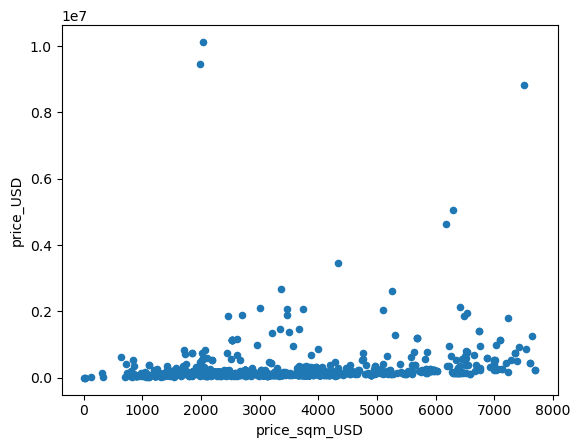

In [ ]:
# let's use the Z-score to remove outliers
from scipy import stats
real_estate_df = real_estate_df[real_estate_df['price_sqm_USD'] >= 1]
print('Shape before z-score:', real_estate_df.shape, '\n min:', real_estate_df['price_sqm_USD'].min(), '\n max:', real_estate_df['price_sqm_USD'].max())
real_estate_df['z_score'] = stats.zscore(real_estate_df['price_sqm_USD'])
real_estate_df = real_estate_df.loc[real_estate_df['z_score'].abs() < 3]
print('Shape after z-score:', real_estate_df.shape, '\n min:', real_estate_df['price_sqm_USD'].min(), '\n max:', real_estate_df['price_sqm_USD'].max())
real_estate_df.plot(x='price_sqm_USD', y='price_USD', kind='scatter')

In [ ]:

#remove empty values
real_estate_df = real_estate_df[real_estate_df['price_sqm_USD'] >= 1]

# determine the outliers via IQR
Q1 = real_estate_df['price_sqm_USD'].quantile(0.25)
Q3 = real_estate_df['price_sqm_USD'].quantile(0.75)
IQR = Q3 - Q1
top_limit = Q3 + 1.5 * IQR
bottom_limit = Q1 - 1.5 * IQR
print('Top limit:', top_limit, '\nBottom limit:', bottom_limit, '\nSTD:', real_estate_df['price_sqm_USD'].std())
real_estate_df = real_estate_df.loc[real_estate_df['price_USD'] < top_limit]


Top limit: 6881.0705 
Bottom limit: -816.8015000000005 
STD: 1685.896219423603


### create geodataframe

In [ ]:
real_estate_gdf_temp = gpd.GeoDataFrame(real_estate_df, geometry=gpd.points_from_xy(real_estate_df.longitude, real_estate_df.latitude), crs='EPSG:4326')
real_estate_gdf_temp = real_estate_gdf_temp.to_crs(AOI_gdf.crs)
real_estate_gdf = real_estate_gdf_temp.clip(AOI_gdf, keep_geom_type=True)

# add points at the edge of the AOI to ensure interpolation will include it all
min_price_USD = real_estate_gdf['price_USD'].min()
min_price_sqm_USD = real_estate_gdf['price_sqm_USD'].min()
min_y = AOI_gdf.bounds.miny.min()
max_y = AOI_gdf.bounds.maxy.max()
min_x = AOI_gdf.bounds.minx.min()
max_x = AOI_gdf.bounds.maxx.max()
#print(min_price, '\ny',min_y, max_y, '\nx',min_x, max_x)
fake_points = pd.DataFrame({'description': ['fake1, min y/min x','fake2, min y/max x','fake3, max y/max x','fake4, min y/max x'],
                            'price_USD': [min_price_USD, min_price_USD, min_price_USD, min_price_USD],
                            'price_sqm_USD': [min_price_sqm_USD, min_price_sqm_USD, min_price_sqm_USD, min_price_sqm_USD],
                            'category': ['fake', 'fake', 'fake', 'fake'],
                                'latitude': [min_y, min_y,max_y, max_y],
                                'longitude': [min_x, max_x, max_x,min_x],
                                'date_accessed': pd.to_datetime('today').strftime('%Y-%m-%d'),
                                'source': 'Estimated'})
fake_points_gdf= gpd.GeoDataFrame(fake_points, geometry=gpd.points_from_xy(fake_points.longitude, fake_points.latitude), crs=AOI_gdf.crs)
print('original len', len(real_estate_gdf))
# append the fake points to the real estate data
real_estate_AOI_gdf = real_estate_gdf.merge(fake_points_gdf, how='outer')
print('adjusted len', len(real_estate_AOI_gdf))


original len 793
adjusted len 797


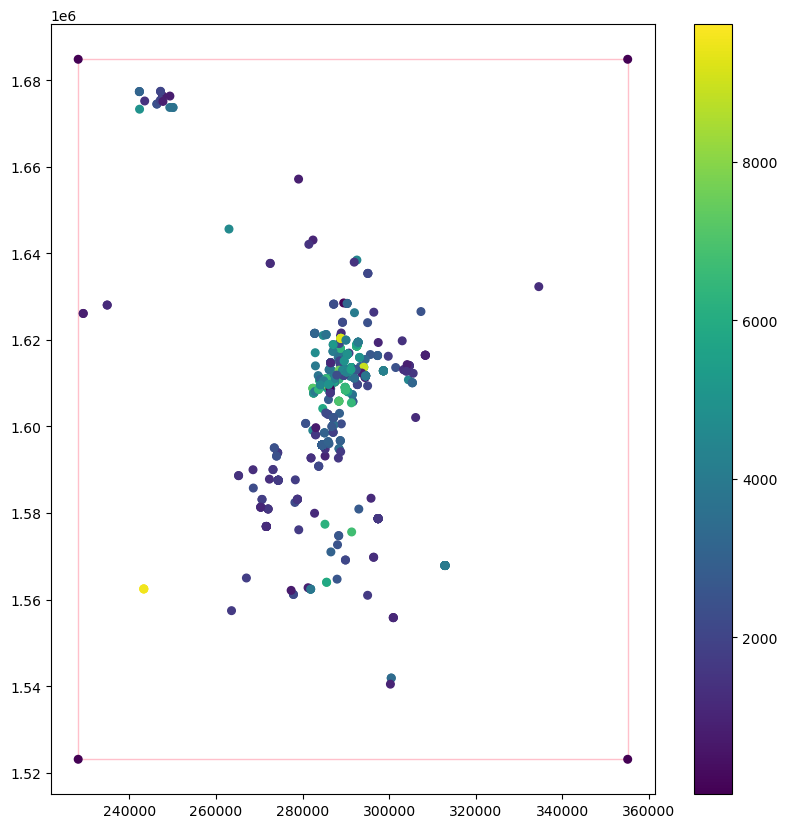

805 793 ['condo' 'house' 'fake']


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
real_estate_residential = real_estate_gdf_AOI.loc[(real_estate_gdf_AOI['category']!='land') & (real_estate_gdf_AOI['category']!='commercial'), :]
real_estate_residential.plot('price_sqm_USD', cmap='viridis', legend=True, ax=ax, markersize=30, zorder=3)
#fake_points_gdf.plot('price_sqm_USD', cmap='viridis', legend=False, ax=ax, markersize=30, zorder=3)
AOI_gdf.boundary.plot(ax=ax, color='pink', linewidth=1, zorder=1)
#roads.loc[roads.major==1].plot(ax=ax, color='grey', linewidth=1, alpha=0.5, zorder=0) 
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
print(len(real_estate_gdf_AOI), len(real_estate_residential), real_estate_residential['category'].unique())

In [ ]:
# export the data
file_name = case_city + '_ECO_real_estate_prices_2024_P.shp'
real_estate_gdf_AOI.to_file(interim_path/file_name, encoding = 'utf-8')

file_name = case_city + '_ECO_real_estate_prices_residential_2024_P.shp'
real_etate_residential.to_file(interim_path/file_name, encoding = 'utf-8')

## working with ARCGIS generated interpolations 
In ArcGIS:
- applied Empirical Bayesian Krigging, see https://pro.arcgis.com/en/pro-app/3.0/tool-reference/geostatistical-analyst/empirical-bayesian-kriging.htm
- Resampled the raster to classes 0 (nodata), 1 (low income), 2 (middle income), and 3 (high income) <br>
- MHADA housing programe references: https://www.mhada.gov.in/en and https://housing.com/news/apply-mhada-lottery-scheme/

|    <br>Class    |    <br>USD/m2                                   |    <br>MHADA     |
|-----------------|-------------------------------------------------|------------------|
|    <br>0        |    <br>0                                        |    <br>n/a       |
|    <br>1        |    <br>Below   US$715.00/m2                     |    <br>LIG       |
|    <br>2        |    <br>Between   US$715.01 and US$835.00/m2     |    <br>MIG       |
|    <br>3        |    <br>Above   US$835.01/m2                     |    <br>HIG       |


+++++ real estate rater bounds +++++
228167.4357
1523098.4837
355157.43570000003
1684828.4837
+++++++++++++++++++++++++++++++++++

***** ref raster rater bounds *****
228167.4357
1523098.4837
355127.43570000003
1684828.4837
***********************************
Min value: 0.0 , Max value: 7167.217


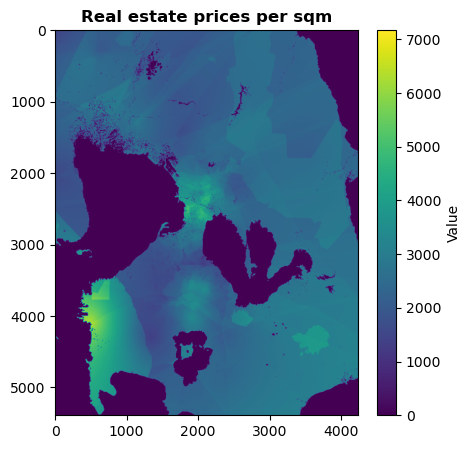

In [ ]:
# re-import the interpolated data from ArcGIS into raster
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_30m.tif'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_30m.tif.tif'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamuidi_extended_2024_30m.tif'

with rasterio.open(interim_path/ real_estate_path,'r') as real_estate_raster:
    # check values
    real_estate_raster_obj = np.where(real_estate_raster.read(1) < 0, 0, real_estate_raster.read(1))
    #print('Min val:',real_estate_raster_obj.min()) # check if the minimum value is 0
    
    # check bounds
    print('+++++ real estate rater bounds +++++')
    for b in real_estate_raster.bounds:
        print(b)
    print('+++++++++++++++++++++++++++++++++++\n\n***** ref raster rater bounds *****')
    for b in ref_raster.bounds:
        print(b)
    print('***********************************')
    plot_continuous_raster(real_estate_raster_obj, title='Real estate prices per sqm')
    

[2317.8005, 2953.2742309570312]
0.0 7167.217
Unique values [0 1 2 3] 
Min value 0 , Type: int32


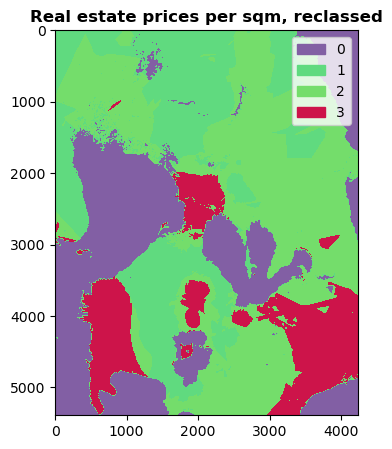

In [ ]:
## OPTIONAL: reclassify the raster to three classes

# optional, optional
# normal_real_estate_raster = np.round((real_estate_raster_obj - np.nanmin(real_estate_raster_obj))/(np.nanmax(real_estate_raster_obj) - np.nanmin(real_estate_raster_obj)),4)

# testing quantiles
real_estate_classes = [np.quantile(real_estate_raster_obj, 0.1), np.quantile(real_estate_raster_obj, 0.9), real_estate_raster_obj.max()]

# testing std. deviation: low income = below the median, middle income = median + std/2, high income = all above middle income
real_estate_std = np.std(real_estate_raster_obj)
#real_estate_classes = [np.median(real_estate_raster_obj)-(real_estate_std/3), np.median(real_estate_raster_obj)+(real_estate_std/3),  real_estate_raster_obj.max()]
real_estate_classes = [np.median(real_estate_raster_obj), np.median(real_estate_raster_obj)+(real_estate_std/2)]
print(real_estate_classes)
print(real_estate_raster_obj.min(), real_estate_raster_obj.max())

reclass_raster1 = np.where((real_estate_raster_obj > 0) & (real_estate_raster_obj <= real_estate_classes[0]), 1, 0)
reclass_raster2 = np.where((real_estate_raster_obj > real_estate_classes[0]) & (real_estate_raster_obj <= real_estate_classes[1]), 2, 0)
reclass_raster3 = np.where((real_estate_raster_obj > real_estate_classes[1]), 3, 0)

reclass_raster = reclass_raster1 + reclass_raster2 + reclass_raster3

plot_unique_value_raster(reclass_raster, title='Real estate prices per sqm, reclassed')

In [ ]:
# export to TIFF and ASCII

if case_city == 'MUM':
    real_estate_tiff_file = 'MUM_ECO_real_estate_LePetit_reclass_2019_30m.tif'
if case_city == 'JAK':
    real_estate_tiff_file = 'JAK_ECO_real_estate_LePetit_reclass_2019_30m.tif'
if case_city == 'MAN':
    real_estate_tiff_file = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_30m.tif'


# export to TIFF
export_tiff_path = interim_path/real_estate_tiff_file
export_raster(raster = reclass_raster,
              url = export_tiff_path,
              data_type=rasterio.int16,
              ref_raster_path=ref_raster_path)

# real_estate_ascii_file = real_estate_tiff_file.replace('.tif','.asc')
# export to ASCII
# export_ascii_path = interim_path/real_estate_ascii_file
#export_raster_to_ascii(normal_real_estate_raster, export_ascii_path, ref_raster,raster_data_type)

## Copy the rasters to the model inputs folder

In [ ]:

origin_path = interim_path / real_estate_tiff_file
destination_path = model_inputs_30m_path / real_estate_tiff_file

shutil.copy(origin_path, destination_path)
print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_ECO_real_estate_EBK_Lamuidi_reclass_2024_30m.tif


## re-import the 150m raster and check the extent

0
BoundingBox(left=253336.3548, bottom=2041681.0224, right=342586.3548, top=2168881.0224)
bounds should be: BoundingBox(left=253336.3548, bottom=2041831.0224, right=342586.3548, top=2168881.0224)
Unique values [0 1 2 3] 
Min value 0 , Type: uint8


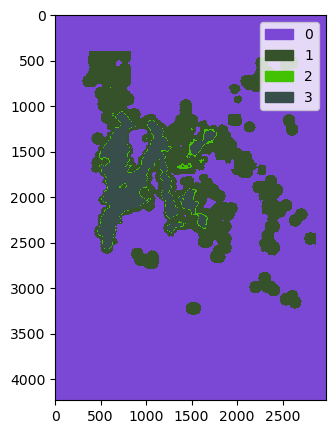

In [ ]:
# APS, 01.11.2024: need to update the code below to use generic AOI definition

# import the 150m raster
real_estate_path = 'MUM_ECO_real_estate_sale_2019_LePetit_extended_150m.tif'
with rasterio.open(model_inputs_150m_path/ real_estate_path,'r') as real_estate_raster:
    print(real_estate_raster_obj.min()) # check if the minimum value is 0
    # check the raster's extents
    print(real_estate_raster.bounds)
    print('bounds should be:',ref_raster.bounds)
    plot_unique_value_raster(real_estate_raster_obj)
    

# 13. Planning

## 30 m resolution

In [11]:
# import non-residential areas shapefile
non_residential_path = case_city + '_LIM_non_residential_areas_30m.shp'
non_residential_gdf = gpd.read_file(interim_path/non_residential_path)

# rasterise the layer
non_residential_raster = rasterise_vector(vector = non_residential_gdf, 
                 ref_raster_path = ref_raster_path, 
                 col=None, 
                 default_value=1, 
                 dtype=rasterio.int16)

# export the tiff file
file_name = case_city + '_LIM_non_residential_areas_30m.tif'
non_residential_raster_path = interim_path / file_name
export_raster(raster = non_residential_raster,
              url = non_residential_raster_path,
              data_type=rasterio.int16,
              ref_raster_path=ref_raster_path)

In [12]:
# copy the file to the model inputs folder
origin_path = interim_path / file_name
destination_path = model_inputs_30m_path / file_name

shutil.copy(origin_path, destination_path)
print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_30m\MAN_LIM_non_residential_areas_30m.tif


## 150 m resolution

In [15]:
# rasterise with the 150 m resolution
non_residential_raster_150 = rasterise_vector(vector = non_residential_gdf, 
                 ref_raster_path = ref_raster_150_path, 
                 col=None, 
                 default_value=1, 
                 dtype=rasterio.int16)
# export the tiff file

file_name = case_city + '_LIM_non_residential_areas_150m.tif'
non_residential_raster_path = interim_path / file_name

export_raster(raster = non_residential_raster_150,
              url = non_residential_raster_path,
              data_type=rasterio.int16,
              ref_raster_path=ref_raster_150_path)

# copy the file to the model inputs folder
origin_path = interim_path / file_name
destination_path = model_inputs_150m_path / file_name

shutil.copy(origin_path, destination_path)
print(str(destination_path))

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\model_inputs\TIFF_150m\MAN_LIM_non_residential_areas_150m.tif


# 14. Hazards
for each case study, import the local hazard information (no single source at the moment), add them together and export as a binary (hazard = 1) and classified (categorical, where 0 = no hazard, 1 = low, 2 = mid, 3 = high). Hazard levels assume ??

Roadmap <br>
1. Import hazard files for each CS
2. Rasterize and add rasters
3. Establish hazard level assumptions (are are adopting the union of hazards, without combining multiple effects)
4. Export the results as binary and 4-levels classification

In [99]:
hazards_gdf_dict = {}
# create a raster stack for the hazards
hazards_raster_dict = {}
surge_raster_dict = {}

def rasterise_hazard_files(hazards_file_list, hazards_file_path, col = None, replace_value = None, key_complement='_flood'):
    hazard_dict = {}
    
    for file in hazards_file_list: #[0:2]
        zipfile = 'zip://' + str(external_data_path) + (hazards_file_path + file)
        key = file.split('.')[0] + key_complement
        print(zipfile)
        try:
            hazards_gdf = gpd.read_file(zipfile).to_crs(AOI_gdf.crs) #/file
            if col is None:
                col = hazards_gdf.columns[0]
            #hazards_gdf_dict[key] = hazards_gdf
            hazards_raster = rasterise_vector(vector = hazards_gdf, 
                                            ref_raster_path = ref_raster_150_path, 
                                            col=col, 
                                            default_value=0, 
                                            dtype=rasterio.int16)
            # replace values with the default value 
            if replace_value is not None:
                hazard_dict[key] = np.where(hazards_raster>0, replace_value, 0)
            else:
                hazard_dict[key] = hazards_raster
            
        except Exception as e:
            print(e)
    hazard_dict['total'] =  np.sum(list(hazard_dict.values()), axis=0)

    return hazard_dict

if (case_city == 'MAN'):
    flood_hazards_file_path = '\\MAN NOAH Hazard data\\Flood 25yr\\' 
    surge_SSA1_hazards_file_path = '\\MAN NOAH Hazard data\\StormSurgeAdvisory1\\'
    surge_SSA2_hazards_file_path = '\\MAN NOAH Hazard data\\StormSurgeAdvisory2\\'
    surge_SSA3_hazards_file_path = '\\MAN NOAH Hazard data\\StormSurgeAdvisory3\\'
    surge_SSA4_hazards_file_path = '\\MAN NOAH Hazard data\\StormSurgeAdvisory4\\'
    hazards_file_list = ['Bulacan.zip', 'Cavite.zip', 'Laguna.zip',
                     'MetroManila.zip', 'NuevaEcija.zip', 'Bataan.zip',
                     'Pampanga.zip', 'Batangas.zip']    
elif case_city == 'MUM':
    hazards_file_path = '' + case_city + '' 
    hazards_file_list = []
elif case_city == 'JAK':
    hazards_file_path = '' + case_city + '' 
    hazards_file_list = []


## 14.1 import and rasterise hazard vectors

### flood vectors

In [ ]:

flood_dict = rasterise_hazard_files(hazards_file_list = hazards_file_list, 
                                    hazards_file_path = flood_hazards_file_path, 
                                    col = 'Var',
                                    replace_value = None, 
                                    key_complement='_flood')

plot_unique_value_raster(flood_dict['total'], title='Flood hazard areas')

4.0
Unique values [0 1 2 3] 
Min value 0 , Type: int32


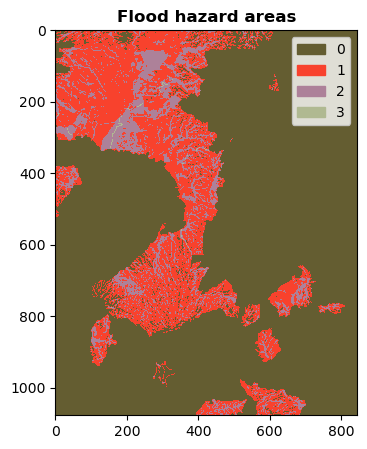

In [108]:
total_array = flood_dict['total']
flood_dict['reclass'] = np.zeros_like(total_array)
hazard_max = np.nanmax(total_array)
print((hazard_max /3 )* 2)
hazards_raster_class_1 = np.where((total_array > 0 )&(total_array <= (hazard_max/3)), 1, 0)
hazards_raster_class_2 = np.where((total_array> (hazard_max/3))&(total_array <= ((hazard_max/3)*2.5))  , 2, 0)
hazards_raster_class_3 = np.where(total_array > ((hazard_max/3)*2.5), 3, 0)
flood_dict['reclass'] += hazards_raster_class_1 + hazards_raster_class_2 + hazards_raster_class_3
plot_unique_value_raster(flood_dict['reclass'], title='Flood hazard areas')

### surge vectors

zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Bulacan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Cavite.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Laguna.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Laguna.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\MetroManila.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\NuevaEcija.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\NuevaEcija.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Bataan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Pampanga.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory1\Batangas.zip
Unique values [0 1] 
Min value 0

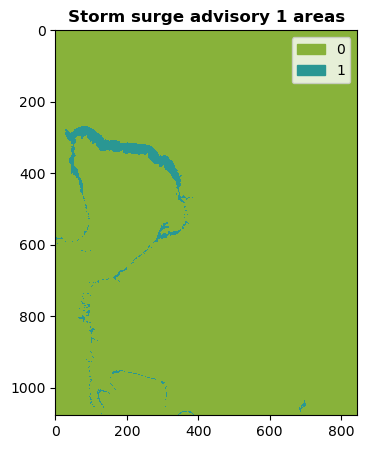

In [96]:
SSA1_raster_dict = rasterise_hazard_files(hazards_file_list = hazards_file_list, 
                                    hazards_file_path = surge_SSA1_hazards_file_path, 
                                    col = 'HAZ',
                                    replace_value = 1, 
                                    key_complement='_SSA1')
SSA1_raster_dict['total'] = np.where(SSA1_raster_dict['total']>0, 1, 0)
plot_unique_value_raster(SSA1_raster_dict['total'], title='Storm surge advisory 1 areas')

zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Bulacan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Cavite.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Laguna.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Laguna.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\MetroManila.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\NuevaEcija.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\NuevaEcija.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Bataan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Pampanga.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory2\Batangas.zip
Unique values [0 2] 
Min value 0

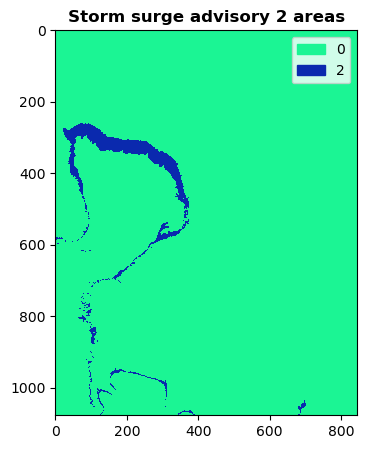

In [97]:
SSA2_raster_dict = rasterise_hazard_files(hazards_file_list = hazards_file_list, 
                                    hazards_file_path = surge_SSA2_hazards_file_path, 
                                    col = 'HAZ',
                                    replace_value = 2, 
                                    key_complement='_SSA2')
SSA2_raster_dict['total'] = np.where(SSA2_raster_dict['total']>0, 2, 0)
plot_unique_value_raster(SSA2_raster_dict['total'], title='Storm surge advisory 2 areas')

zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Bulacan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Cavite.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Laguna.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Laguna.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\MetroManila.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\NuevaEcija.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\NuevaEcija.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Bataan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Pampanga.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory3\Batangas.zip
Unique values [0 3] 
Min value 0

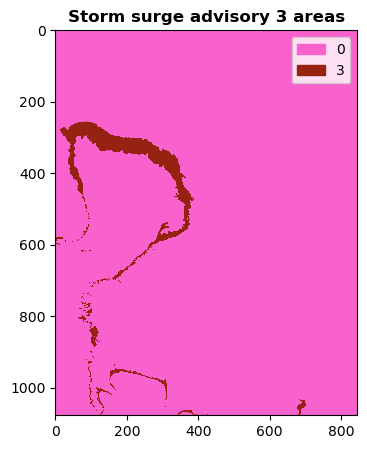

In [98]:
SSA3_raster_dict = rasterise_hazard_files(hazards_file_list = hazards_file_list, 
                                    hazards_file_path = surge_SSA3_hazards_file_path, 
                                    col = 'HAZ',
                                    replace_value = 3, 
                                    key_complement='_SSA3')
SSA3_raster_dict['total'] = np.where(SSA3_raster_dict['total']>0, 3, 0)
plot_unique_value_raster(SSA3_raster_dict['total'], title='Storm surge advisory 3 areas')

zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Bulacan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Cavite.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Laguna.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Laguna.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\MetroManila.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\NuevaEcija.zip
'/vsizip/D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\NuevaEcija.zip' does not exist in the file system, and is not recognized as a supported dataset name.
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Bataan.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Pampanga.zip
zip://D:\Dropbox\x\_data\MAN NOAH Hazard data\StormSurgeAdvisory4\Batangas.zip
Unique values [0 4] 
Min value 0

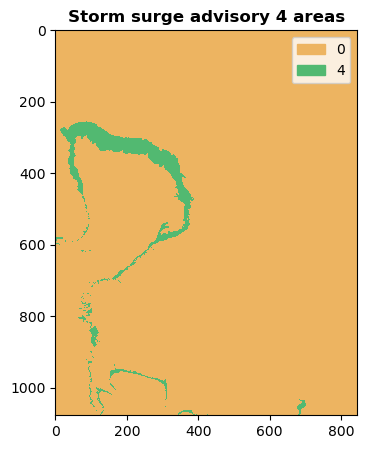

In [100]:
SSA4_raster_dict = rasterise_hazard_files(hazards_file_list = hazards_file_list, 
                                    hazards_file_path = surge_SSA4_hazards_file_path, 
                                    col = 'HAZ',
                                    replace_value = 4, 
                                    key_complement='_SSA4')
SSA4_raster_dict['total'] = np.where(SSA3_raster_dict['total']>0, 4, 0)
plot_unique_value_raster(SSA4_raster_dict['total'], title='Storm surge advisory 4 areas')

6.666666666666667
Unique values [0 1 2 3] 
Min value 0 , Type: int32


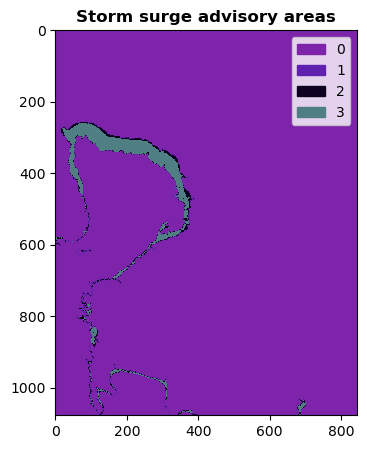

In [106]:
surge_raster_total = SSA1_raster_dict['total'] + SSA2_raster_dict['total'] + SSA3_raster_dict['total'] + SSA4_raster_dict['total']
# reclassify the raster total in 3 classes (low, mid, high)
surge_raster_reclass = np.zeros_like(surge_raster_total)
hazard_max = np.nanmax(surge_raster_total)
print((hazard_max /3 )* 2)
hazards_raster_class_1 = np.where((surge_raster_total > 0 )&(surge_raster_total <= (hazard_max/3)), 1, 0)
hazards_raster_class_2 = np.where((surge_raster_total> (hazard_max/3))&(surge_raster_total <= ((hazard_max/3)*2.5))  , 2, 0)
hazards_raster_class_3 = np.where(surge_raster_total > ((hazard_max/3)*2.5), 3, 0)
surge_raster_reclass += hazards_raster_class_1 + hazards_raster_class_2 + hazards_raster_class_3
plot_unique_value_raster(surge_raster_reclass, title='Storm surge advisory areas')

## 14.2 combine surge and flood

Unique values [0 1 2 3 4 5 6] 
Min value 0 , Type: int32


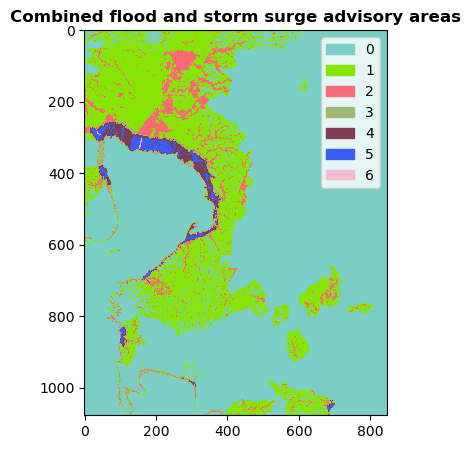

In [112]:
# now combine the flood and surge reclassified rasters, where 1 = surge or flood low, 2 = surge or flood mid, 3 = surge or flood high
hazard_raster_combined_reclass = np.maximum(flood_dict['reclass'], surge_raster_reclass)
hazard_raster_combined_total = flood_dict['reclass'] + surge_raster_reclass
plot_unique_value_raster(hazard_raster_combined_total, title='Combined flood and storm surge advisory areas')

## 14.3 export

In [113]:
# export the tiff file
export_file = True
if export_file:
    file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_150m.tif'
    url = interim_path / file_name
    export_raster(raster = hazard_raster_combined_total,
                url = url,
                data_type=rasterio.int16,
                ref_raster_path=ref_raster_150_path)


if export_file:
    file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_reclass_150m.tif'
    url = interim_path / file_name
    export_raster(raster = hazard_raster_combined_reclass,
                url = url,
                data_type=rasterio.int16,
                ref_raster_path=ref_raster_150_path)

In [116]:
# reproject the rasters to the SLEUTH AOI
file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_150m.tif'
in_url = interim_path / file_name
out_url = model_inputs_SLEUTH_150m_path / file_name

reproj_match(infile = in_url, 
             match = ref_raster_sleuth_path, 
             outfile = out_url, 
             resampling=Resampling.nearest)

file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_reclass_150m.tif'
in_url = interim_path / file_name
out_url = model_inputs_SLEUTH_150m_path / file_name

reproj_match(infile = in_url, 
             match = ref_raster_sleuth_path, 
             outfile = out_url, 
             resampling=Resampling.nearest)

Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|


# 20. Rename resampled ASCII files

In [14]:
# list all the files in the working dir

ti_city_files = []
for file in os.listdir(ti_city_ascii_path):
    if fnmatch.fnmatch(file, '*.asc'):
        ti_city_files.append(file)
ti_city_files

['airport.asc',
 'attractive2000.asc',
 'attractive2015.asc',
 'bu2000_dist.asc',
 'bu2015_dist.asc',
 'cbd.asc',
 'density2000.asc',
 'density2015.asc',
 'districts.asc',
 'exclusion.asc',
 'healthfacilities.asc',
 'landvalue.asc',
 'markets.asc',
 'road-presence.asc',
 'roads.asc',
 'schools.asc',
 'shoppingmalls.asc',
 'slope.asc',
 'structureplan.asc',
 'suburban.asc',
 'tenure.asc',
 'urban2000.asc',
 'urban2015.asc']

In [ ]:
arcgis_ascii_files = []
for file in os.listdir(ascii150_path):
    if fnmatch.fnmatch(file, '*.asc'):
        arcgis_ascii_files.append(file)
arcgis_ascii_files

['MAN_DEM_slope_100pct_150m.asc',
 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc',
 'MAN_LIM_districts_GADM4_150m.asc',
 'MAN_LIM_exclusion_layer_150m.asc',
 'MAN_LOC_airports_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_attractive_areas_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_CBDs_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_health_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_malls_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_markets_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_schools_OSM_2024_distance_normal_150m.asc',
 'MAN_LOC_suburban_centres_OSM_2024_distance_normal_150m.asc',
 'MAN_POP_density_normal_2000_WDPop_150m.asc',
 'MAN_POP_density_normal_2015_WDPop_150m.asc',
 'MAN_TRA_roads_OSM_2024_L_all_150m.asc',
 'MAN_TRA_roads_OSM_2024_L_distance_normal_150m.asc',
 'MAN_URB_distance_urbanisation_2000_EOC_WUF_150m.asc',
 'MAN_URB_distance_urbanisation_2015_EOC_WUF_150m.asc',
 'MAN_URB_tenure_150m.asc',
 'MAN_URB_urbanisation_1985_EOC_WUF_150m.asc',
 'MAN_URB_urb

In [ ]:
# build a renaming dictionary between the arcgis exports in the arcgis_ascii_files list and the TI City model inputs in the ti_city_files list
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

renaming_dict = {'slope.asc': case_city + '_dem_slope_100pct_150m.asc', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.asc', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.asc',
                 'structureplan.asc': case_city + '_lim_districts_gadm4_150m.asc', # APS: I need to replace this file with the actual masterplan
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_loc_airports_osm_2024_distance_normal_150m.asc', 
                 'cbd.asc': case_city + '_loc_cbds_osm_2024_distance_normal_150m.asc',
                 'healthfacilities.asc': case_city + '_loc_health_osm_2024_distance_normal_150m.asc', 
                 'markets.asc': case_city + '_loc_markets_osm_2024_distance_normal_150m.asc', 
                 'shoppingmalls.asc': case_city + '_loc_malls_osm_2024_distance_normal_150m.asc', 
                 'schools.asc': case_city + '_loc_schools_osm_2024_distance_normal_150m.asc', 
                 'suburban.asc': case_city + '_loc_suburban_centres_osm_2024_distance_normal_150m.asc', 
                 'attractive2000.asc': case_city + '_loc_attractive_areas_osm_2024_distance_normal_150m.asc', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_loc_attractive_areas_osm_2024_distance_normal_150m.asc', 
                 'roads.asc': case_city + '_tra_roads_osm_2024_l_distance_normal_150m.asc', 
                 'bu2000_dist.asc': case_city + '_urb_distance_urbanisation_2000_eoc_wuf_150m.asc', 
                 'bu2015_dist.asc': case_city + '_urb_distance_urbanisation_2015_eoc_wuf_150m.asc', 
                 'tenure.asc': case_city + '_urb_tenure_150m.asc', 
                 'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.asc',
                 'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.asc', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_tra_roads_osm_2024_l_all_150m.asc', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.asc', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.asc'
}
# rasters not included in the above correpondence (yet): none, 2 files are 'stand-ins'

In [ ]:
print('The renaming dictionary has', len(renaming_dict), 'entries')
for i in renaming_dict.values():
    print(i)


The renaming dictionary has 23 entries
MAN_dem_slope_100pct_150m.asc
MAN_lim_exclusion_layer_150m.asc
MAN_lim_districts_gadm4_150m.asc
MAN_lim_districts_gadm4_150m.asc
MAN_loc_airports_osm_2024_distance_normal_150m.asc
MAN_loc_cbds_osm_2024_distance_normal_150m.asc
MAN_loc_health_osm_2024_distance_normal_150m.asc
MAN_loc_markets_osm_2024_distance_normal_150m.asc
MAN_loc_malls_osm_2024_distance_normal_150m.asc
MAN_loc_schools_osm_2024_distance_normal_150m.asc
MAN_loc_suburban_centres_osm_2024_distance_normal_150m.asc
MAN_loc_attractive_areas_osm_2024_distance_normal_150m.asc
MAN_loc_attractive_areas_osm_2024_distance_normal_150m.asc
MAN_tra_roads_osm_2024_l_distance_normal_150m.asc
MAN_urb_distance_urbanisation_2000_eoc_wuf_150m.asc
MAN_urb_distance_urbanisation_2015_eoc_wuf_150m.asc
MAN_urb_tenure_150m.asc
MAN_pop_density_normal_2000_wdpop_150m.asc
MAN_pop_density_normal_2015_wdpop_150m.asc
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc
MAN_tra_roads_osm_2024_l_all_150m.asc
MAN_u

In [ ]:
print(ti_city_ascii_path)

..\model\MAN\data\in


In [ ]:
# code adapted from https://www.geeksforgeeks.org/python-shutil-copyfile-method/

success_list = []
fail_list = []
for key in renaming_dict.keys():
    source = ascii150_path / renaming_dict[key]
    dest = ti_city_ascii_path / key
    
    try :
        shutil.copyfile(source, dest)
        success_list.append(dest)
    
    # If Source is a file but destination is a directory
    except IsADirectoryError:
        print("Source is a file but destination is a directory.")
        fail_list.append(dest)
    
    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
        fail_list.append(dest)

    # If source is a directory but destination is a file
    except NotADirectoryError:
        print("Source is a directory but destination is a file.")
        fail_list.append(dest)
    
    # For permission related errors
    except PermissionError:
        print("Operation not permitted.")
        fail_list.append(dest)
    
    # For other errors
    except:
        print("Error occurred while copying file:\n", source)
        fail_list.append(dest)
print('Tried to copy:', len(renaming_dict), 'files\n', 'Succesfully copied:', len(success_list), 'files\n','The files copied were:',)
print('\n'.join(''.join(str(sl)) for sl in success_list))
if len(fail_list) > 0:
    print('Failed to copy:', len(fail_list), 'files\n','The files not copied were:')
    print('\n'.join(''.join(str(sl)) for sl in fail_list))

Tried to copy: 23 files
 Succesfully copied: 23 files
 The files copied were:
..\model\MAN\data\in\slope.asc
..\model\MAN\data\in\exclusion.asc
..\model\MAN\data\in\districts.asc
..\model\MAN\data\in\structureplan.asc
..\model\MAN\data\in\airport.asc
..\model\MAN\data\in\cbd.asc
..\model\MAN\data\in\healthfacilities.asc
..\model\MAN\data\in\markets.asc
..\model\MAN\data\in\shoppingmalls.asc
..\model\MAN\data\in\schools.asc
..\model\MAN\data\in\suburban.asc
..\model\MAN\data\in\attractive2000.asc
..\model\MAN\data\in\attractive2015.asc
..\model\MAN\data\in\roads.asc
..\model\MAN\data\in\bu2000_dist.asc
..\model\MAN\data\in\bu2015_dist.asc
..\model\MAN\data\in\tenure.asc
..\model\MAN\data\in\density2000.asc
..\model\MAN\data\in\density2015.asc
..\model\MAN\data\in\landvalue.asc
..\model\MAN\data\in\road-presence.asc
..\model\MAN\data\in\urban2000.asc
..\model\MAN\data\in\urban2015.asc


# The end (for now).